# **Importing files and Set-up**

In [168]:
#Importing relevant packages 
#run this if code is not running in notebook 
#!{sys.executable} -m pip install openpyxl 
#!{sys.executable} -m pip install pingouin 


import sys
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import scipy
import scipy.stats as stats
import pingouin as pg



#setting data display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 100



In [169]:
#Run this section for finding the files names storded in Input folder

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       print(os.path.join(dirname, filename))

In [170]:
#creating sepearate data frame to each file
df_listings = pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings.csv',  encoding = "ISO-8859-1")
df_reviews = pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews.csv', encoding = "ISO-8859-1")
df_dict_reviews = pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Reviews_data_dictionary.csv', encoding = "ISO-8859-1")
df_dict_listings = pd.read_csv('/kaggle/input/airbnb-listings-reviews/Airbnb Data/Listings_data_dictionary.csv', encoding = "ISO-8859-1")

#additional files exist (which are exports of processed data), some are not mandatory, see comments in the code

In [171]:
df_listings.head(10)

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Buttes-Montmartre,NaN,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1.0,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",53,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
1,3705183,39 mÃÂ² Paris (Sacre CÃ âur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,NaN,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allo...",120,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Elysee,NaN,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",89,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Vaugirard,NaN,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long term stays allowed""]",58,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Passy,NaN,Paris,48.85500,2.26979,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""...",60,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
5,4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Temple,NaN,Paris,48.86428,2.35370,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays all...",95,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
6,6021700,2P - Entre Bastille et Republique,8053690,2013-08-09,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Popincourt,NaN,Paris,48.86384,2.37101,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""TV"", ""Kitchen"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Fire extinguisher"", ""Long term st...",80,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
7,6945740,57sqm btw. Bastille & PÃÂ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Popincourt,NaN,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term ...",59,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
8,7491966,Charming appartment near the Parc Buttes Chaumont,35812762,2015-06-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Chaumont,NaN,Paris,48.87871,2.37489,Entire apartment,Entire place,2,1.0,"[""Paid parking off premises"", ""Shampoo"", ""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Hair dryer"", ""Esse...",80,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f
9,7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Opera,NaN,Paris,48.87790,2.33122,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Hangers"", ""Wifi"", ""E...",90,2,1125,100.0,10

Functions definitions

In [172]:
# function which returns grouped data with aggregation of count 
def grouping_df_for_count(group_by_column_name,column_to_count):
    grouped = df_listings[[group_by_column_name,column_to_count]].groupby(by= group_by_column_name).count()
    grouped.rename(columns= {column_to_count:"count"},inplace=True)#check name
    return grouped

# function which ploting subplots of box-plots based on categories which needs to be included   
def subplots_box_plots_of_series(subplot_categories, fig_size, title, y_label):
    fig, axs = plt.subplots(ncols=3, nrows=int(len(subplot_categories)/3)+1, figsize=fig_size)
    for i in range(0,len(subplot_categories)):
        df_listings[subplot_categories[i]].plot(kind='box', ax=axs.flat[i], ylabel= y_label)
    for remove_ind in range(i+1,(int(len(subplot_categories)/3)+1)*3): #removing not-needed axes in subplots
        fig.delaxes(axs.flat[remove_ind])
    fig.suptitle(title, y=0.92, fontsize=14)
    
def amenities_dict_creation(dataframe):    
    amenity_to_listings = {}

    column_index = dataframe.columns.get_loc("amenities")
    dataframe_without_NAN = dataframe.dropna(subset = ["amenities"])

    for i in range(0, dataframe_without_NAN.shape[0]): 
        column_value = dataframe_without_NAN.iloc[i, column_index]
        column_value = column_value.replace("[","")
        column_value = column_value.replace("]","")
        column_value = column_value.replace('" ','')
        column_value = column_value.replace(' "','')
        column_value = column_value.replace('"','')

        splitted = column_value.split(',')

        for amenity in splitted:
            listing_id = dataframe_without_NAN.iloc[i, 0] 
            if amenity in amenity_to_listings:
                amenity_to_listings[amenity].append(listing_id)
            else:
                amenity_to_listings[amenity] = [listing_id]

    return amenity_to_listings 

def grouping_values_per_dict_key(dictonary):
    #summarized_amenity_to_listings is the sum of values per each key (amenity) 
    summarized_dictonary_with_grouped_values = { k: len(v) for k, v in dictonary.items()}
    return summarized_dictonary_with_grouped_values
 

def sum_values_per_each_dictonary_keys(dictonary):    
    summarized_dict_per_values = grouping_values_per_dict_key(dictonary)
    summarized_10perc_list_per_values = sorted(summarized_dict_per_values.items(), key=lambda x:x[1], reverse=True)

    summarized_10perc_sorted_dict_per_values = dict(summarized_10perc_list_per_values)
    keys=summarized_10perc_sorted_dict_per_values.keys()
    values=summarized_10perc_sorted_dict_per_values.values()

    return keys,values

def checking_sample_size_requirement(dataframe, sample_size_threshold):

    data_not_meeting_sample_size = []
    series_value_counts = dataframe.iloc[:,1].value_counts()
    for index in series_value_counts.index:
        value = series_value_counts.loc[index]
        if value<sample_size_threshold:
            data_not_meeting_sample_size.append(index)
    dataframe_meeting_sample_size = dataframe[~dataframe.iloc[:,1].isin(data_not_meeting_sample_size)]
    if len(data_not_meeting_sample_size)!=0:
        print(f"category {dataframe.columns[1]} not meeting sample size req for the following categories values {data_not_meeting_sample_size}")
    return dataframe_meeting_sample_size

def creating_df_per_category(data_frame, category):
    if data_frame[category].dtype !="O":
        data_frame[category] = data_frame[category].astype("Int64")# united type
    values = data_frame[category].unique()
    values_no_NA= values[values!="NA"]
    df_price_per_category= pd.DataFrame()

    for unique_value in values_no_NA:
        globals()[f"value{unique_value}"] = data_frame[["price[USD]", category]].loc[data_frame[category]==unique_value].dropna()
        df_price_per_category = pd.concat([df_price_per_category,globals()[f"value{unique_value}"]],ignore_index=True)
    
    df_price_per_category_meeting_sample_size = checking_sample_size_requirement(df_price_per_category,15)
    return df_price_per_category_meeting_sample_size


#checking ANOVA by hist and equal varience test 
def checking_ANOVA(dataframe_price_per_category_value, country_name):
   
    category_values = dataframe_price_per_category_value.iloc[:,1].unique()
    category_values_no_NA=category_values[category_values!="NA"]
    
    axis_id=0
    fig, axs = plt.subplots(ncols=3, nrows=int(len(category_values_no_NA)/3)+1, figsize=[30, 8 if dataframe_price_per_category_value.iloc[:,1].dropna().nunique()<4 else 3*dataframe_price_per_category_value.iloc[:,1].dropna().nunique()])    
    for unique_value in category_values_no_NA:
        
        globals()[f"price_{unique_value}"] = dataframe_price_per_category_value["price[USD]"].loc[dataframe_price_per_category_value.iloc[:,1]==unique_value].dropna()
        price_per_country_hist = globals()[f"price_{unique_value}"].hist(bins=20, ax=axs.flat[axis_id])
        axs.flat[axis_id].set_title(f"Histogram of {unique_value} {dataframe_price_per_category_value.columns[1]} prices")
        fig.suptitle(f" Histograms of {dataframe_price_per_category_value.columns[1]}'s prices at {country_name}",y=0.97, fontsize=14)
        axis_id=axis_id+1
        
    for remove_ind in range(axis_id,(int(len(category_values_no_NA)/3)+1)*3): #removing not-needed axes in subplots
        fig.delaxes(axs.flat[remove_ind])

    #Performing Levene’s test for equal variances.    
    #The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
    levene_results = pg.homoscedasticity(dataframe_price_per_category_value, dv="price[USD]", group=dataframe_price_per_category_value.columns[1], method='levene', alpha=0.05)
    print(f"levene's test results:\n {levene_results}")
    
def checking_ANOVA_per_countries_and_categories(data_frame,country_name_column_name,category):
    country_names = data_frame[country_name_column_name].unique()
    data_frame_all_countries_per_category= pd.DataFrame()
    previous_name = " "
    for name in country_names:
        print("\n")
        print(f"Results for country:{name}")
        data_frame_of_country = data_frame[data_frame[country_name_column_name]== name]
        data_frame_of_country_per_category = creating_df_per_category(data_frame_of_country, category)
        data_frame_of_country_per_category.rename(columns= {data_frame_of_country_per_category.columns[1]:f"{data_frame_of_country_per_category.columns[1]} {name}"},inplace=True)
        data_frame_all_countries_per_category = pd.concat([data_frame_all_countries_per_category,data_frame_of_country_per_category], axis=1)
        checking_ANOVA(data_frame_of_country_per_category,name)
    return data_frame_all_countries_per_category

def checking_ANOVA_per_countries(data_frame,country_name_column_name):
    data_frame_of_country = creating_df_per_category(data_frame, country_name_column_name)
    checking_ANOVA(data_frame_of_country,"database")
    return data_frame_of_country

def testing_for_outliers(df_price_per_country_and_category):
    if df_price_per_country_and_category.shape[1]>2:
        for i in range(0,df_price_per_country_and_category.shape[1]-1,2):
            df_price_and_category_single_country = df_price_per_country_and_category.iloc[:,i:i+2].dropna()
            print(f"\nOutliers test results for:{df_price_and_category_single_country.columns[1]}")

            for unique_value in df_price_and_category_single_country.iloc[:,1].unique():
                df_price_single_country_per_category_value = df_price_and_category_single_country[df_price_and_category_single_country.iloc[:,1]==unique_value].dropna()
                Q1 = np.percentile(df_price_single_country_per_category_value["price[USD]"], 25, interpolation = 'midpoint')
                Q3 = np.percentile(df_price_single_country_per_category_value["price[USD]"], 75, interpolation = 'midpoint')
                IQR = Q3 - Q1
                print(f"{unique_value} group")
                upper = np.where(df_price_single_country_per_category_value["price[USD]"] >= (Q3+1.5*IQR))
                # Below Lower bound
                lower = np.where(df_price_single_country_per_category_value["price[USD]"] <= (Q1-1.5*IQR))
                print(f"Number of values above upper bound:{len(upper[0])} ,Number of values below lower bound: {len(lower[0])}")
    else:# for data frame evaluating the category as prices only
        for country in df_price_per_country_and_category["country_name"].unique():
            df_price_and_category_single_country = df_price_per_country_and_category[df_price_per_country_and_category["country_name"]==country].dropna()
            Q1 = np.percentile(df_price_and_category_single_country["price[USD]"], 25, interpolation = 'midpoint')
            Q3 = np.percentile(df_price_and_category_single_country["price[USD]"], 75, interpolation = 'midpoint')
            IQR = Q3 - Q1
            print(f"outliers test results for:{country}")
            # Above Upper bound
            upper = np.where(df_price_and_category_single_country["price[USD]"] >= (Q3+1.5*IQR))
            print("Number of values above upper bound:",len(upper[0]))
            # Below Lower bound
            lower = np.where(df_price_and_category_single_country["price[USD]"] <= (Q1-1.5*IQR))
            print("Number of values below lower bound:", len(lower[0]))
            
            
def mood_median_test_results_between_categories_values(df_price_per_country_and_category): 
    for i in range(0,df_price_per_country_and_category.shape[1],2):
        if df_price_per_country_and_category.shape[1]>2:
            categories_values = df_price_per_country_and_category.iloc[:,i+1].value_counts().index
            country_name = df_price_per_country_and_category.iloc[:,i+1].name
            print(country_name)
        else:# for data frame evaluating the category as prices only.value_counts().index
            categories_values = df_price_per_country_and_category.iloc[:,1].value_counts().index
        categories_values = np.array(categories_values)
        categories_values.sort()
        medians_between_groups_not_equal=[]
        medians_between_groups_can_be_equal=[]
        for run_ind_1 in range(0,len(categories_values)):
            for run_ind_2 in range(run_ind_1+1,len(categories_values)):
                if df_price_per_country_and_category.shape[1]>2:
                    Pearsons_chi_squared_statistic, p, median, contingency_tbl = stats.median_test(df_price_per_country_and_category.iloc[:,i:i+1][df_price_per_country_and_category.iloc[:,i+1]==categories_values[run_ind_1]].values[:,0],df_price_per_country_and_category.iloc[:,i:i+1][df_price_per_country_and_category.iloc[:,i+1]==categories_values[run_ind_2]].values[:,0], nan_policy="omit")
                else:
                    Pearsons_chi_squared_statistic, p, median, contingency_tbl = stats.median_test(df_price_per_country_and_category.iloc[:,0][df_price_per_country_and_category.iloc[:,1]==categories_values[run_ind_1]].values,df_price_per_country_and_category.iloc[:,0][df_price_per_country_and_category.iloc[:,1]==categories_values[run_ind_2]].values, nan_policy="omit")

                if p<0.05:
                    medians_between_groups_not_equal.append([categories_values[run_ind_1],categories_values[run_ind_2]])
                if p>=0.05:
                    medians_between_groups_can_be_equal.append([categories_values[run_ind_1],categories_values[run_ind_2]])
        print(f"Median's between groups are not equal per Mood's median test (p<0.05):\n {medians_between_groups_not_equal}")
        print(f"Median's between groups can be equal per Mood's median test (p>=0.05):\n {medians_between_groups_can_be_equal}")

In [173]:
#Latitude and Longitude to Country Codes, reading from file - option 1 

#Adding to dataframe country code column based on the latitude and longitude data from worldadministrativeboundariesgeojson (was downloaded from https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/)
#Due to the duration of running this code cell the results were exported, thier input details are specified in the following code cell

        #df_listings['country_code']=""
        #gdf = gpd.read_file('/kaggle/input/worldadministrativeboundariesgeojson/world-administrative-boundaries.geojson')#using a file format in a geojson since the dataset includes a lot of data  
        #ind_of_missing_codes=[]
        #counter=0 #to identify how many missing values exist
        #for i in range(0,len(df_listings['longitude'])):
            #p = Point(df_listings['longitude'][i],df_listings['latitude'][i])
            #out = gdf.loc[gdf.intersects(p), 'iso_3166_1_alpha_2_codes']#format in which to return country code
            #if len(out.values)!=0:# if =0, than didn't find a country code
                #df_listings['country_code'][i]=out.values[0]
            #else:
                #ind_of_missing_codes.append(i)
                #counter=counter+1

In [174]:
#Latitude and Longitude to Country Codes- option 2

# The resuls of the country_code implementations in the dataframe were already implemented and are saved in Input folder, were exported using the following code line: df_listings.to_csv("/kaggle/working/df_listings_with_codes_from_word_administrative_data.csv")
df_listings.drop(columns=df_listings.columns)
df_listings = pd.read_csv("../input/df-with-codes-word-administrative-bounderies-data/df_listings_with_codes_from_word_administrative_data.csv",  encoding = "ISO-8859-1")
df_listings.drop(columns="Unnamed: 0", inplace=True)

In [175]:
#Latitude and Longitude to Country Codes (missing values handling), using Nominatim API - option 1 

# This code cell is intended for finding the country_codes of the missing data from the worldadministrativeboundariesgeojson (gdf) file used previously. This part of the code is done using an API. Due to effiecency and API limitations, some of the codes are recieved from the file   
#Due to API calls limitations, the results of the code can be saved during run. relevant parameters are saved in comments 
            #locator = Nominatim(user_agent="airbnb_pro")
            #added_country_codes=[]

            #counter_of_values_to_save=0 #saving every 1000 values
            #file_name_ind=1 
            #for ind in ind_of_missing_codes:
                #p_n=([df_listings['latitude'][ind],df_listings['longitude'][ind]])#defining point list
                #location = locator.reverse(p_n)
                #added_country_codes.append(location.raw['address']['country_code'].upper())
                #counterr=counterr+1
                #if counter_of_values_to_save==1000:
                    #np.savetxt(f"/kaggle/working/file_{file_name_ind}.xlsx",added_country_codes, fmt='%s')
                    #counter_of_values_to_save=0
                    #file_name_ind=file_name_ind+1

            #np.savetxt(f"/kaggle/working/file_{file_name_ind+1}.xlsx",added_country_codes, fmt='%s')
            #df_listings['country_code'][ind_of_missing_codes]= added_country_codes

            #df_listings.to_csv("/kaggle/working/updated_df_listings_with_codes_full_run.csv") # use this if saving the file is desired




In [176]:
#Not mandatory for run (missing values handling)- option 2
#loading the dataframe with the missing codes 
df_listings.drop(columns=df_listings.columns)
df_listings = pd.read_csv("../input/updated-df-listings-with-codes-full-run/updated_df_listings_with_codes_full_run.csv",  encoding = "ISO-8859-1")
df_listings.drop(columns=["Unnamed: 0","Unnamed: 0.1"], inplace=True)


In [177]:
#Recieving conversion rates to USD using defined CSV (conversion rates updated up to 2022-07-15))

#1 - Country codes are converted to Currency codes

#Converting a Country_code_to_Currency_code based on Country_code_to Currency_code.xlsx file
Country_code_to_Currency_code_df=pd.DataFrame()
Country_code_to_Currency_code_df = pd.read_excel('/kaggle/input/country-code-to-currency-code/Country_code_to Currency_code.xlsx', header=1, engine='openpyxl')

Country_code_to_Currency_code_df.drop(columns= ['Unnamed: 5','Unnamed: 6','Unnamed: 7'],inplace=True)
			
				

Country_code_to_Currency_code_df.rename(columns = {'Unnamed: 0':'Country','Unnamed: 1': 'Country code (Alpha-2)','Unnamed: 2':'Country code (Alpha-3)','Unnamed: 3':'Currency','Unnamed: 4':'Currency code'},inplace=True)
#2- Creating a dictonary country_to_currency_code

country_to_currency_code = {}
unique_country_codes = pd.unique(df_listings.country_code)
for ind in range(0,len(unique_country_codes)):
    country_code = unique_country_codes[ind]
    currency_code = Country_code_to_Currency_code_df["Currency code"].loc[Country_code_to_Currency_code_df["Country code (Alpha-2)"]==unique_country_codes[ind]]
    country_to_currency_code[country_code] = currency_code.values[0]

#3 - Importing data about the coversion rates (2022-07-15) from currency code to USD (iban Website:https://www.iban.com/currency-converter#)
conversion_rate_to_usd = pd.read_csv("../input/currency-converter-to-usd-data/CURRENCY CONVERTER to USD.csv",  encoding = "ISO-8859-1")

#4 - Defining  code_to_conversion_rate to USD dictionary 
country_to_conversion_rate = {}
for ind in range(0,len(unique_country_codes)):
    country_code = unique_country_codes[ind]
    currency_code = Country_code_to_Currency_code_df["Currency code"].loc[Country_code_to_Currency_code_df["Country code (Alpha-2)"]==unique_country_codes[ind]]
    conversion_rate_to_usd_data =conversion_rate_to_usd[conversion_rate_to_usd["Currency Code"]==currency_code.values[0]]["Conversion_rate_to _USD"].values[0]
    country_to_conversion_rate[country_code] = conversion_rate_to_usd_data

In [178]:
df_listings['price[USD]']=""
for i in range (0,len(unique_country_codes)):
    df_listings['price[USD]'].loc[df_listings["country_code"]==unique_country_codes[i]]=df_listings['price']*country_to_conversion_rate[unique_country_codes[i]]

In [179]:
# adding country_names column to data frame
country_names = {"FR":"France","US": "USA", "AU":"Australia" , "IT":"Italy" , "BR":"Brazil","TR":"Turkey", "MX":"Mexico", "TH":"Thailand", "ZA":"South Africa", "CN":"China", "HK":"Hong Kong", "VA":"Vatican"}

country_names_list = []
for code in df_listings["country_code"]:
    name = country_names[code]
    country_names_list.append(name)


df_listings = df_listings.assign(country_name=country_names_list)

In [180]:
df_listings.to_csv("/kaggle/working/df_listings_with_USD_Price.csv")

# **Data Exploration**

In [181]:
# Inspecting df_listings data 

df_listings.head(10)


,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,country_code,price[USD],country_name
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Buttes-Montmartre,NaN,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1.0,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",53,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,53.3127,France
1,3705183,39 mÃÂÃÂÃÂÃÂ² Paris (Sacre CÃÂÃÂ ÃÂ¢ÃÂÃÂur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,NaN,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Wifi"", ""Long term stays allo...",120,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,120.708,France
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Elysee,NaN,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long term stays allowed""]",89,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,89.5251,France
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Vaugirard,NaN,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long term stays allowed""]",58,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,58.3422,France
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Passy,NaN,Paris,48.85500,2.26979,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Hair dryer"", ""Washer"", ""Dryer"", ""Bathtub"", ""Wifi"", ""...",60,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,60.354,France
5,4898654,NEW - Charming apartment Le Marais,505535,2011-04-13,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Temple,NaN,Paris,48.86428,2.35370,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Long term stays all...",95,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,95.5605,France
6,6021700,2P - Entre Bastille et Republique,8053690,2013-08-09,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Popincourt,NaN,Paris,48.86384,2.37101,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""TV"", ""Kitchen"", ""Washer"", ""Smoke alarm"", ""Wifi"", ""Fire extinguisher"", ""Long term st...",80,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,80.472,France
7,6945740,57sqm btw. Bastille & PÃÂÃÂÃÂÃÂ¨re Lachaise,5924709,2013-04-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Popincourt,NaN,Paris,48.86043,2.37842,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Washer"", ""Dryer"", ""Smoke alarm"", ""Wifi"", ""Long term ...",59,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,59.3481,France
8,7491966,Charming appartment near the Parc Buttes Chaumont,35812762,2015-06-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Chaumont,NaN,Paris,48.87871,2.37489,Entire apartment,Entire place,2,1.0,"[""Paid parking off premises"", ""Shampoo"", ""Heating"", ""TV"", ""Iron"", ""Kitchen"", ""Hair dryer"", ""Esse...",80,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,FR,80.472,France
9,7849932,Bel appartement plein de charme !,20833291,2014-09-02,"Paris, Ile-de-France, Fra

In [182]:
#Data shape 
print( f"df_listings has {df_listings.shape[0]} rows and {df_listings.shape[1]} columns\n")

print("The data dictionary of Listings.csv:")
df_dict_listings

df_listings has 279712 rows and 36 columns

The data dictionary of Listings.csv:


,Field,Description
0,listing_id,Listing ID
1,name,Listing Name
2,host_id,Host ID
3,host_since,Date the Host joined Airbnb
4,host_location,Location where the Host is based
5,host_response_time,Estimate of how long the Host takes to respond
6,host_response_rate,Percentage of times the Host responds
7,host_acceptance_rate,Percentage of times the Host accepts a booking request
8,host_is_superhost,Binary field to determine if the Host is a Superhost
9,host_total_listings_count,Total listings the Host has in Airbnb


In [183]:
# Inspecting df_reviews data 
df_reviews.head(10)

,listing_id,review_id,date,reviewer_id
0,11798,330265172,2018-09-30,11863072
1,15383,330103585,2018-09-30,39147453
2,16455,329985788,2018-09-30,1125378
3,17919,330016899,2018-09-30,172717984
4,26827,329995638,2018-09-30,17542859
5,74561,330089224,2018-09-30,173044789
6,140355,330194958,2018-09-30,160093807
7,162163,329980859,2018-09-30,94026758
8,167998,329950677,2018-09-30,35388162
9,178188,330213008,2018-09-30,3652511


In [184]:
#Data shape 

print( f"df_reviews has {df_reviews.shape[0]} rows and {df_reviews.shape[1]} columns\n")

print("The dictionary of Reviews.csv is:")
df_dict_reviews



df_reviews has 5373143 rows and 4 columns

The dictionary of Reviews.csv is:


,Field,Description
0,listing_id,Listing ID
1,review_id,Review ID
2,date,Review date
3,reviewer_id,Reviewer ID


In [185]:
#Data types and Null percentage 
print(f"df_reviews data types:\n{ df_reviews.dtypes}")
print("\n")
print(f"df_reviews null data percentage:\n{round((df_reviews.isnull().sum()/df_reviews.shape[0])*100,0).astype('int')}")
print("\n")

print(f"df_listings data types:\n{ df_listings.dtypes}")
print("\n")
print(f"df_listings null data percentage:\n{round((df_listings.isnull().sum()/df_listings.shape[0])*100,0).astype('int')}")


df_reviews data types:
listing_id      int64
review_id       int64
date           object
reviewer_id     int64
dtype: object


df_reviews null data percentage:
listing_id     0
review_id      0
date           0
reviewer_id    0
dtype: int64


df_listings data types:
listing_id                       int64
name                            object
host_id                          int64
host_since                      object
host_location                   object
host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost               object
host_total_listings_count      float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
district                        object
city                            object
latitude                       float64
longitude                      float64
property_type                   object
room_type                      

In [186]:
#Converting date objects to date time
df_listings['host_since']= pd.to_datetime(df_listings['host_since'])
df_reviews['date']= pd.to_datetime(df_reviews['date'])


#Converting to int
#prior to converting checked using df_listings.bedrooms/host_total_listings_count.unique(), that Int is more appropriate type
df_listings['bedrooms'] = df_listings['bedrooms'].astype('Int64') #Int64 since column includes NaN values 
df_listings['host_total_listings_count']= df_listings['host_total_listings_count'].astype('Int64')

df_listings['review_scores_rating']= df_listings['review_scores_rating'].astype('Int64')
df_listings['review_scores_accuracy']= df_listings['review_scores_accuracy'].astype('Int64')
df_listings['review_scores_cleanliness']= df_listings['review_scores_cleanliness'].astype('Int64')
df_listings['review_scores_checkin']= df_listings['review_scores_checkin'].astype('Int64')
df_listings['review_scores_communication']= df_listings['review_scores_communication'].astype('Int64')
df_listings['review_scores_location']= df_listings['review_scores_location'].astype('Int64')
df_listings['review_scores_value']= df_listings['review_scores_value'].astype('Int64')

#Converting price[USD] to float
df_listings['price[USD]'] = df_listings['price[USD]'].astype('float') 

In [187]:
# droping data which includes 40% or more NaN values
# droping price since created price in uniformed currency (USD)
# droping price min, max nights, neighbourhood,district since are not relevant to the Analysis
df_listings.drop(columns = ['district', 'price','minimum_nights', 'maximum_nights','neighbourhood','district', "host_response_time", "host_response_rate", "host_acceptance_rate","longitude","latitude" ], inplace=True)




In [188]:
#data unique values
print(f"df_reviews data contains {df_reviews.review_id.nunique()} unique reviews")
print(f"df_reviews data contains {df_reviews.listing_id.nunique()} unique reviewed listings")
print(f"df_listings data contains {df_listings.listing_id.nunique()} unique listings")


df_reviews data contains 5372983 unique reviews
df_reviews data contains 193556 unique reviewed listings
df_listings data contains 279712 unique listings


In [189]:
# data date range
print(f"df_listings data range based on the date that host was joined to Airbnb: {df_listings.host_since.min().date()} - {df_listings.host_since.max().date()})")
print(f"df_reviews data range based on the review date: {df_reviews.date.min().date()} - {df_reviews.date.max().date()})")


df_listings data range based on the date that host was joined to Airbnb: 2008-08-12 - 2021-02-26)
df_reviews data range based on the review date: 2008-11-16 - 2021-03-01)


In [190]:
#droping duplicates of reviews on the same date gaven to same place and reviewer- decided to keep the data as is, since the total review score is based on this 
#df_reviews = df_reviews.sort_values(by = ['listing_id','review_id', 'date']).drop_duplicates(subset= ['listing_id','reviewer_id','date'], keep='last', ignore_index=False)


# grouping reviews per the same same listings 
grouped_reviews = df_reviews[['review_id', 'listing_id']].groupby(by = 'listing_id').count().reset_index()
grouped_reviews.rename(columns= {'review_id':'reviews_count'},inplace=True)

In [191]:
#adding the reviews_count to df_listings dataframe
df_listings = pd.merge(df_listings, grouped_reviews, how='left', on = 'listing_id')
df_listings['reviews_count']=df_listings['reviews_count'].astype('Int64')


In [192]:
# running describe to get initial descriptive statistics 
df_listings.describe()

,listing_id,host_id,host_total_listings_count,accommodates,bedrooms,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price[USD],reviews_count
count,2.797120e+05,2.797120e+05,279547.000000,279712.000000,250277.000000,188307.000000,187999.000000,188047.000000,187941.000000,188025.000000,187937.000000,187927.000000,279712.000000,193556.000000
mean,2.638196e+07,1.081658e+08,24.581612,3.288736,1.515509,93.405195,9.565476,9.312869,9.701534,9.698593,9.633994,9.335364,109.511645,27.760147
std,1.442576e+07,1.108570e+08,284.041143,2.133379,1.153080,10.070437,0.990878,1.146072,0.867434,0.886884,0.833234,1.042625,400.580637,49.877684
min,2.577000e+03,1.822000e+03,0.000000,0.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000
25%,1.384462e+07,1.720656e+07,1.000000,2.000000,1.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,35.000000,2.000000
50%,2.767098e+07,5.826911e+07,1.000000,2.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,63.774900,8.000000
75%,3.978485e+07,1.832853e+08,4.000000,4.000000,2.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,109.000000,29.000000
max,4.834353e+07,3.901874e+08,7235.000000,16.000000,50.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,115539.916800,891.000000


**Hosts data EDA**

Text(0.5, 0, 'Year')

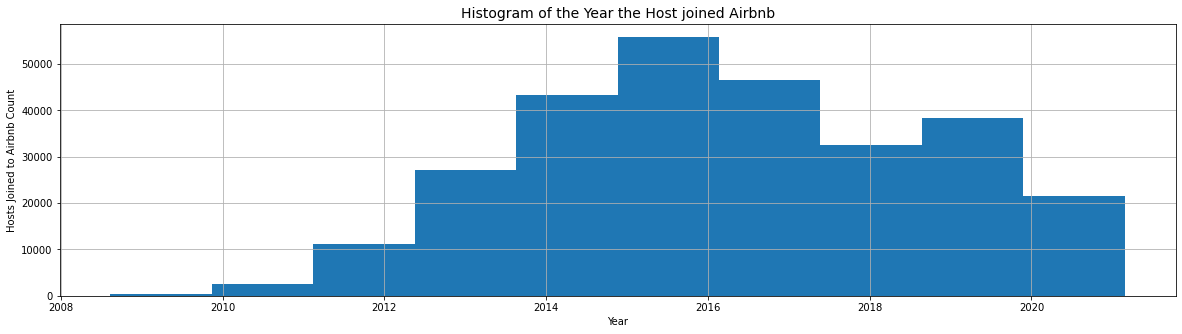

In [193]:
plt.rcParams["figure.figsize"] = [20, 5]

host_join_date_hist = df_listings["host_since"].hist()
host_join_date_hist.set_title("Histogram of the Year the Host joined Airbnb", fontsize=14)
host_join_date_hist.set_ylabel("Hosts Joined to Airbnb Count")
host_join_date_hist.set_xlabel("Year")


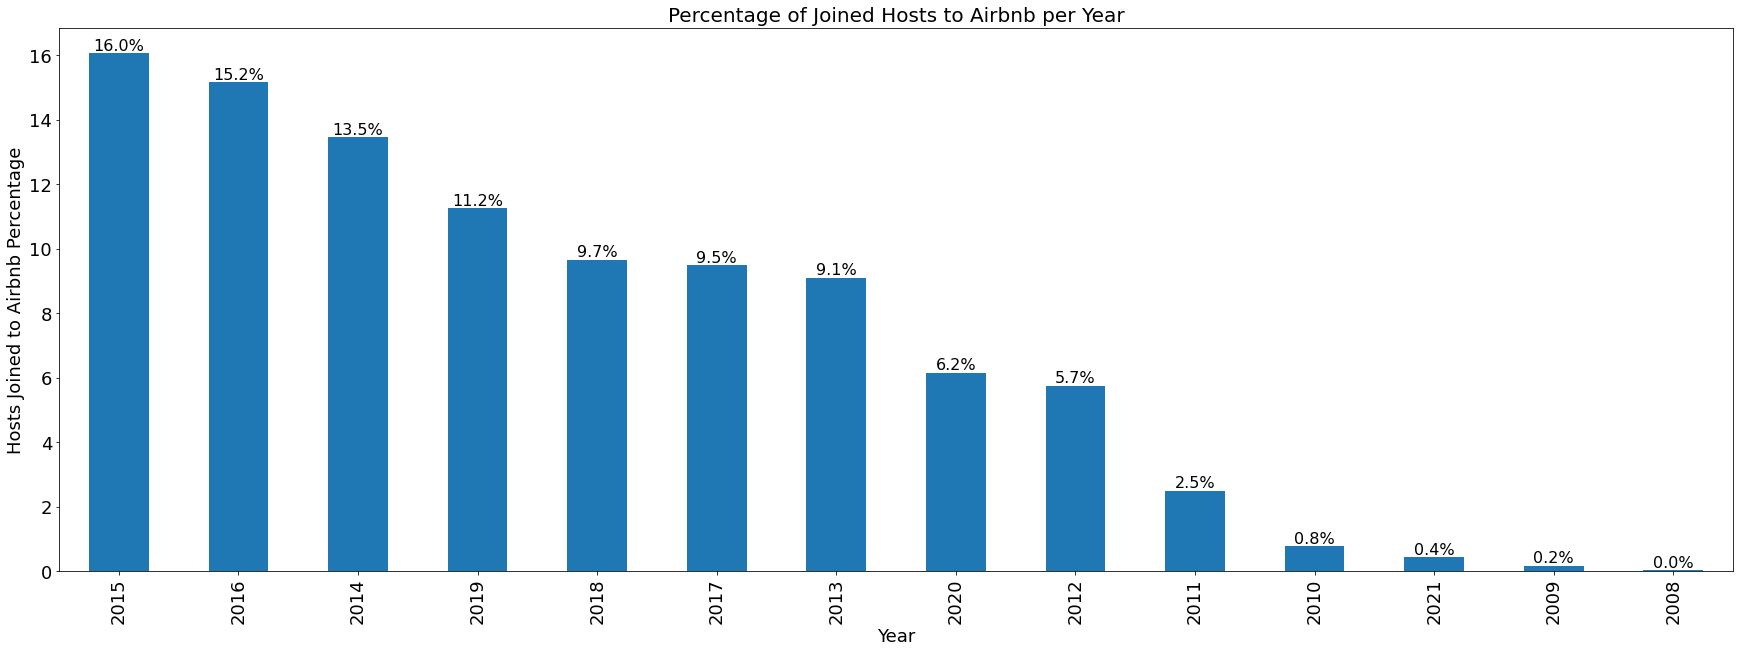

In [194]:
host_since_percentage_per_year = (df_listings["host_since"].dt.year.astype('Int64').value_counts()/len(df_listings["host_since"]))*100
ax_host_since = host_since_percentage_per_year.plot(kind='bar', fontsize=18,figsize=[30,10])
ax_host_since.set_title("Percentage of Joined Hosts to Airbnb per Year",fontsize=20)
ax_host_since.set_xlabel("Year",fontsize=18)
ax_host_since.set_ylabel("Hosts Joined to Airbnb Percentage",fontsize=18)
for container in ax_host_since.containers:
    ax_host_since.bar_label(container, fmt= "%1.1f%%", fontsize=16)

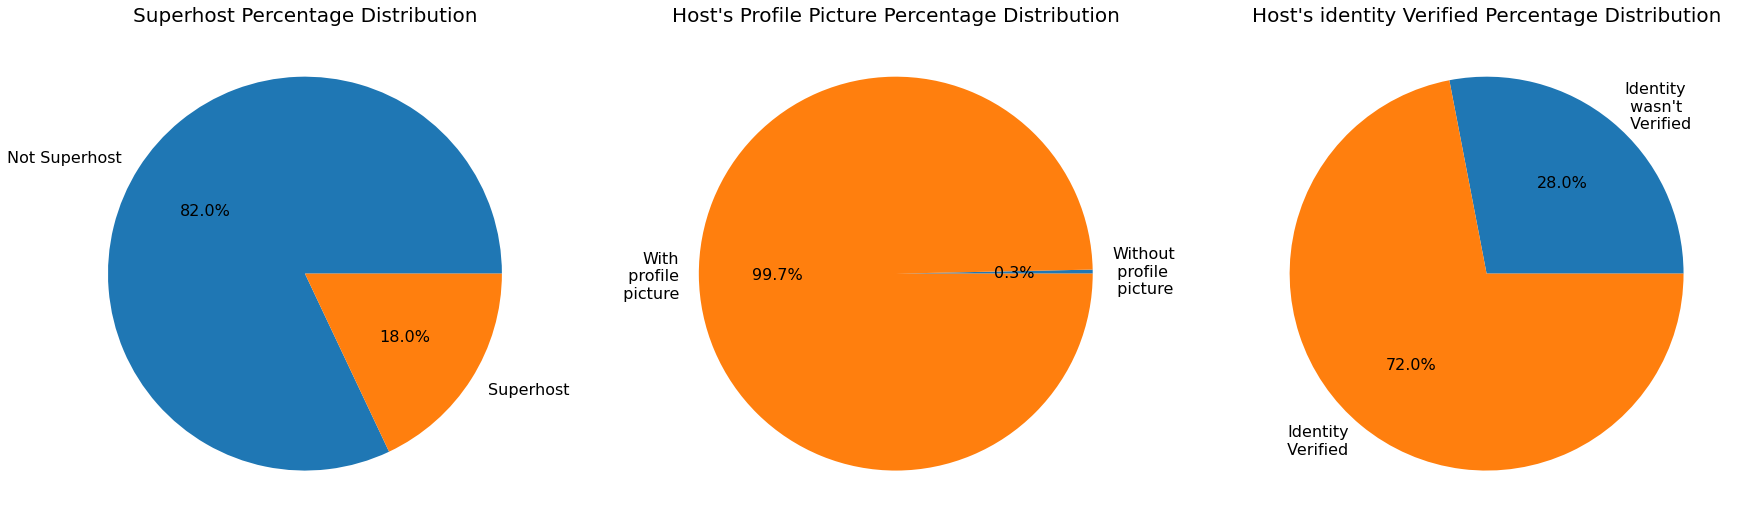

In [195]:
fig_host, (ax_host,ax2_host,ax3_host) = plt.subplots(1,3,figsize=[30,30])

titles= ["Superhost Percentage Distribution","Host's Profile Picture Percentage Distribution","Host's identity Verified Percentage Distribution"]
grouping_df_for_count("host_is_superhost","host_id").plot(kind="pie", y="count", labels=["Not Superhost", "Superhost"], autopct="%1.1f%%", ax= ax_host, legend=False, ylabel="", fontsize=16)
grouping_df_for_count("host_has_profile_pic","host_id").plot(kind="pie", y="count", labels=["Without\n profile\n picture","With\n profile\n picture"], autopct="%1.1f%%", ax= ax2_host, legend=False, ylabel="",  fontsize=16)
grouping_df_for_count("host_identity_verified","host_id").plot(kind="pie", y="count", labels=["Identity\n wasn't\n Verified","Identity\n Verified"], autopct="%1.1f%%", ax=ax3_host, legend=False, ylabel="", fontsize=16)
i=0
for ax in [ax_host,ax2_host,ax3_host]:
        ax.set_title(titles[i],fontsize=20)
        i=i+1

In [196]:
df_listings["host_total_listings_count"].value_counts()
#since 33,265 values have 0 lisitings of host_total_listings_count, the reliability of this column is in doubt and being dropped
df_listings.drop(columns = "host_total_listings_count", inplace=True)

**Listings' characteristics EDA**

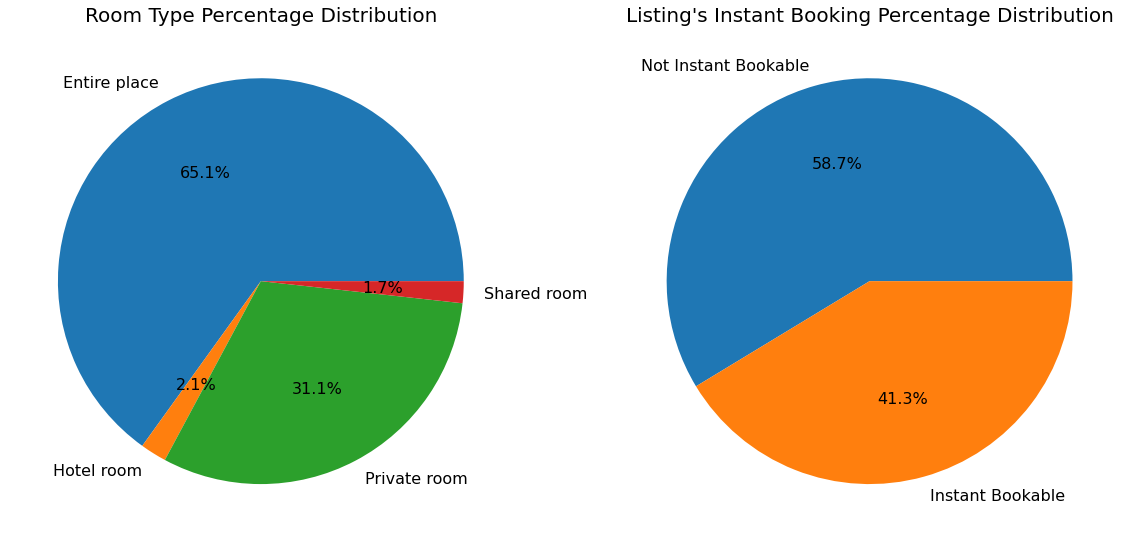

In [197]:
fig_listings, (ax_listing,ax2_listing) = plt.subplots(1,2,figsize=[20,10])
titles_listings = ["Room Type Percentage Distribution", "Listing's Instant Booking Percentage Distribution"]
grouping_df_for_count("room_type","listing_id").plot(kind="pie", y="count", autopct="%1.1f%%", ax=ax_listing, legend=False, ylabel="", fontsize=16)
grouping_df_for_count("instant_bookable","listing_id").plot(kind="pie", y="count", labels=["Not Instant Bookable","Instant Bookable"],autopct="%1.1f%%", ax=ax2_listing, legend=False, ylabel="", fontsize=16)

i=0
for ax in [ax_listing,ax2_listing]:
        ax.set_title(titles_listings[i],fontsize=20)
        i=i+1
        

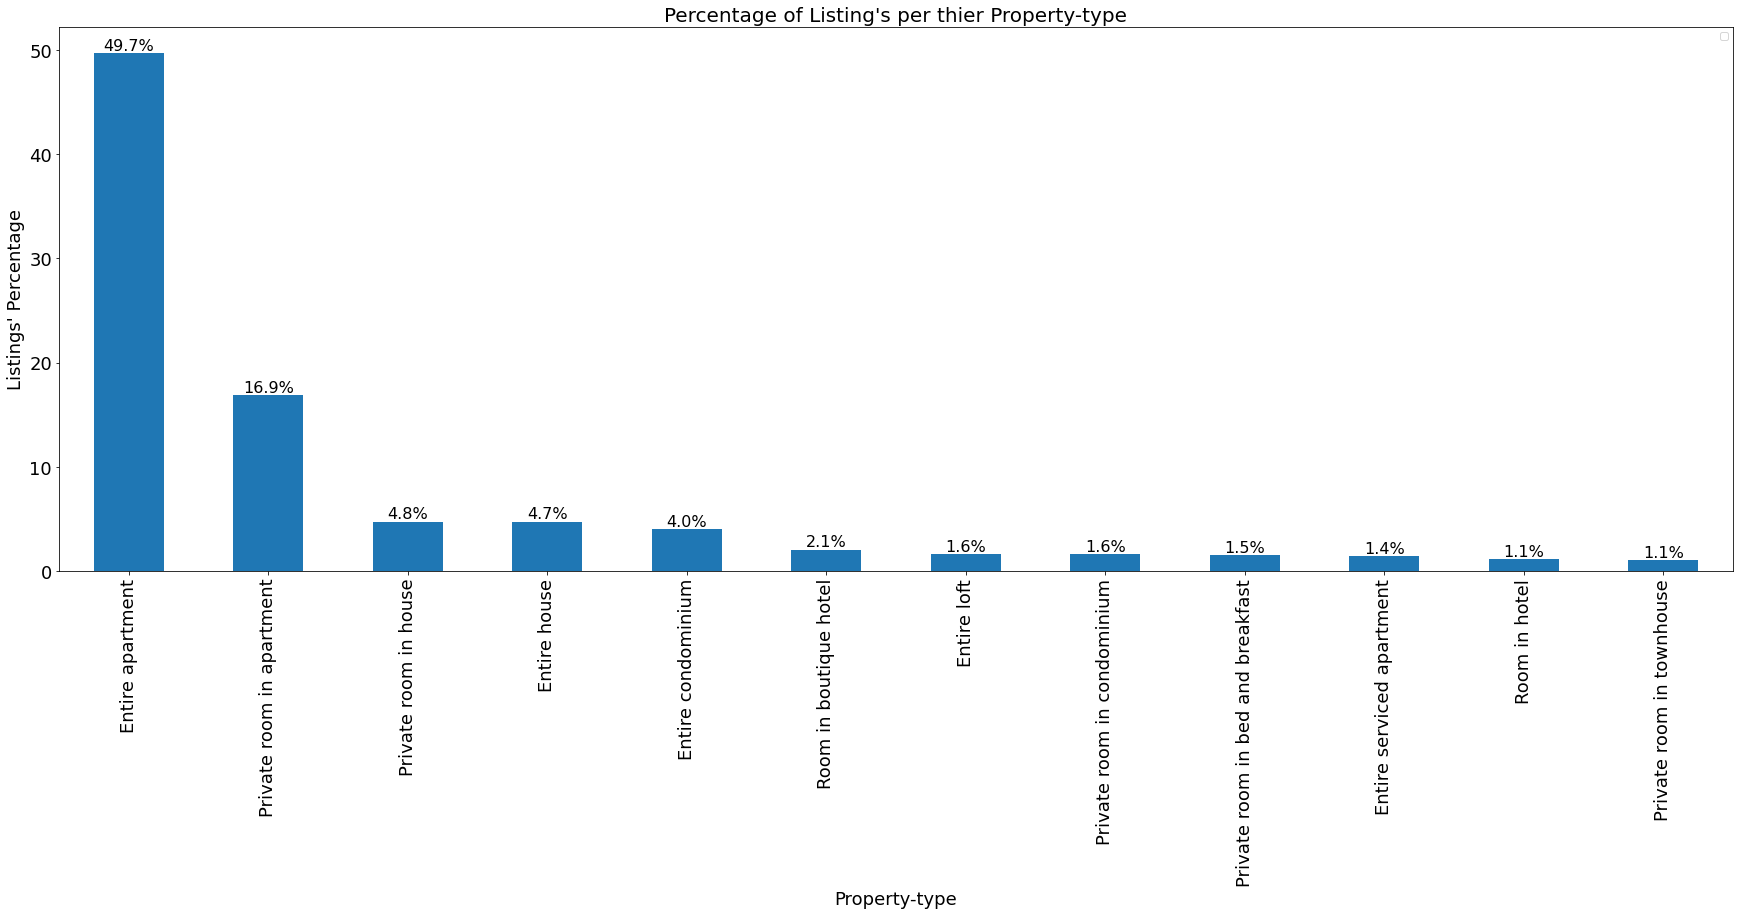

In [198]:
plt.rcParams["figure.figsize"] = [20, 5]

lisings_per_property = df_listings[["listing_id","property_type"]].groupby(by= "property_type").count()
lisings_per_property.rename(columns= {'listing_id':'num_of_listings'},inplace=True)
lisings_per_property_perc= (lisings_per_property/(len(df_listings["property_type"]))*100)
#since property_type includes a lot of properties, only properties which constitudes at least 1% of the listings are presented 
ax_listings_per_property = lisings_per_property_perc[lisings_per_property_perc["num_of_listings"]>1].sort_values(by='num_of_listings',ascending=False).plot(kind="bar", fontsize=18, figsize=[30,10])
for container in ax_listings_per_property.containers:
    ax_listings_per_property.bar_label(container, fmt= "%1.1f%%", fontsize=16)

ax_listings_per_property.set_title("Percentage of Listing's per thier Property-type" ,fontsize=20)    
ax_listings_per_property.set_ylabel("Listings' Percentage",fontsize=18)
ax_listings_per_property.set_xlabel("Property-type",fontsize=18)
ax_listings_per_property.legend("")

#since it is seen that property type includes the same information, nut more detailed than room_type, room_type is dropped
df_listings.drop(columns = "room_type", inplace=True)



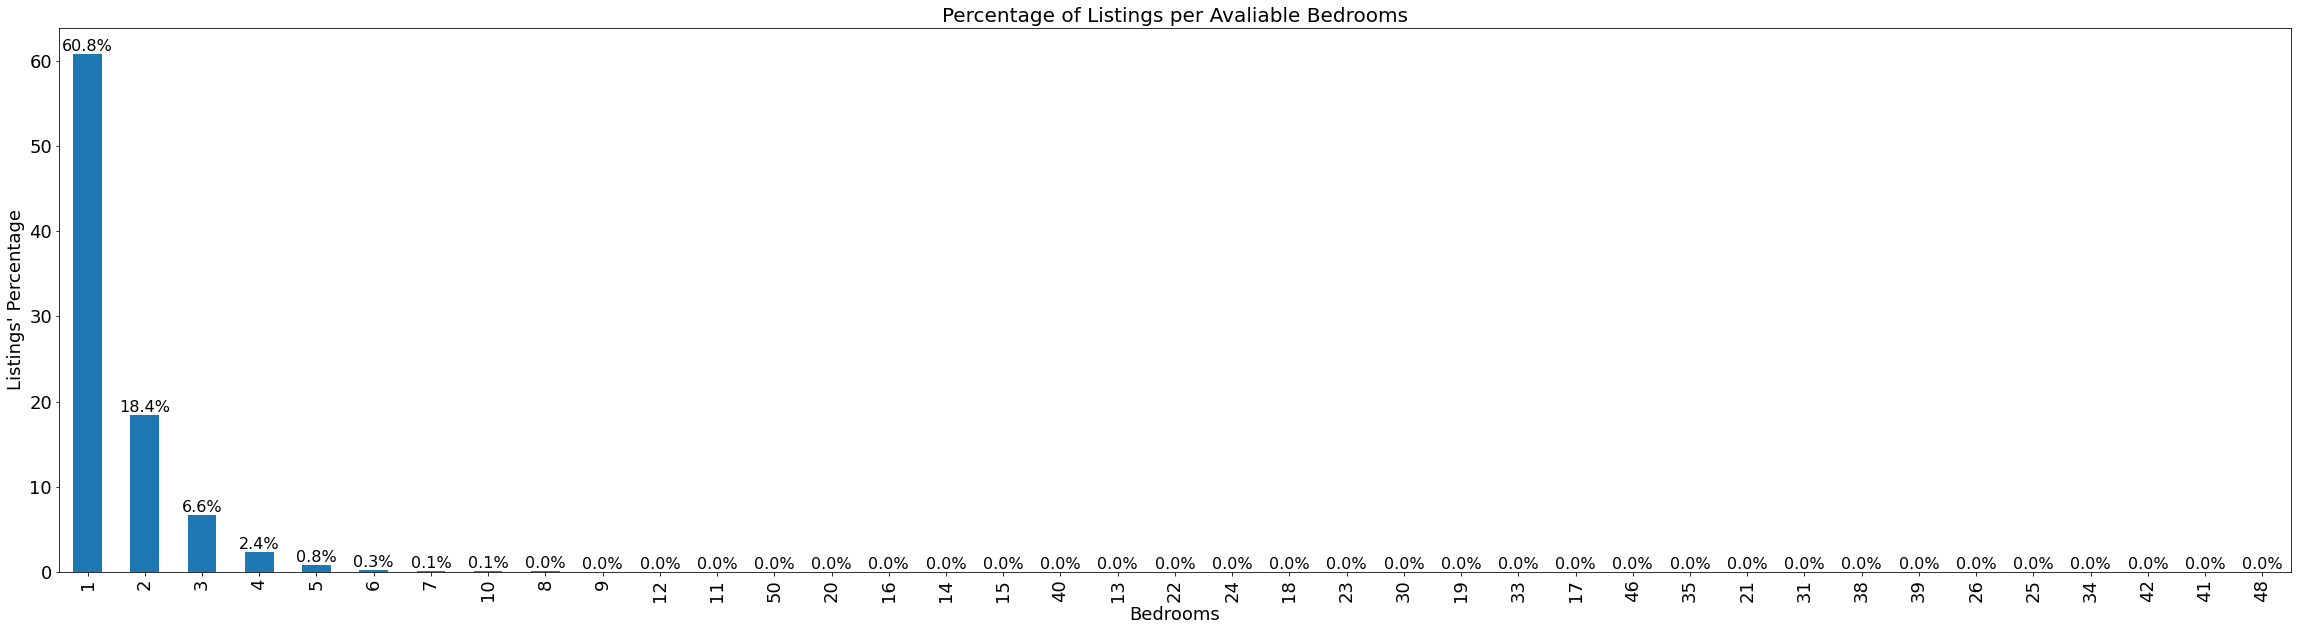

In [199]:
listings_percentage_per_bedrooms = (df_listings["bedrooms"].value_counts())/(len(df_listings["bedrooms"]))*100
ax_bedrooms = listings_percentage_per_bedrooms.plot(kind="bar", fontsize=18, figsize=[40,10])
ax_bedrooms.set_title("Percentage of Listings per Avaliable Bedrooms",fontsize=20)
ax_bedrooms.set_xlabel("Bedrooms",fontsize=18)
ax_bedrooms.set_ylabel("Listings' Percentage",fontsize=18)

for container in ax_bedrooms.containers:
    ax_bedrooms.bar_label(container, fmt= "%1.1f%%",  fontsize=16)
    



Text(0, 0.5, "Listings' Percentage")

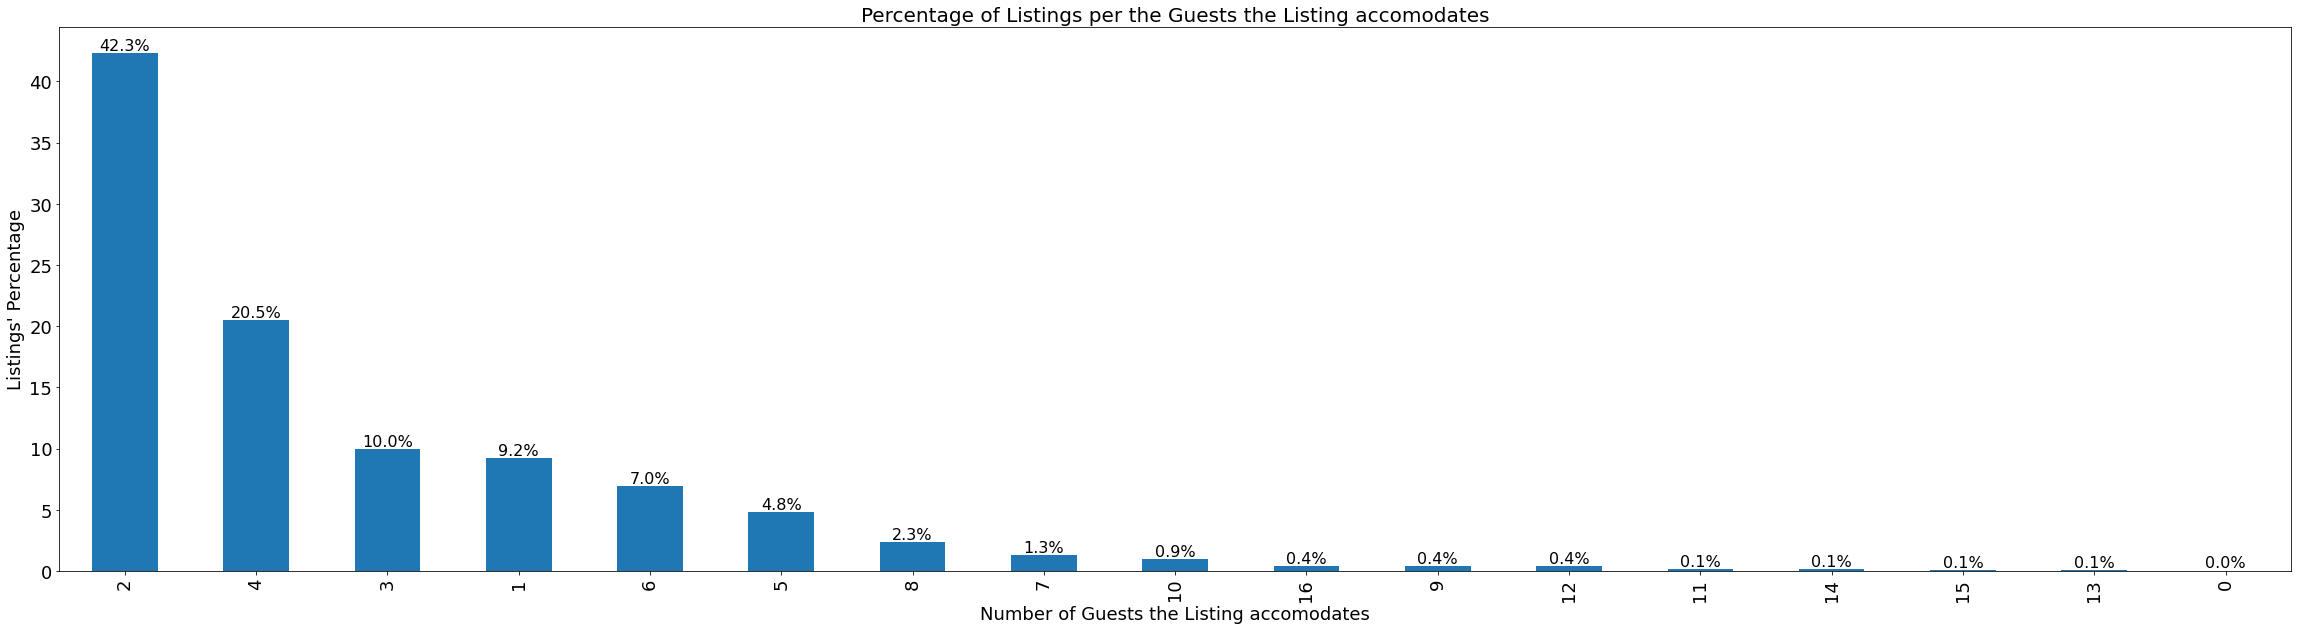

In [200]:
#Guests the Listing accomodates
listings_percentage_per_accommodates = (df_listings["accommodates"].value_counts()/len(df_listings["accommodates"]))*100
ax_accommodates = listings_percentage_per_accommodates.plot(kind="bar", fontsize=18, figsize=[40,10] )


for container in ax_accommodates.containers:
    ax_accommodates.bar_label(container, fmt= "%1.1f%%",fontsize=16)
    

ax_accommodates.set_title("Percentage of Listings per the Guests the Listing accomodates",fontsize=20)
ax_accommodates.set_xlabel("Number of Guests the Listing accomodates",fontsize=18)
ax_accommodates.set_ylabel("Listings' Percentage",fontsize=18)


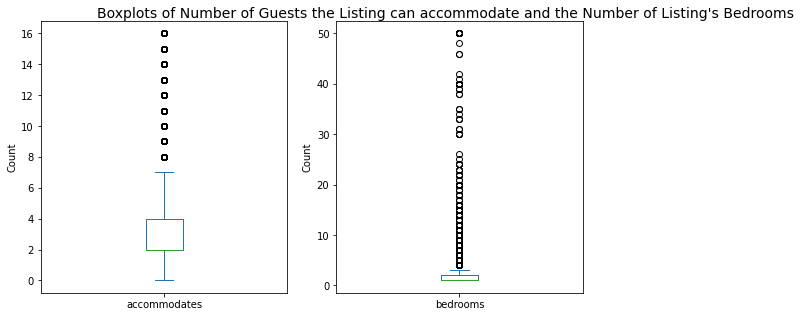

In [201]:
guests_per_listing = ["accommodates","bedrooms"]
subplots_box_plots_of_series(guests_per_listing,[15,5], "Boxplots of Number of Guests the Listing can accommodate and the Number of Listing's Bedrooms", "Count")

**Listings per thier Review Score EDA**

In [202]:
listings_percentage_per_review_score_rating_list = []
values_range = [*range(0,100,10)]
for value in values_range:
    listings_percentage_per_review_score_rating = df_listings["review_scores_rating"][df_listings["review_scores_rating"].between(value,value+10,"left")].count()/len(df_listings["review_scores_rating"])*100
    listings_percentage_per_review_score_rating_list.append(listings_percentage_per_review_score_rating)
listings_percentage_for_review_score_rating_100 = df_listings["review_scores_rating"][df_listings["review_scores_rating"]==100].count()/len(df_listings["review_scores_rating"])*100    
listings_percentage_per_review_score_rating_list.append(listings_percentage_for_review_score_rating_100)
listings_percentage_per_review_score_rating_list = list(reversed(listings_percentage_per_review_score_rating_list))

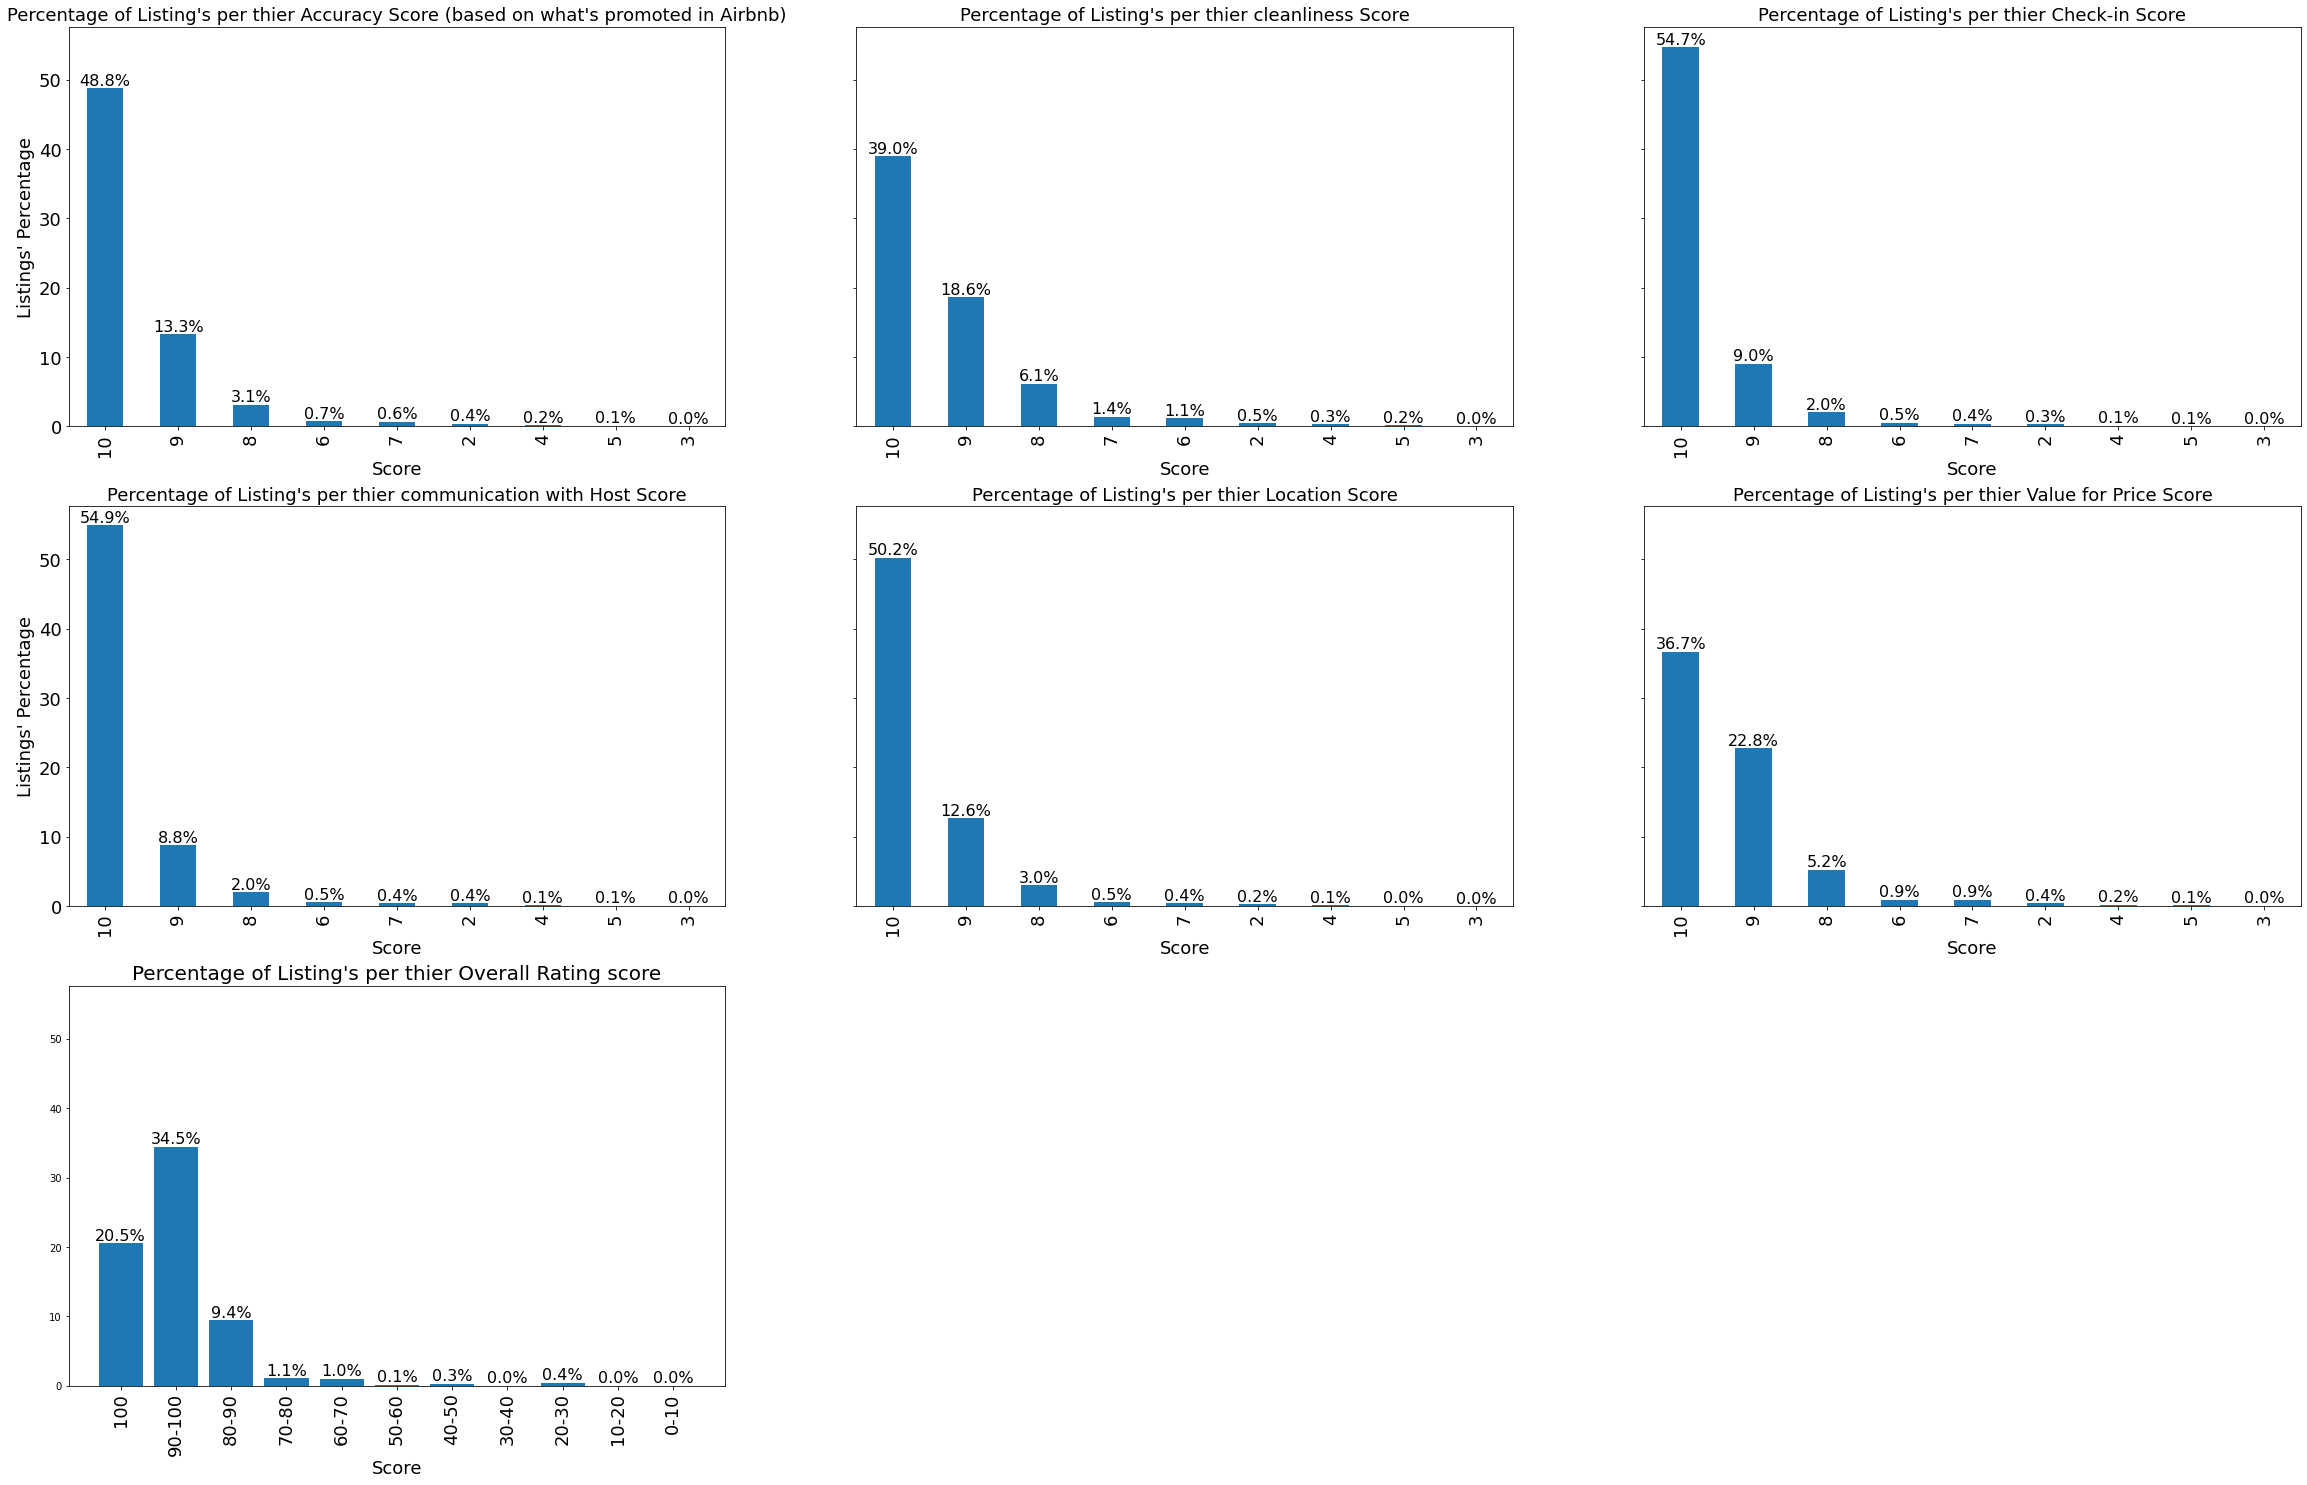

In [203]:
fig_reviews, axs = plt.subplots(3,3,figsize=[40,25],sharey=True)
titles = ["Percentage of Listing's per thier Accuracy Score (based on what's promoted in Airbnb)", "Percentage of Listing's per thier cleanliness Score", "Percentage of Listing's per thier Check-in Score" ,"Percentage of Listing's per thier communication with Host Score" ,"Percentage of Listing's per thier Location Score" , "Percentage of Listing's per thier Value for Price Score", "Percentage of Listing's per thier Overall Rating score"]
reviews = ["review_scores_accuracy","review_scores_cleanliness", "review_scores_checkin", "review_scores_communication","review_scores_location","review_scores_value" ]
ind_review=0
for review in reviews:
    (df_listings[review].value_counts()/(len(df_listings[review]))*100).plot(kind="bar",ax=axs.flat[ind_review], xlabel="Score", fontsize=18)
    axs.flat[ind_review].set_ylabel("Listings' Percentage", fontsize=18) 
    axs.flat[ind_review].set_xlabel("Score", fontsize=18)
    axs.flat[ind_review].set_title(titles[ind_review], fontsize=18)
    
    ind_review=ind_review+1
#ploting for the listings_percentage_per_review_score_rating_list 
axs.flat[ind_review].bar(['100','90-100','80-90', '70-80', '60-70','50-60', '40-50', '30-40','20-30', '10-20','0-10' ], listings_percentage_per_review_score_rating_list)

axs.flat[ind_review].set_xlabel("Score", fontsize=18)
axs.flat[ind_review].set_title(titles[ind_review], fontsize=20)
axs.flat[ind_review].set_xticklabels(['100','90-100','80-90', '70-80', '60-70','50-60', '40-50', '30-40','20-30', '10-20','0-10' ],fontsize=18, rotation=90)

for ax in axs.flat[:]:
    for container in ax.containers:
        ax.bar_label(container, fmt= "%1.1f%%", fontsize=16)

#removing the figures which are not being used in subplot
for remove_ind in range(ind_review+1,3*3):
    fig_reviews.delaxes(axs.flat[remove_ind])
    
    
    

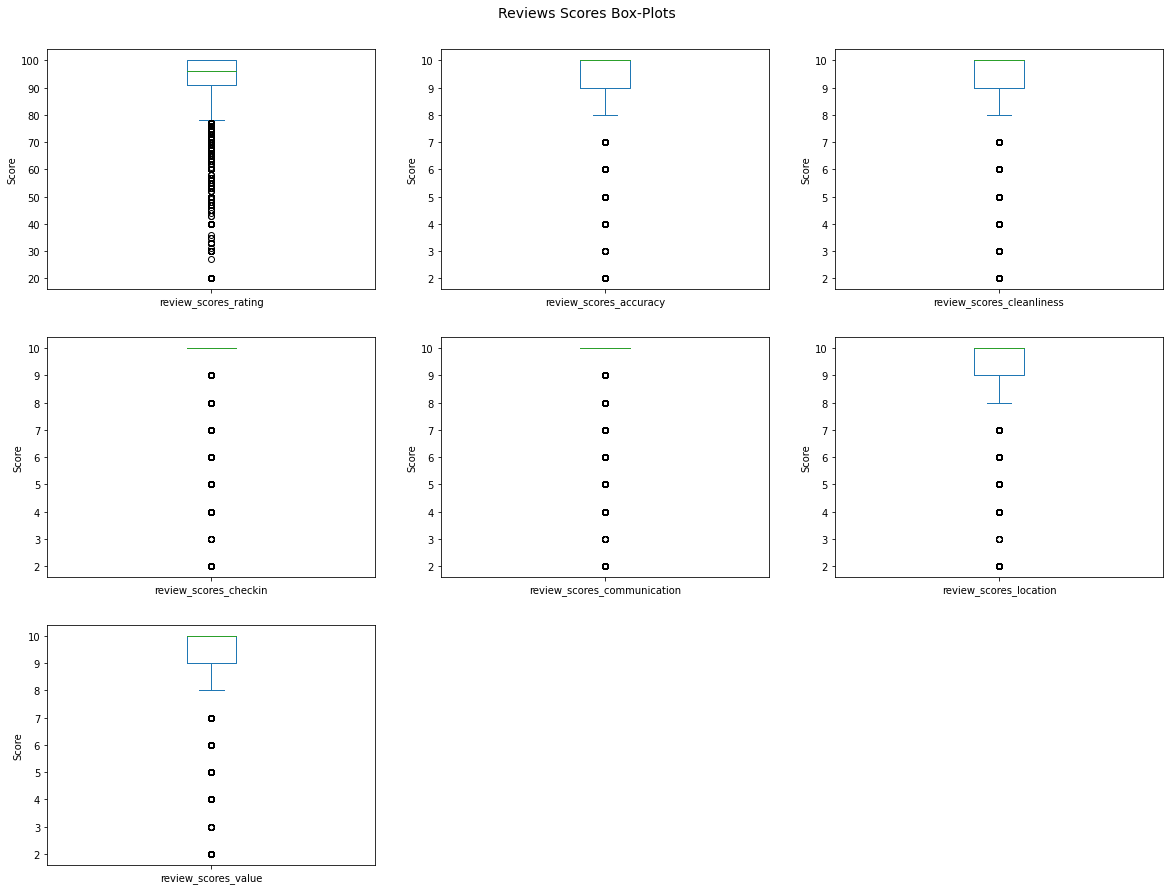

In [204]:
reviews = ["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"]
subplots_box_plots_of_series(reviews,[20,15],"Reviews Scores Box-Plots", "Score")

**Amenities EDA**

In [205]:
# creating dictonary of amenities: amenity and the listings which includes it 
amenity_to_listings_dict =  amenities_dict_creation(df_listings)
df_listings_num_of_amenities = len(amenity_to_listings_dict)
print(f"There are total of {df_listings_num_of_amenities} amenities in the dataset ")

There are total of 3235 amenities in the dataset 


In [206]:
top_rated_listings_rating = df_listings[["listing_id","review_scores_rating","amenities"]].dropna().sort_values(by ="review_scores_rating", ascending=False )[0:int(len(df_listings["price[USD]"])*10/100)]
amenity_to_top_rated_listings_dict =  amenities_dict_creation(top_rated_listings_rating)
top_rated_listings_num_of_amenities = len(amenity_to_top_rated_listings_dict)
print(f"Number of amenities of Top 10% rated listings: {top_rated_listings_num_of_amenities}")
keys_top_rated_listings_amenity_to_listings_summarized_dict, values_top_rated_listings_amenity_to_listings_summarized_dict = sum_values_per_each_dictonary_keys(amenity_to_top_rated_listings_dict) 

Number of amenities of Top 10% rated listings: 1057


Text(0, 0.5, 'Count')

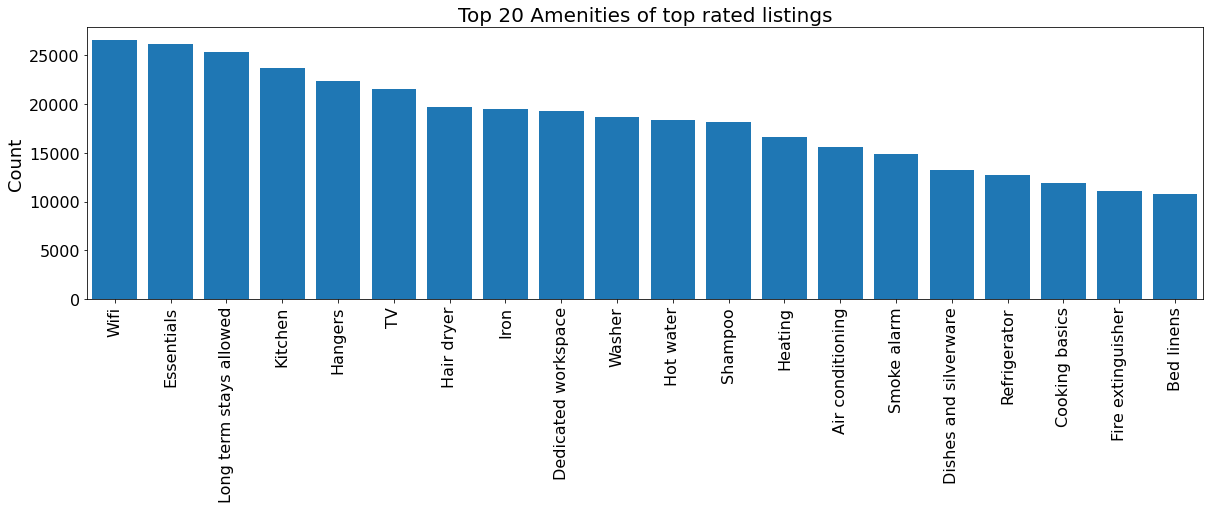

In [207]:
#ploting top 20 rated amenitis
plt.bar(list(keys_top_rated_listings_amenity_to_listings_summarized_dict)[0:20], list(values_top_rated_listings_amenity_to_listings_summarized_dict)[0:20])
plt.margins(x=0.005) 
plt.title("Top 20 Amenities of top rated listings", fontsize=20)
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.ylabel("Count", fontsize=18)

In [208]:
# Top 10% price of the listings 
listings_price_10percentage = df_listings[["listing_id","price[USD]", "amenities"]].sort_values(by ="price[USD]", ascending=False )[0:int(len(df_listings["price[USD]"])*10/100)]
amenity_to_10percentage_price_listings_dict =  amenities_dict_creation(listings_price_10percentage)
top_10percentage_price_listings_num_of_amenities = len(amenity_to_10percentage_price_listings_dict)
print(f"Number of amenities of Top 10% of most expensive listings: {top_10percentage_price_listings_num_of_amenities}")
keys_10percentage_price_amenity_to_listings_summarized_dict, values_10percentage_price_amenity_to_listings_summarized_dict = sum_values_per_each_dictonary_keys(amenity_to_10percentage_price_listings_dict)

Number of amenities of Top 10% of most expensive listings: 858


Text(0, 0.5, 'Count')

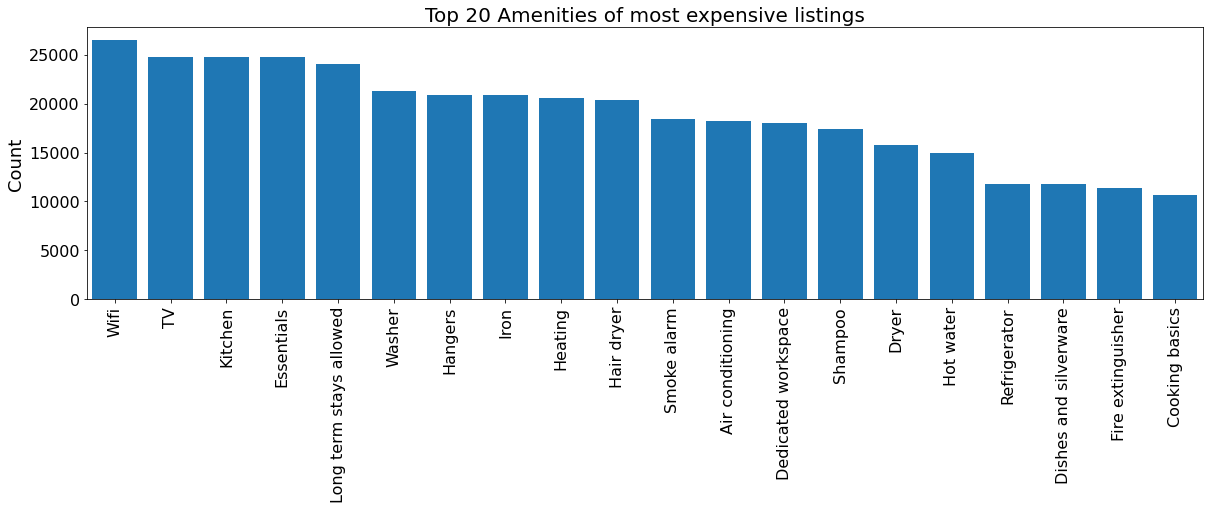

In [209]:
#ploting top 20 expensive amenitis
plt.bar(list(keys_10percentage_price_amenity_to_listings_summarized_dict)[0:20], list(values_10percentage_price_amenity_to_listings_summarized_dict)[0:20])
plt.margins(x=0.005) 
plt.title("Top 20 Amenities of most expensive listings", fontsize=20)
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.ylabel("Count", fontsize=18)

**Price [USD] EDA**

In [210]:
price_per_country= df_listings[["country_name","price[USD]"]].groupby(by="country_name").describe()
price_per_country

price[USD]                                                     \
                  count        mean         std      min      25%      50%   
country_name                                                                 
Australia       33630.0  150.014482  319.360273   3.3785  50.0018  81.0840   
Brazil          26615.0  137.230494  992.166961   0.0000  29.0136  51.7440   
China            4191.0  108.986970  284.649277   9.6265  37.0250  56.2780   
France          64690.0  113.763714  215.698827   0.0000  59.3481  80.4720   
Hong Kong        2896.0   96.955271  249.923641   0.1274  31.2130  50.9600   
Italy           27547.0  105.826143  343.772154   0.0000  45.2655  65.3835   
Mexico          20065.0   55.279071  258.393915   0.0000  18.8071  31.7941   
South Africa    19086.0  139.978004  357.534122   7.1004  37.8300  62.2158   
Thailand        19361.0   56.736990  174.168213   0.0000  19.1100  30.0300   
Turkey          24519.0   30.515542  190.145500   0.0000   8.5950  14.4396   
USA             37012.0  142.842240  275.740987   0.0000  60.0000  99.0000   
Vatican           100.0   78.631203   51.754637  19.1121  47.2773  69.4071   

                                      
                    75%          max  
country_name                          
Australia     147.97830   19333.8041  
Brazil        101.64000  115539.9168  
China         100.63395   12390.7865  
France        120.70800   12070.8000  
Hong Kong     101.79260    8493.2484  
Italy          99.58410   10633.3689  
Mexico         54.06440   24001.9000  
South Africa  128.04000   10476.0000  
Thailand       51.87000    8194.8321  
Turkey         25.72770   10287.1836  
USA           151.00000   10000.0000  
Vatican        91.03395     301.7700

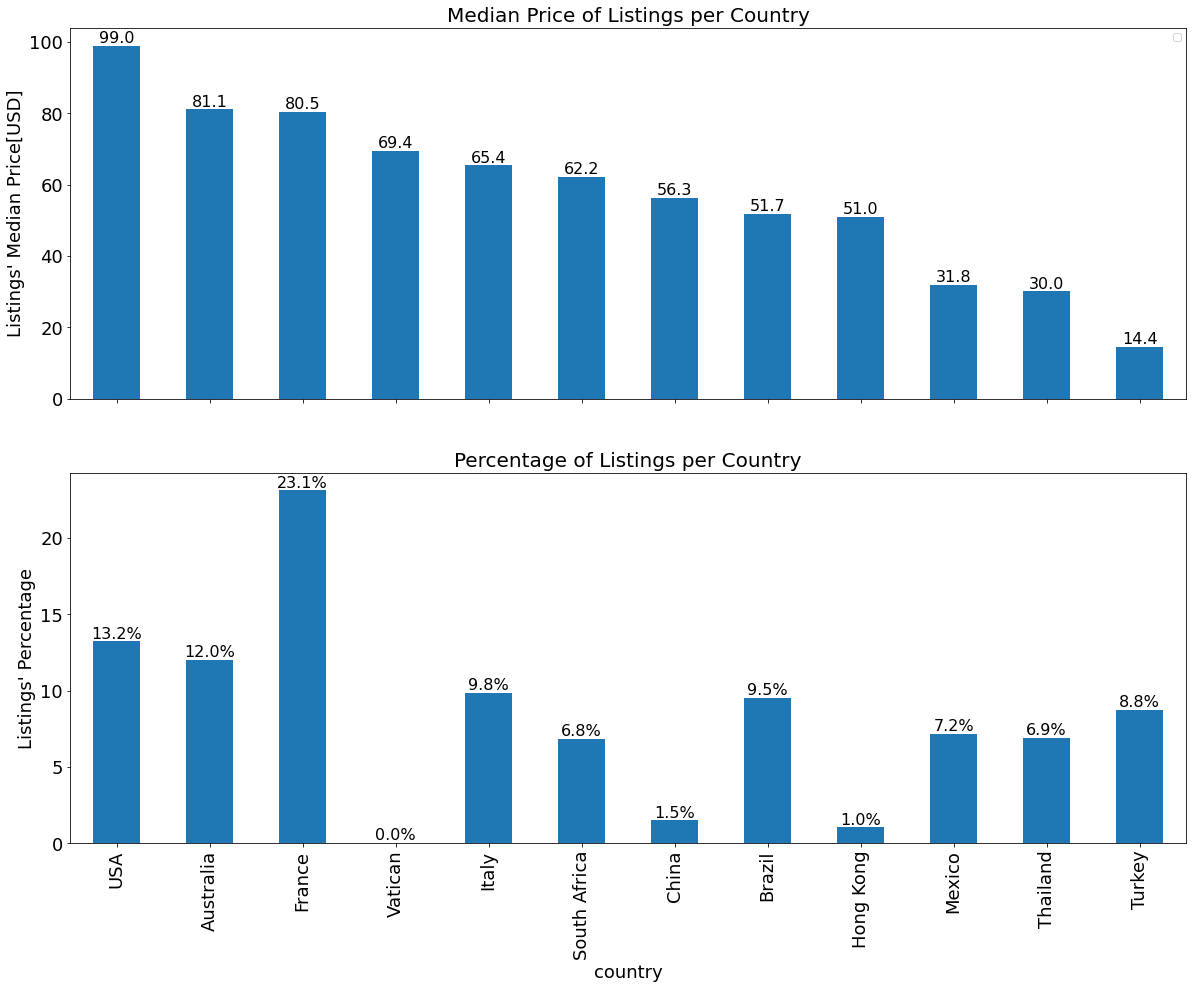

In [211]:
#Ploting the prices per country and the percentage of each country in total listings

#median price
fig_country, (ax_median_price ,ax_country_names) = plt.subplots(2,1, sharex=True, figsize=[20,15])

df_listings[["country_name","price[USD]"]].groupby(by="country_name").median().sort_values(by="price[USD]",ascending=False).plot(kind="bar", ax=ax_median_price, fontsize=18)

ax_median_price.set_title("Median Price of Listings per Country",fontsize=20)
ax_median_price.set_xlabel("country",fontsize=18)
ax_median_price.set_ylabel("Listings' Median Price[USD]",fontsize=18)
ax_median_price.legend("")
for container in ax_median_price.containers:
    ax_median_price.bar_label(container, fmt= "%1.1f",fontsize=16)

#storing the index of the 1st subplot for 2nd subplot order
order_countries_price = df_listings[["country_name","price[USD]"]].groupby(by="country_name").median().sort_values(by="price[USD]",ascending=False).index

#country in total listings percentage
# Countries names in dataset
((df_listings["country_name"].value_counts()/len(df_listings["country_name"]))*100).loc[order_countries_price].plot(kind='bar',ax= ax_country_names, fontsize=18)


ax_country_names.set_title("Percentage of Listings per Country",fontsize=20)
ax_country_names.set_xlabel("country",fontsize=18)
ax_country_names.set_ylabel("Listings' Percentage",fontsize=18)

for container in ax_country_names.containers:
    ax_country_names.bar_label(container, fmt= "%1.1f%%", fontsize=16)
    
    


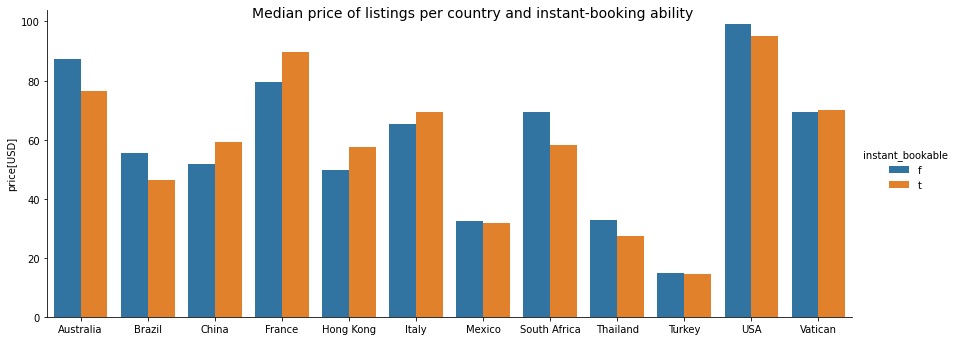

In [212]:
price_per_country_bookable= df_listings[["country_name","instant_bookable","price[USD]"]].groupby(by=["country_name","instant_bookable"]).median().reset_index()
price_per_country_bookable_facegrid = sns.catplot(x="country_name", y="price[USD]", hue="instant_bookable", kind="bar", data=price_per_country_bookable,aspect=20/8.27)
price_per_country_bookable_facegrid.fig.suptitle("Median price of listings per country and instant-booking ability", fontsize=14)
price_per_country_bookable_facegrid.set_axis_labels("")

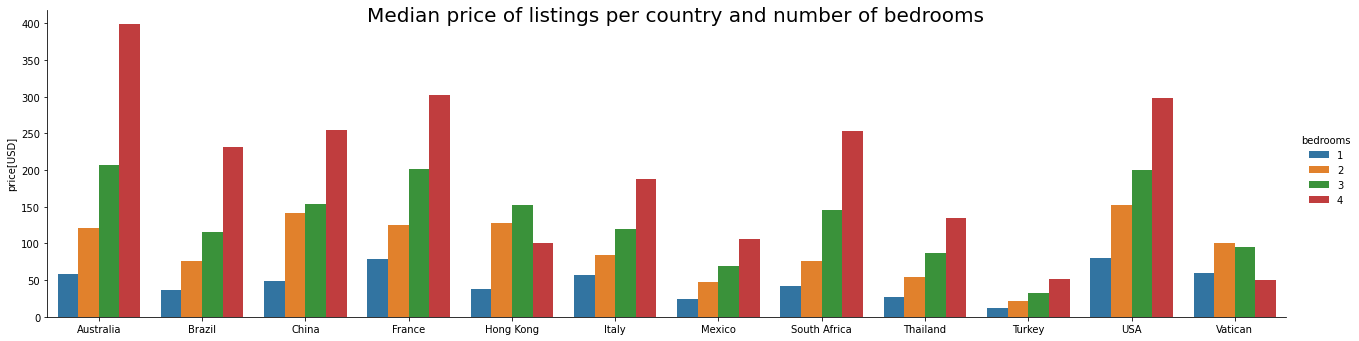

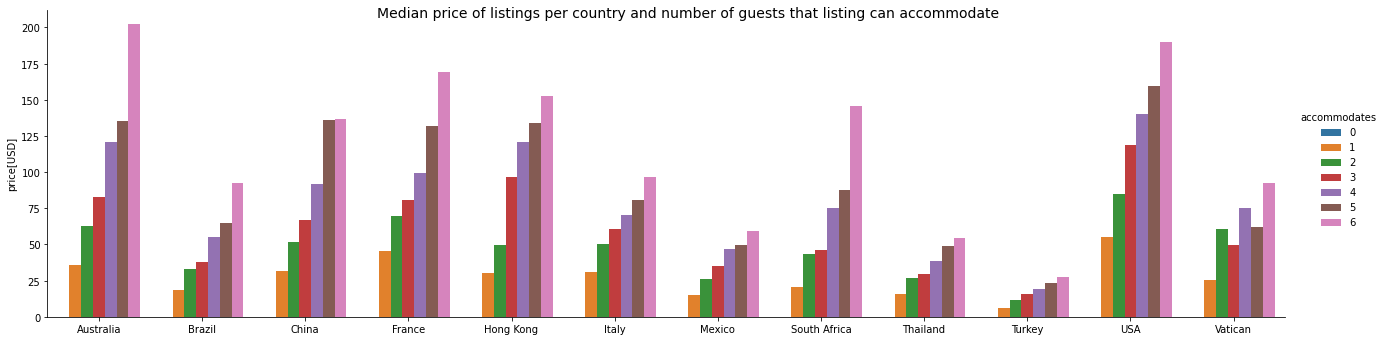

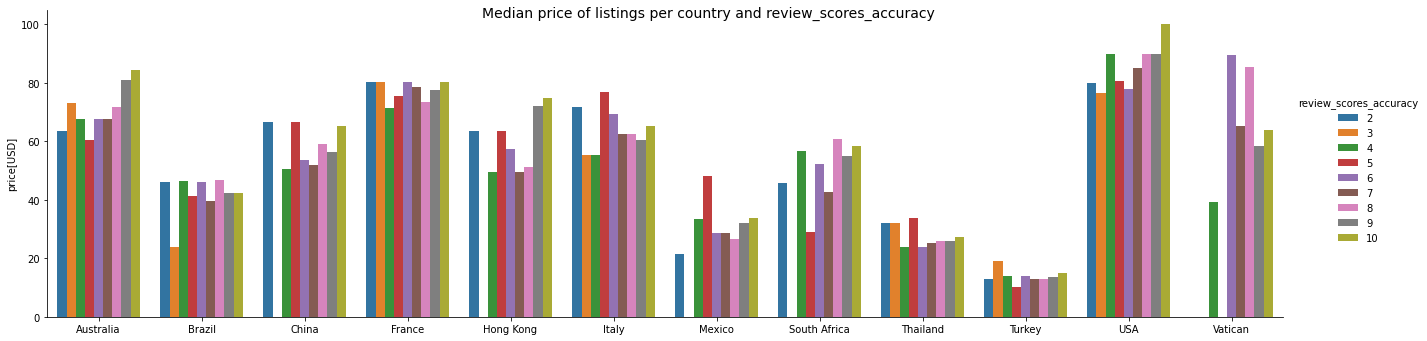

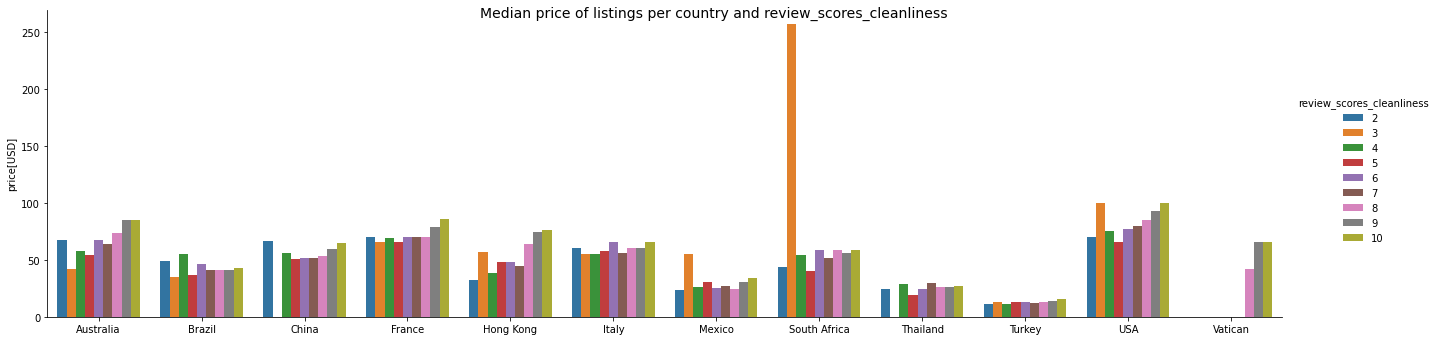

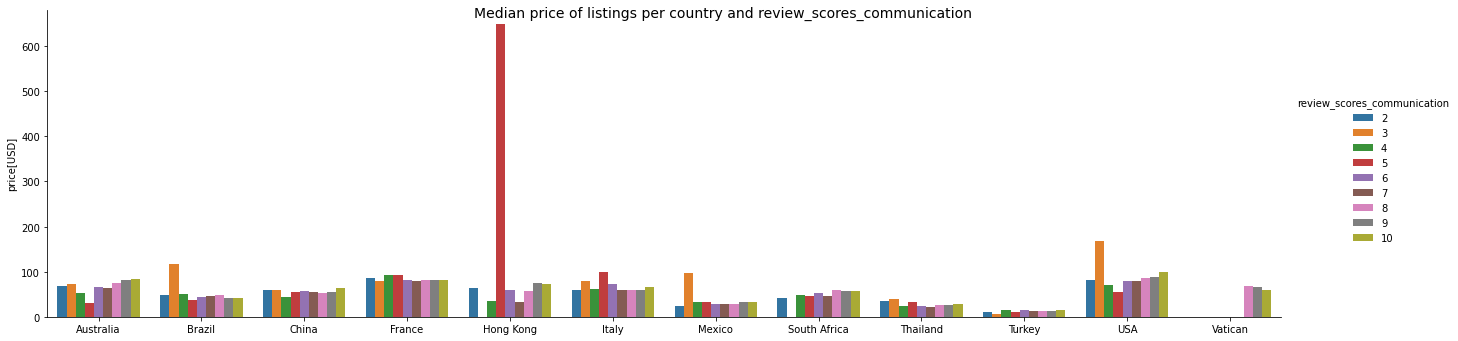

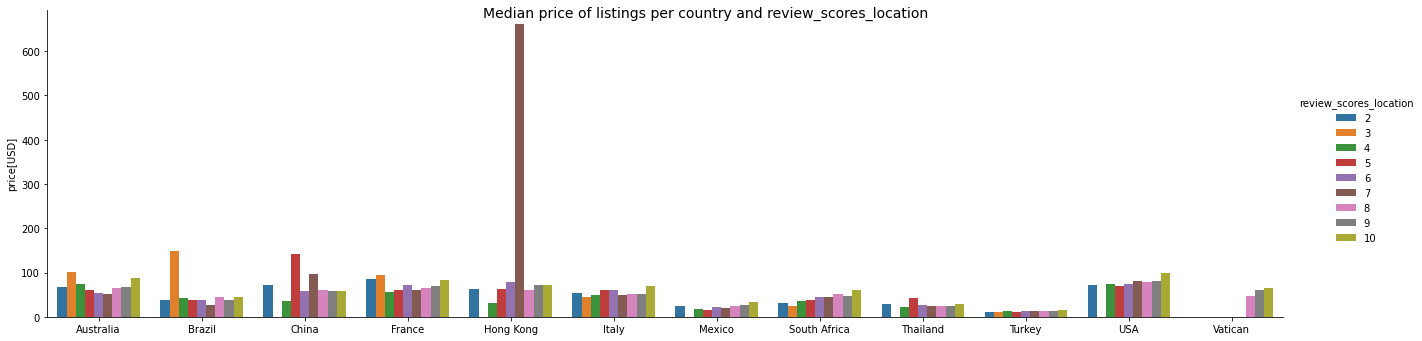

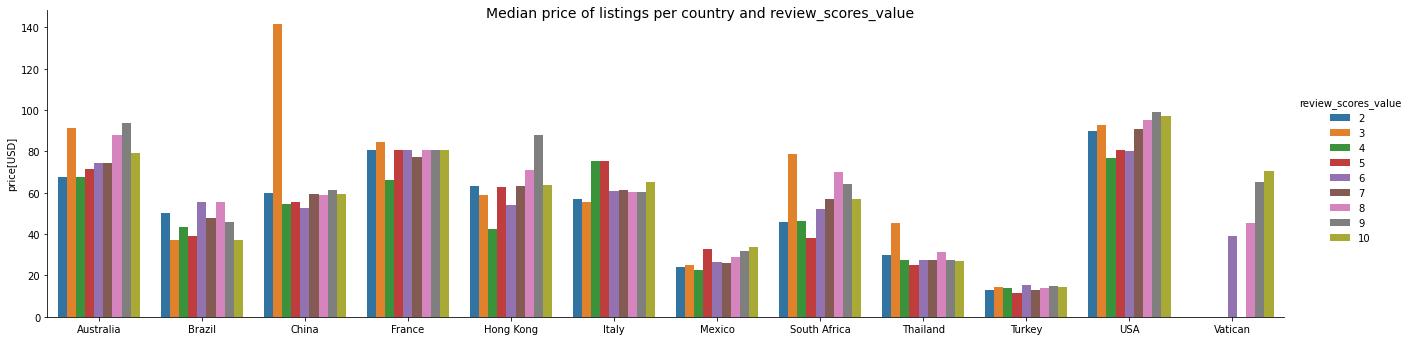

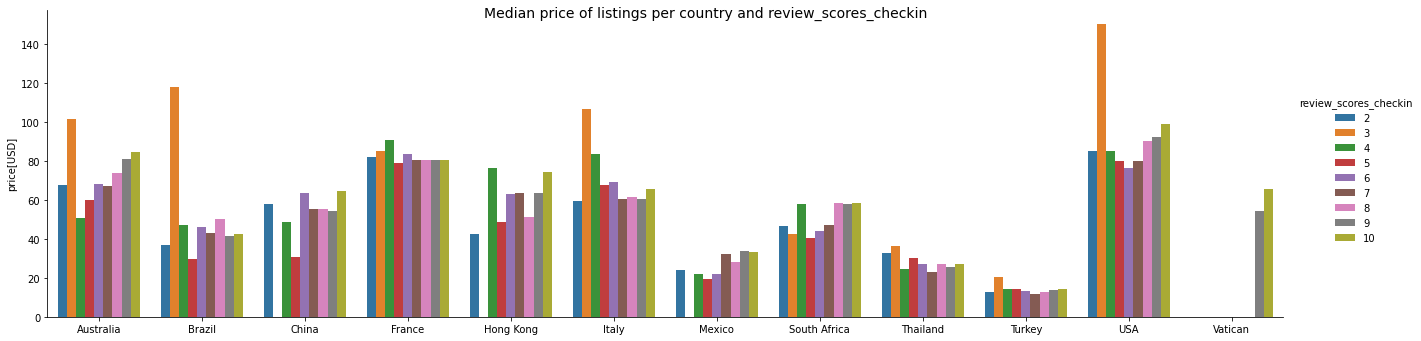

In [213]:
price_per_country_bedrooms = df_listings[["country_name","bedrooms","price[USD]"]].groupby(by=["country_name","bedrooms"]).median().reset_index()
#Only up to 4 bedrooms are presented which consistutes more than 88% percentage of the listings
price_per_country_bedrooms_facegrid= sns.catplot(x="country_name", y="price[USD]", hue="bedrooms", kind="bar", data=price_per_country_bedrooms.loc[price_per_country_bedrooms["bedrooms"]<5], aspect=30/8.27) 
price_per_country_bedrooms_facegrid.fig.suptitle("Median price of listings per country and number of bedrooms", fontsize=20)
price_per_country_bedrooms_facegrid.set_axis_labels("")


price_per_country_guests_num = df_listings[["country_name","accommodates","price[USD]"]].groupby(by=["country_name","accommodates"]).median().reset_index()
#Only listings which can accommondate up to 6 guests are presented which consistutes more than 93% percentage of the listings 
price_per_country_guests_num_facegrid = sns.catplot(x="country_name", y="price[USD]", hue="accommodates", kind="bar", data=price_per_country_guests_num.loc[price_per_country_guests_num["accommodates"]<7],aspect=30/8.27)
price_per_country_guests_num_facegrid.fig.suptitle("Median price of listings per country and number of guests that listing can accommodate", fontsize=14)
price_per_country_guests_num_facegrid.set_axis_labels("")



hue_by_variables = ["review_scores_accuracy", "review_scores_cleanliness", "review_scores_communication", "review_scores_location" ,"review_scores_value", "review_scores_checkin"]
for variable in hue_by_variables:
    grouped_df = df_listings[["country_name",variable,"price[USD]"]].groupby(by=["country_name",variable]).median().reset_index()
    facegrid = sns.catplot(x="country_name", y="price[USD]", hue=variable, kind="bar", data=grouped_df,aspect=30/8.27)
    facegrid.fig.suptitle(f"Median price of listings per country and {variable}", fontsize=14)
    facegrid.set_axis_labels("")


Text(0.5, 0.98, 'Median price of listings per country and review scores rating')

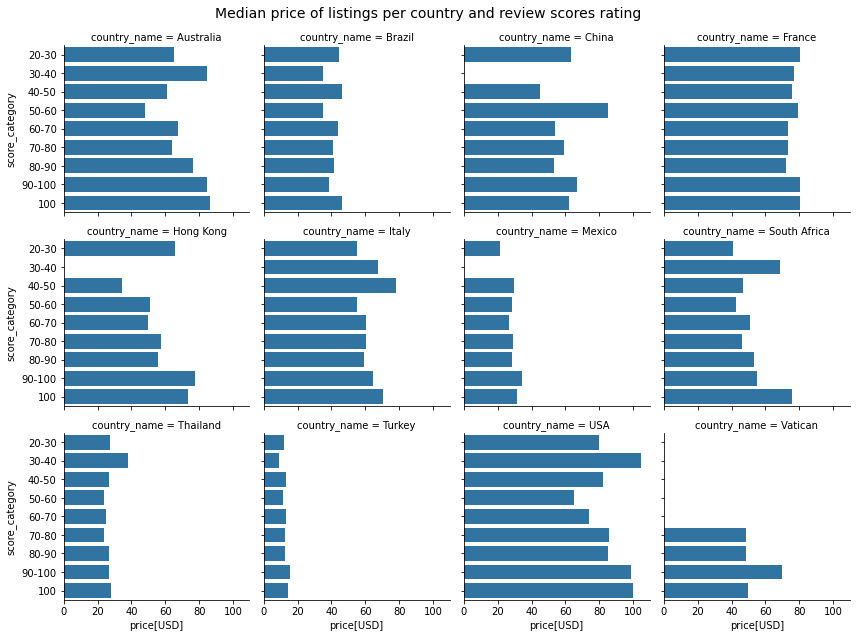

In [214]:
price_per_country_review_rating= pd.DataFrame()
values_range = [*range(0,100,10)]
for value in values_range:
    temp_df = df_listings[["country_name","review_scores_rating","price[USD]"]].loc[df_listings["review_scores_rating"].between(value,value+10,"left")].groupby(by=["country_name"]).median()
    temp_df["score_category"] = f"{value}-{value+10}"
    #print(value)
    #print(temp_df)
    price_per_country_review_rating = pd.concat([price_per_country_review_rating,temp_df])
    temp_df.drop(columns=temp_df.columns)
temp_df = df_listings[["country_name","review_scores_rating","price[USD]"]].loc[df_listings["review_scores_rating"]==100].groupby(by=["country_name"]).median()
temp_df["score_category"]="100"
price_per_country_review_rating = pd.concat([price_per_country_review_rating,temp_df])

price_per_country_review_rating.drop(columns="review_scores_rating", inplace =True)
price_per_country_review_rating = price_per_country_review_rating.reset_index()


price_per_country_review_rating_facegrid = sns.FacetGrid(price_per_country_review_rating, col="country_name", col_wrap=4)
price_per_country_and_review_rating = price_per_country_review_rating_facegrid.map(sns.barplot,"price[USD]",'score_category', order = price_per_country_review_rating["score_category"].unique())
price_per_country_review_rating_facegrid.fig.subplots_adjust(top=0.92) # adjust the figure title
price_per_country_review_rating_facegrid.fig.suptitle("Median price of listings per country and review scores rating", fontsize=14)

Text(0.5, 0.98, 'Median price of listings per country and properties type (for properties which constitudes more than 1% of the listings')

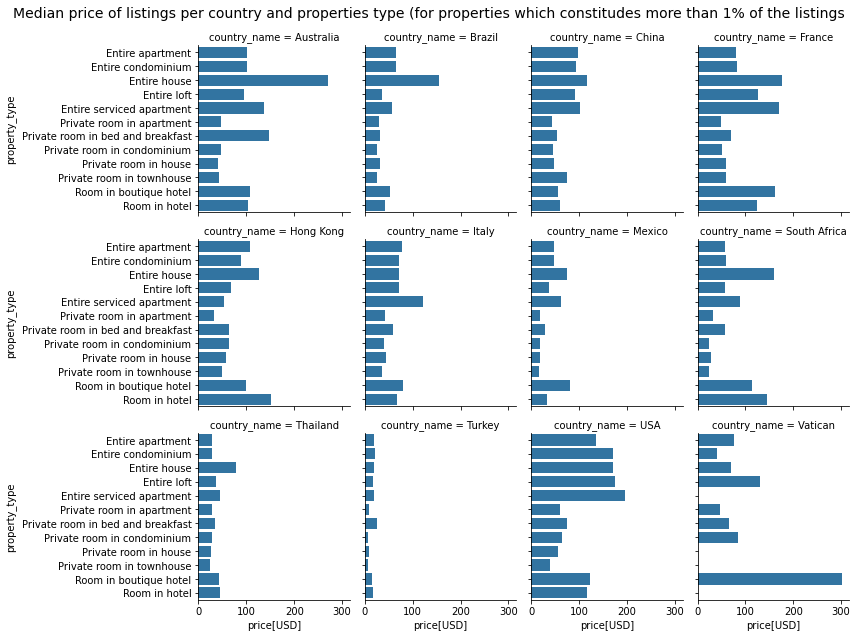

In [215]:
price_per_property_type = df_listings[["country_name","property_type","price[USD]"]].groupby(by=["country_name","property_type"]).median().reset_index()
#Only properties_types which constitutes more than 1% of the listings are presented  
lisings_with_more_1per_property = lisings_per_property_perc[lisings_per_property_perc["num_of_listings"]>1].reset_index()
price_per_property_type = price_per_property_type[price_per_property_type["property_type"].isin(lisings_with_more_1per_property["property_type"].values)]

price_per_property_type_facegrid = sns.FacetGrid(price_per_property_type, col="country_name", col_wrap=4)
price_per_property_type_and_countries = price_per_property_type_facegrid.map(sns.barplot,"price[USD]",'property_type', order=price_per_property_type[price_per_property_type["country_name"]=="Australia"]["property_type"])# Australia to include all categories
price_per_property_type_facegrid.fig.subplots_adjust(top=0.92) # adjust the figure title
price_per_property_type_facegrid.fig.suptitle("Median price of listings per country and properties type (for properties which constitudes more than 1% of the listings", fontsize=14)

**Correlation Evaluation**

In [216]:
df_listings[["review_scores_rating" ,"review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","price[USD]","reviews_count"]].corr()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price[USD],reviews_count
review_scores_rating,1.000000,0.785838,0.740594,0.661642,0.709482,0.540717,0.782864,0.015677,0.066085
review_scores_accuracy,0.785838,1.000000,0.647809,0.655795,0.682926,0.532866,0.717447,0.002462,0.093334
review_scores_cleanliness,0.740594,0.647809,1.000000,0.525337,0.540806,0.430433,0.654149,0.013004,0.091638
review_scores_checkin,0.661642,0.655795,0.525337,1.000000,0.736436,0.519118,0.595167,0.002453,0.087035
review_scores_communication,0.709482,0.682926,0.540806,0.736436,1.000000,0.520654,0.634834,-0.000802,0.082945
review_scores_location,0.540717,0.532866,0.430433,0.519118,0.520654,1.000000,0.532644,0.027234,0.079429
review_scores_value,0.782864,0.717447,0.654149,0.595167,0.634834,0.532644,1.000000,-0.016084,0.073096
price[USD],0.015677,0.002462,0.013004,0.002453,-0.000802,0.027234,-0.016084,1.000000,-0.014677
reviews_count,0.066085,0.093334,0.091638,0.087035,0.082945,0.079429,0.073096,-0.014677,1.000000


In [217]:
#descriptive statistics described under Price EDA

price_per_country

price[USD]                                                     \
                  count        mean         std      min      25%      50%   
country_name                                                                 
Australia       33630.0  150.014482  319.360273   3.3785  50.0018  81.0840   
Brazil          26615.0  137.230494  992.166961   0.0000  29.0136  51.7440   
China            4191.0  108.986970  284.649277   9.6265  37.0250  56.2780   
France          64690.0  113.763714  215.698827   0.0000  59.3481  80.4720   
Hong Kong        2896.0   96.955271  249.923641   0.1274  31.2130  50.9600   
Italy           27547.0  105.826143  343.772154   0.0000  45.2655  65.3835   
Mexico          20065.0   55.279071  258.393915   0.0000  18.8071  31.7941   
South Africa    19086.0  139.978004  357.534122   7.1004  37.8300  62.2158   
Thailand        19361.0   56.736990  174.168213   0.0000  19.1100  30.0300   
Turkey          24519.0   30.515542  190.145500   0.0000   8.5950  14.4396   
USA             37012.0  142.842240  275.740987   0.0000  60.0000  99.0000   
Vatican           100.0   78.631203   51.754637  19.1121  47.2773  69.4071   

                                      
                    75%          max  
country_name                          
Australia     147.97830   19333.8041  
Brazil        101.64000  115539.9168  
China         100.63395   12390.7865  
France        120.70800   12070.8000  
Hong Kong     101.79260    8493.2484  
Italy          99.58410   10633.3689  
Mexico         54.06440   24001.9000  
South Africa  128.04000   10476.0000  
Thailand       51.87000    8194.8321  
Turkey         25.72770   10287.1836  
USA           151.00000   10000.0000  
Vatican        91.03395     301.7700

# **Data Analysis**

 **Price differences per countries analysis**

Checking if ANOVA analysis can be used based on visualizing the histogram and varience test- Levene’s test
Levene's tests the null hypothesis that all input samples are from populations with equal variances.


levene's test results:
                  W           pval  equal_var
levene  119.277128  5.124173e-274      False


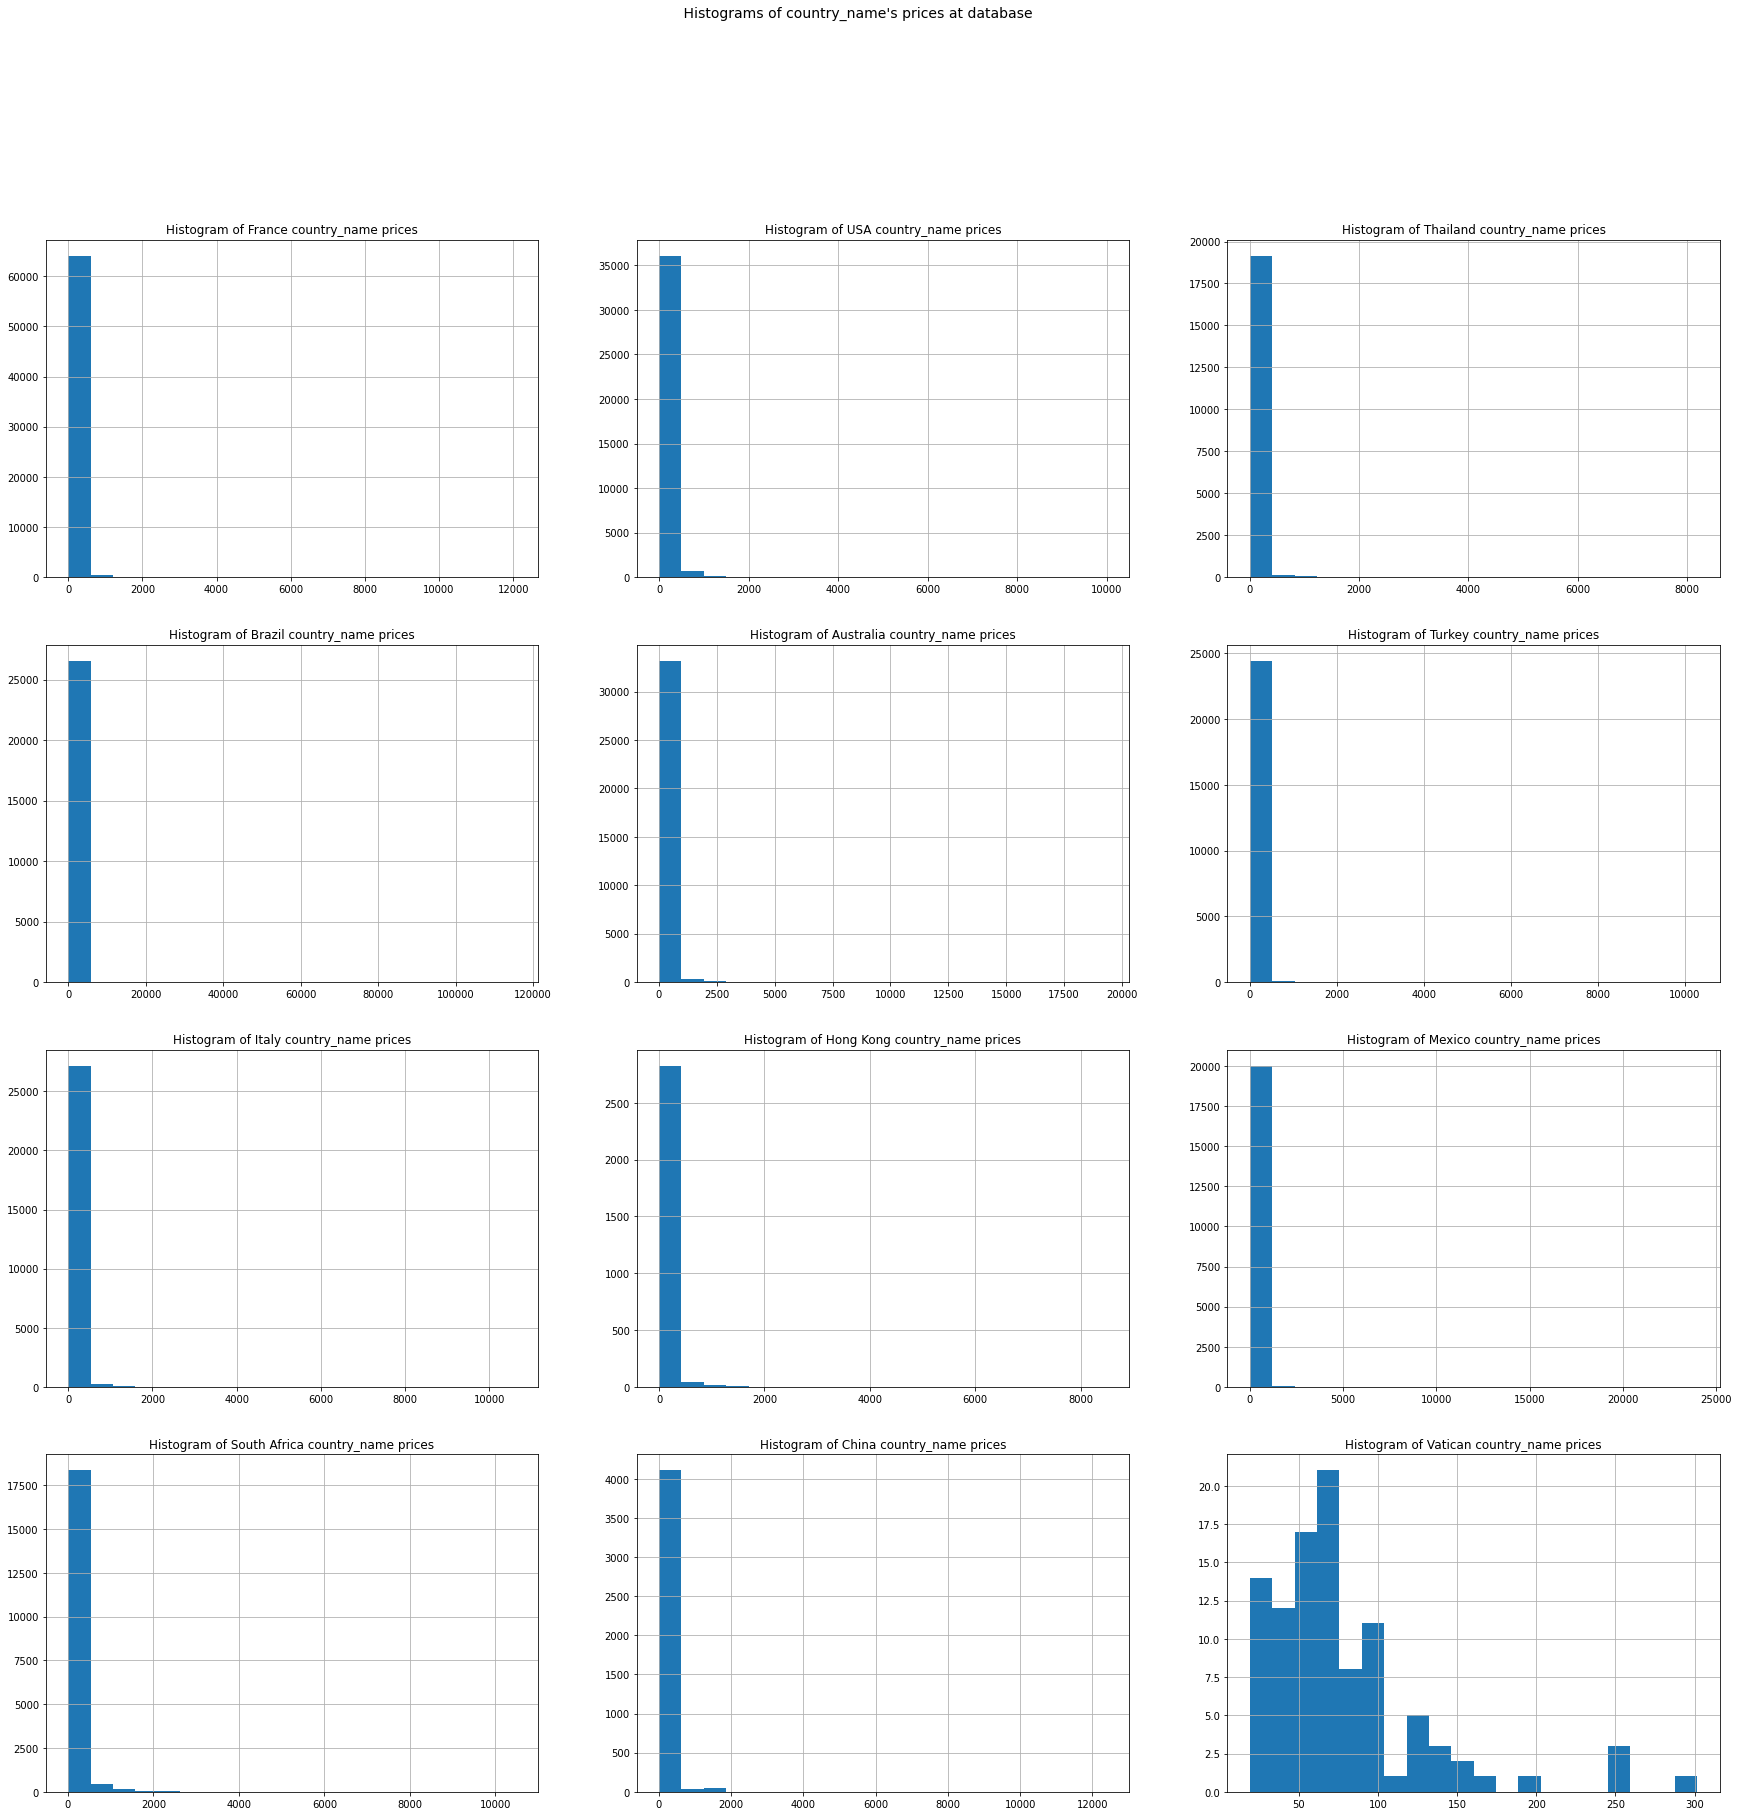

In [218]:
df_price_per_country = checking_ANOVA_per_countries(df_listings,"country_name")

In [219]:
testing_for_outliers(df_price_per_country)

outliers test results for:France
Number of values above upper bound: 5164
Number of values below lower bound: 0
outliers test results for:USA
Number of values above upper bound: 2727
Number of values below lower bound: 0
outliers test results for:Thailand
Number of values above upper bound: 1680
Number of values below lower bound: 0
outliers test results for:Brazil
Number of values above upper bound: 2770
Number of values below lower bound: 0
outliers test results for:Australia
Number of values above upper bound: 3328
Number of values below lower bound: 0
outliers test results for:Turkey
Number of values above upper bound: 1917
Number of values below lower bound: 0
outliers test results for:Italy
Number of values above upper bound: 2356
Number of values below lower bound: 0
outliers test results for:Hong Kong
Number of values above upper bound: 194
Number of values below lower bound: 0
outliers test results for:Mexico
Number of values above upper bound: 1497
Number of values below lowe

In [220]:
mood_median_test_results_between_categories_values(df_price_per_country)

Median's between groups are not equal per Mood's median test (p<0.05):
 [['Australia', 'Brazil'], ['Australia', 'China'], ['Australia', 'France'], ['Australia', 'Hong Kong'], ['Australia', 'Italy'], ['Australia', 'Mexico'], ['Australia', 'South Africa'], ['Australia', 'Thailand'], ['Australia', 'Turkey'], ['Australia', 'USA'], ['Australia', 'Vatican'], ['Brazil', 'China'], ['Brazil', 'France'], ['Brazil', 'Hong Kong'], ['Brazil', 'Italy'], ['Brazil', 'Mexico'], ['Brazil', 'South Africa'], ['Brazil', 'Thailand'], ['Brazil', 'Turkey'], ['Brazil', 'USA'], ['Brazil', 'Vatican'], ['China', 'France'], ['China', 'Hong Kong'], ['China', 'Italy'], ['China', 'Mexico'], ['China', 'South Africa'], ['China', 'Thailand'], ['China', 'Turkey'], ['China', 'USA'], ['China', 'Vatican'], ['France', 'Hong Kong'], ['France', 'Italy'], ['France', 'Mexico'], ['France', 'South Africa'], ['France', 'Thailand'], ['France', 'Turkey'], ['France', 'USA'], ['France', 'Vatican'], ['Hong Kong', 'Italy'], ['Hong Kong',

 **Price differences per countries and accommodates analysis**




Results for country:France
levene's test results:
                  W           pval  equal_var
levene  101.935659  3.123572e-128      False


Results for country:USA
category accommodates not meeting sample size req for the following categories values [0]
levene's test results:
                 W          pval  equal_var
levene  68.163484  3.671469e-71      False


Results for country:Thailand
category accommodates not meeting sample size req for the following categories values [0]
levene's test results:
                W          pval  equal_var
levene  9.269288  7.922986e-09      False


Results for country:Brazil
category accommodates not meeting sample size req for the following categories values [0]
levene's test results:
                W      pval  equal_var
levene  5.494183  0.000046      False


Results for country:Australia
levene's test results:
                 W          pval  equal_var
levene  73.639838  6.138413e-77      False


Results for country:Turkey
category acc

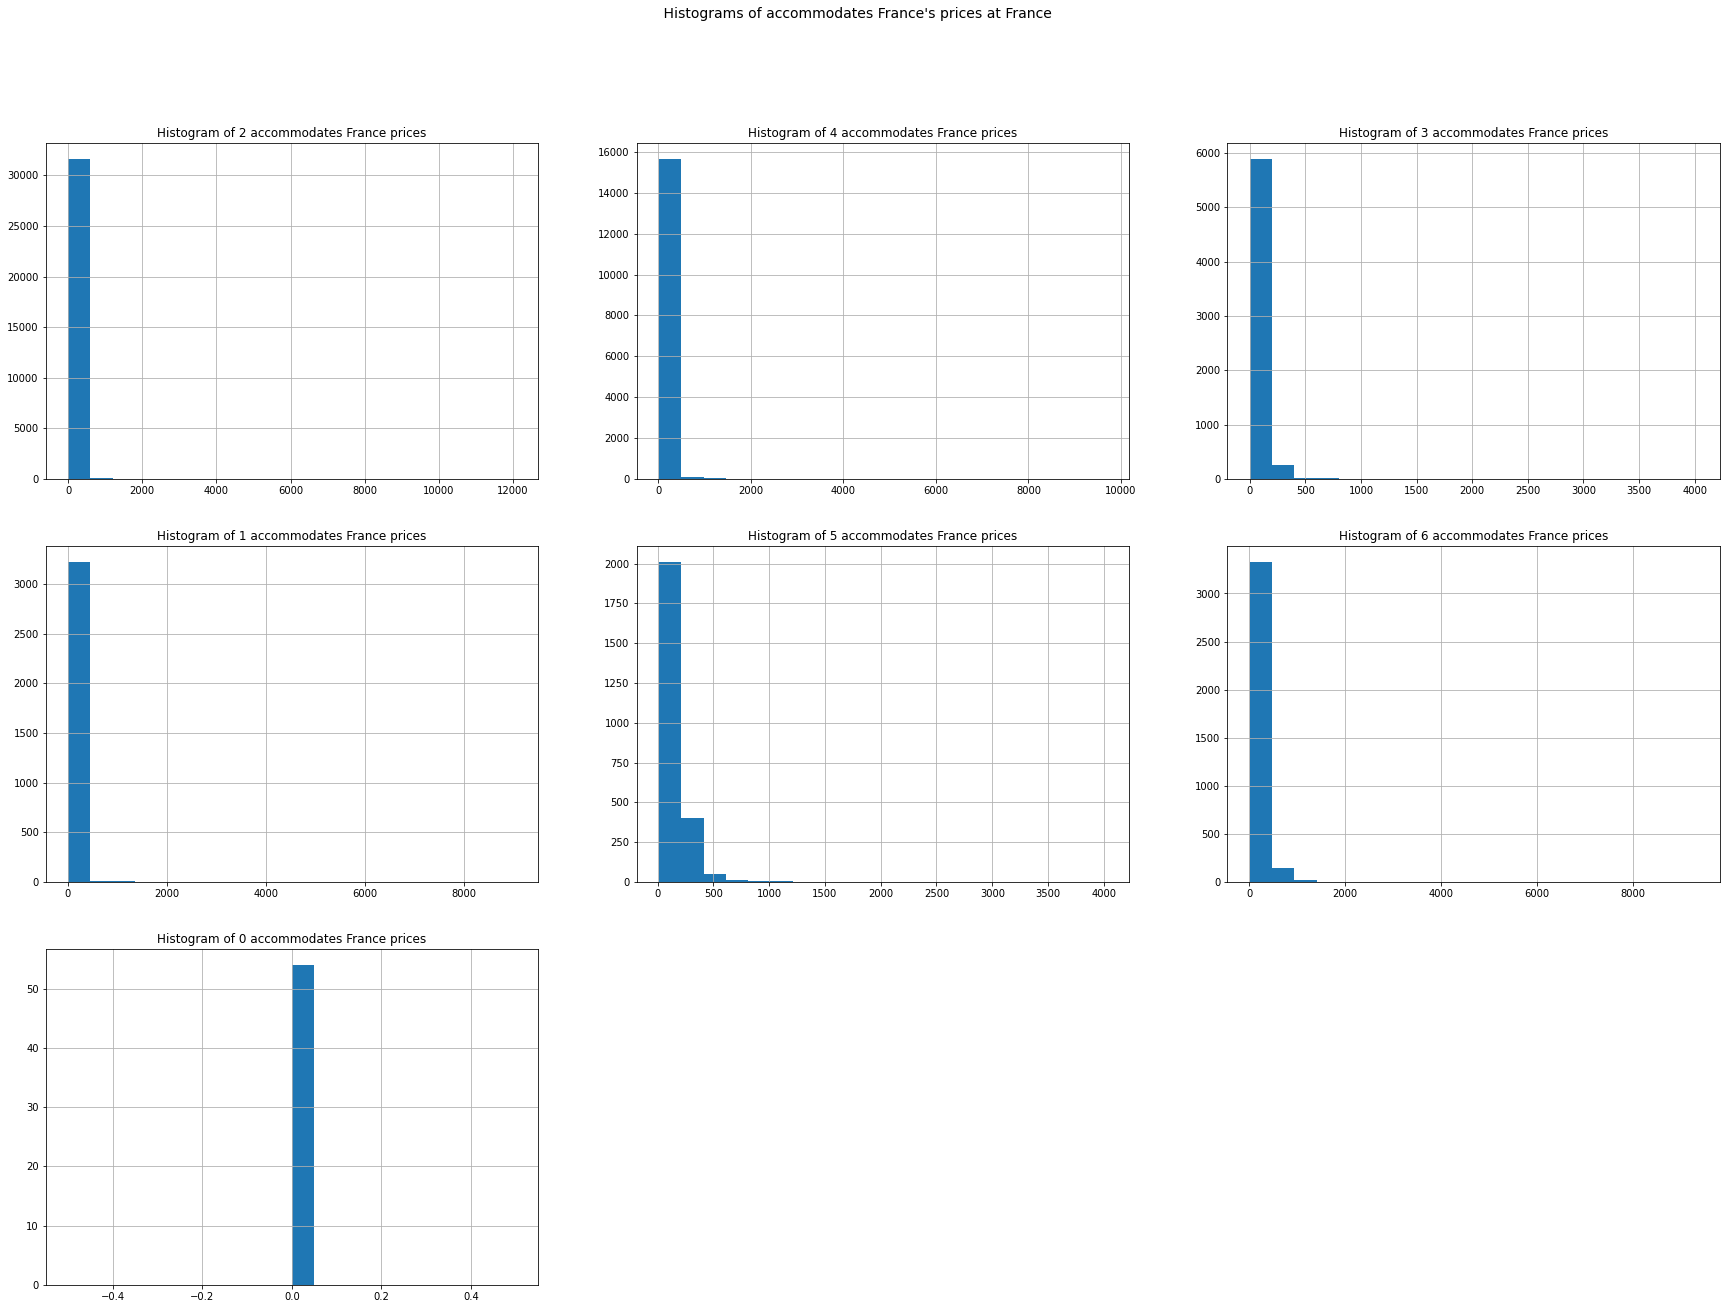

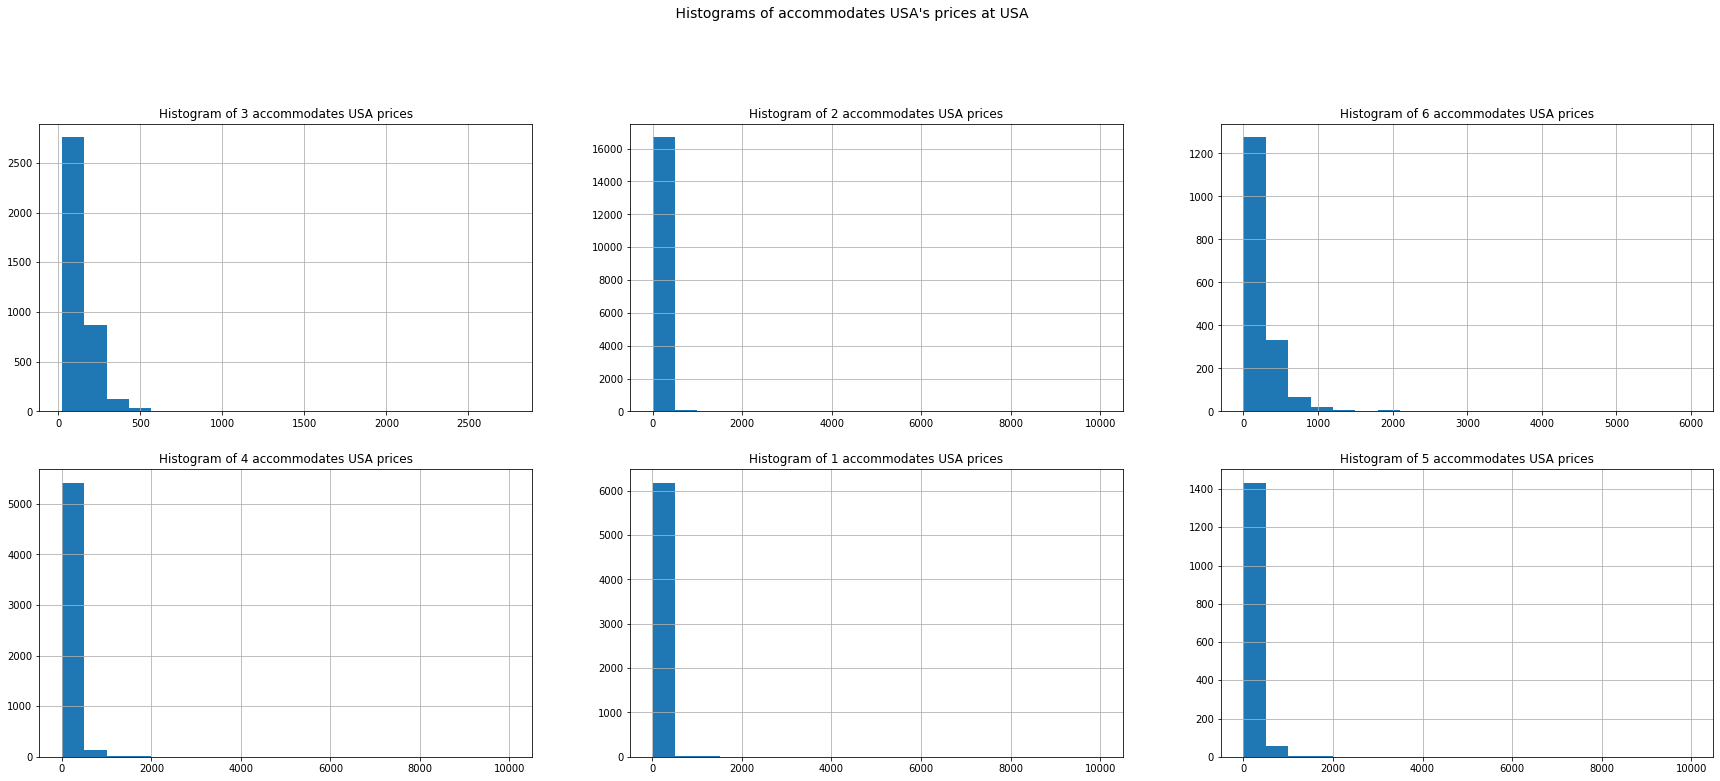

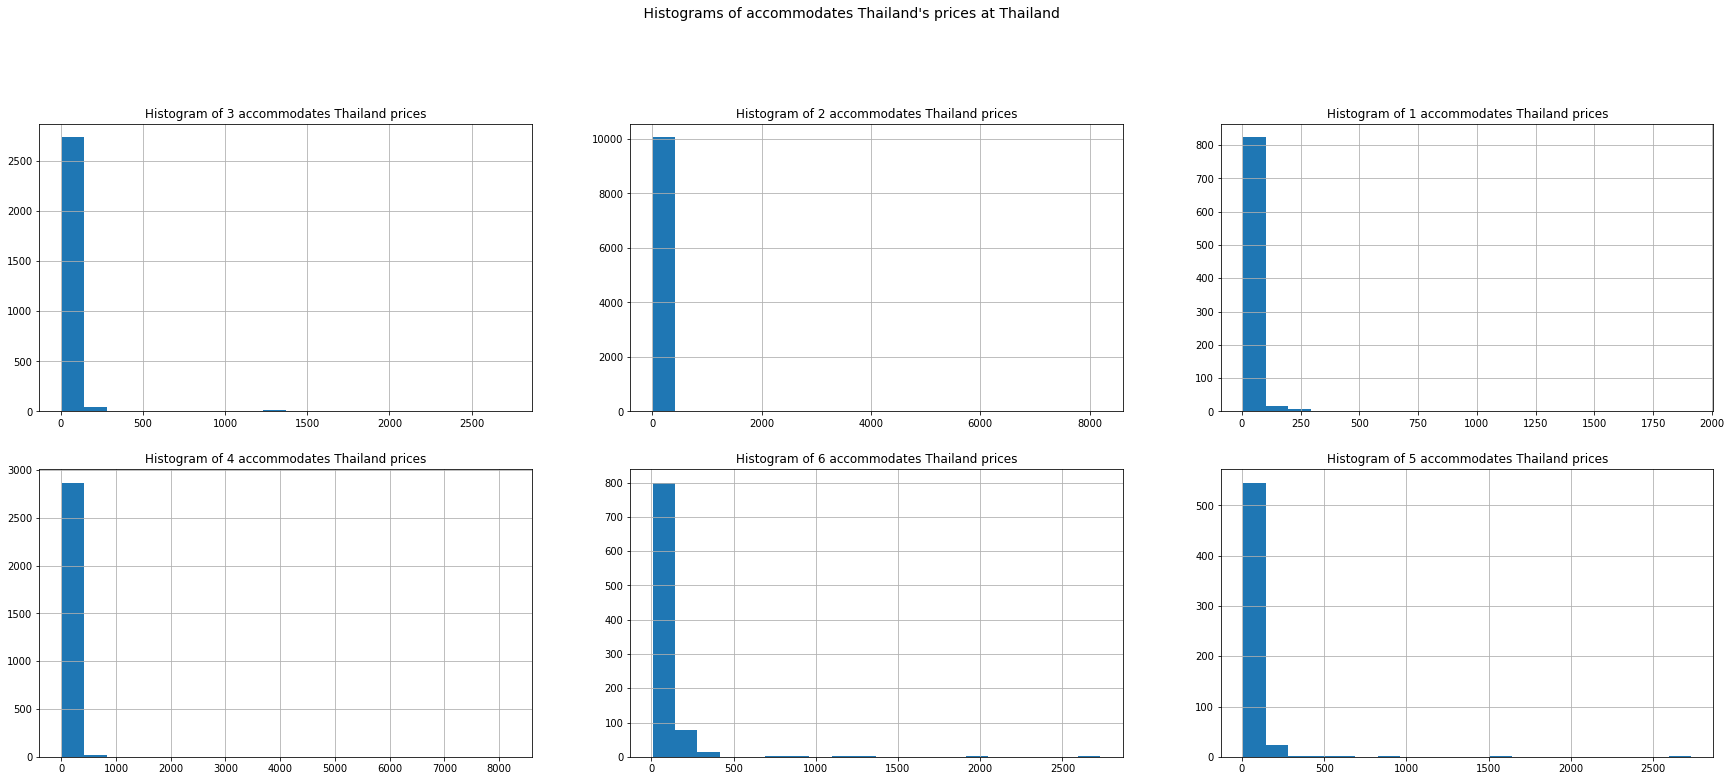

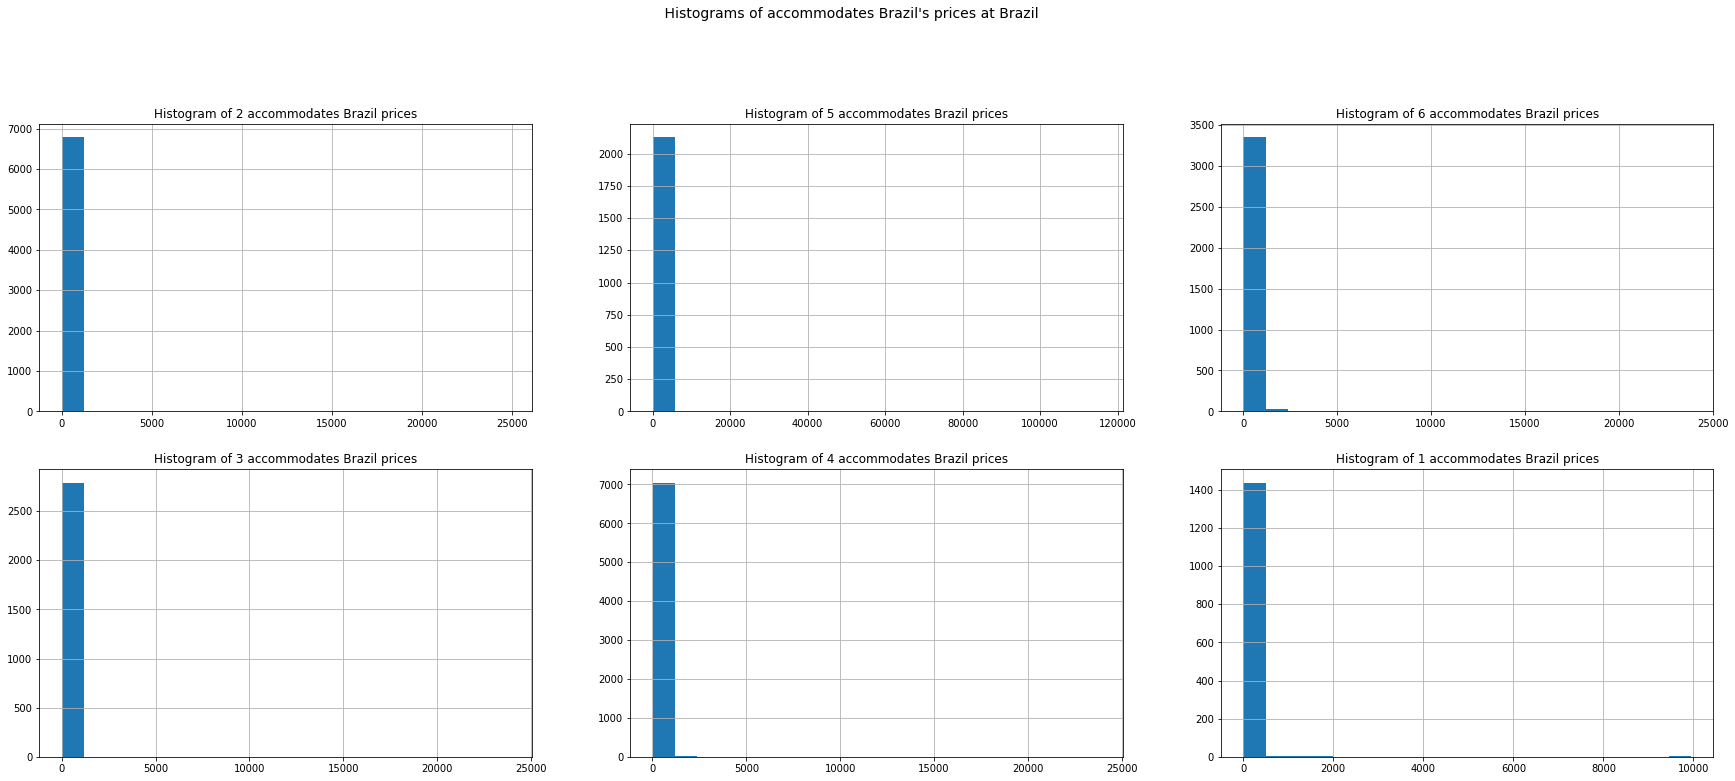

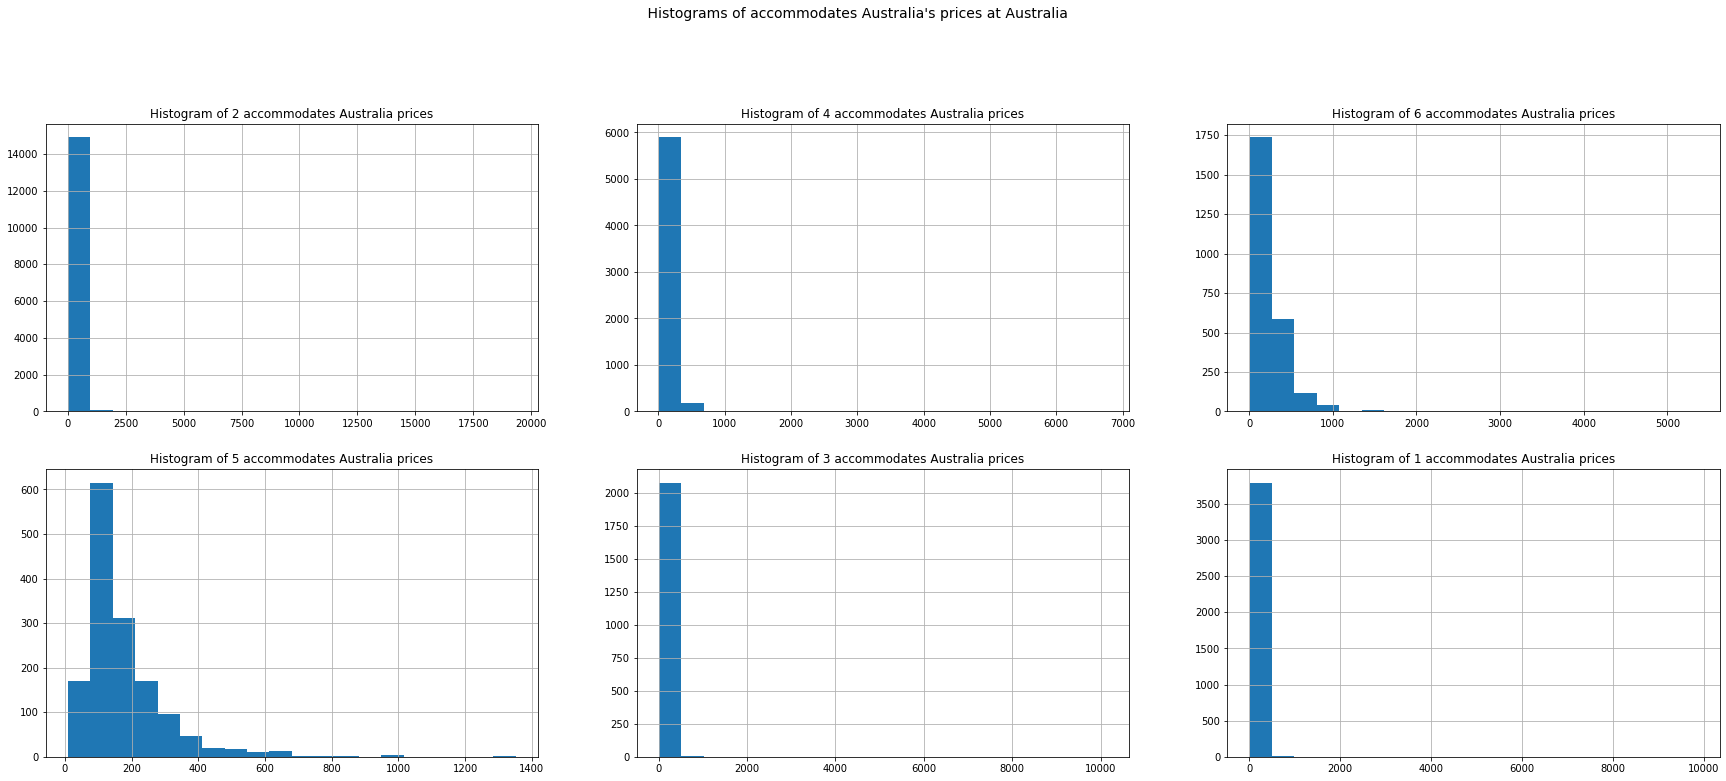

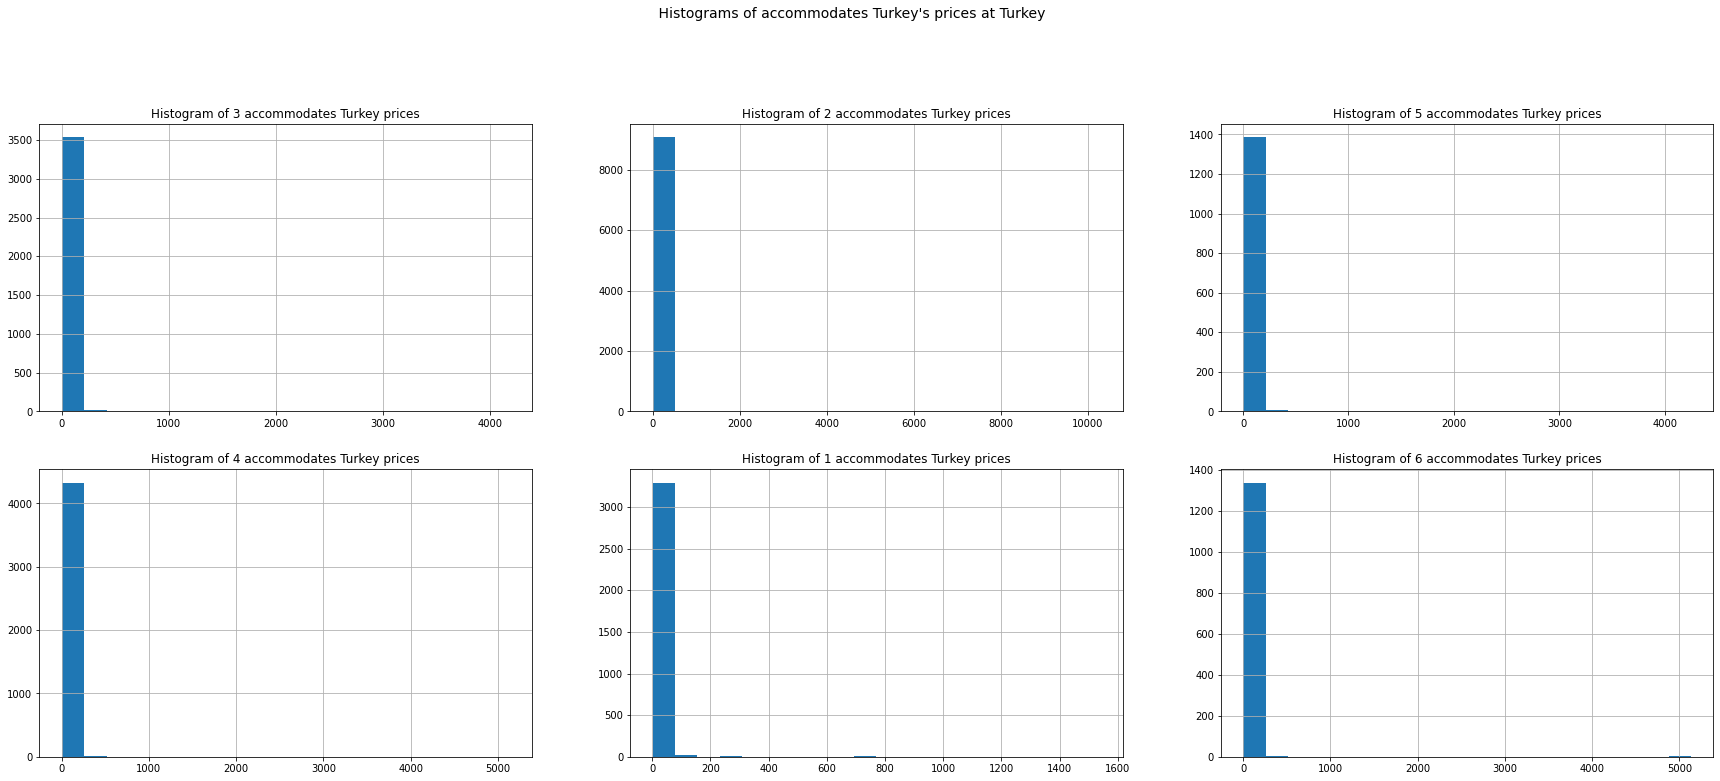

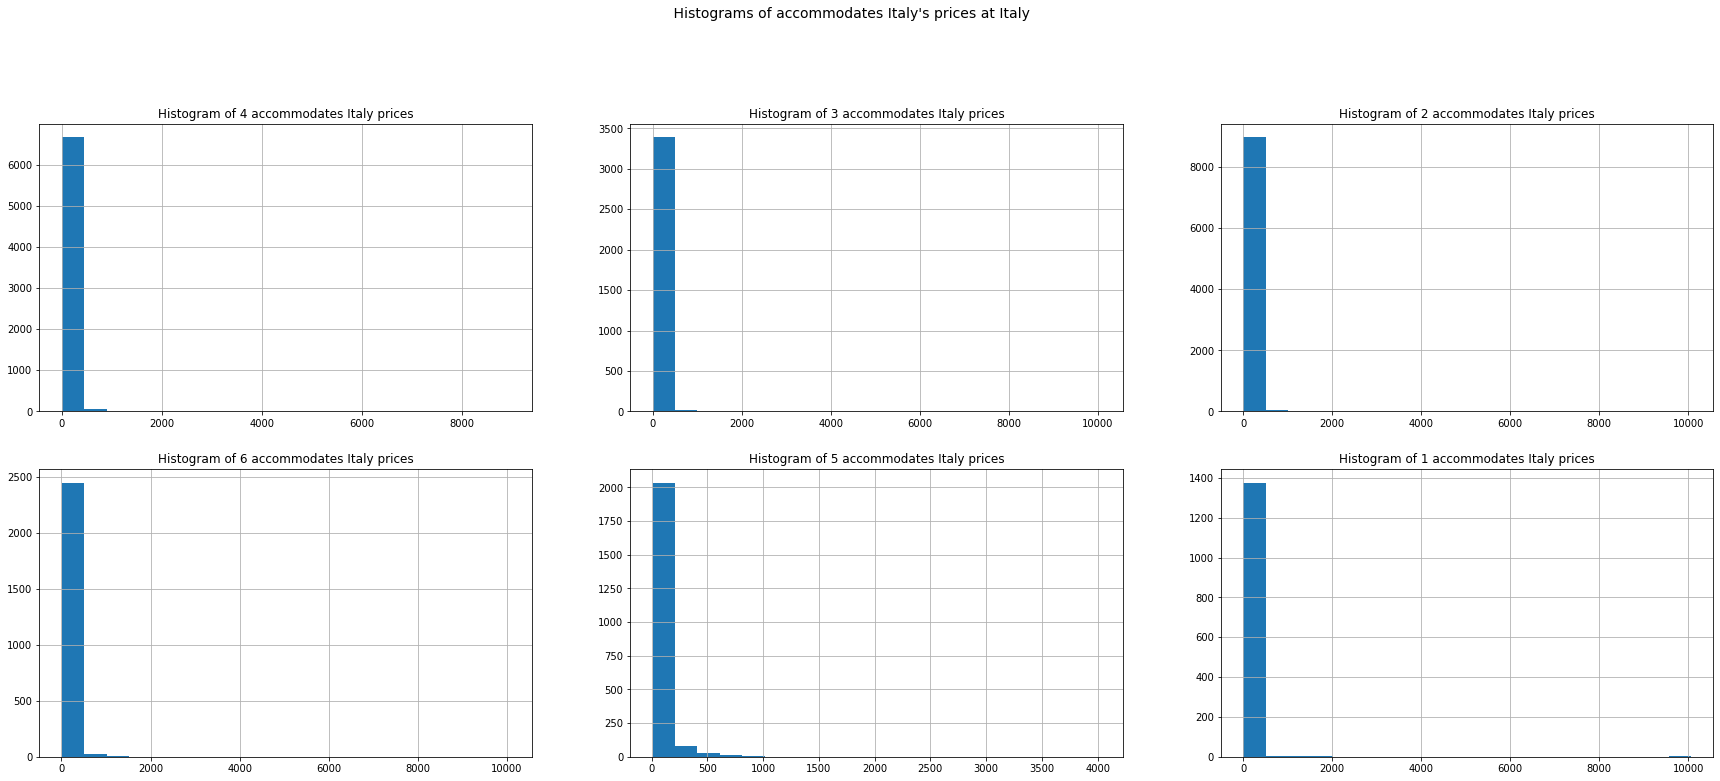

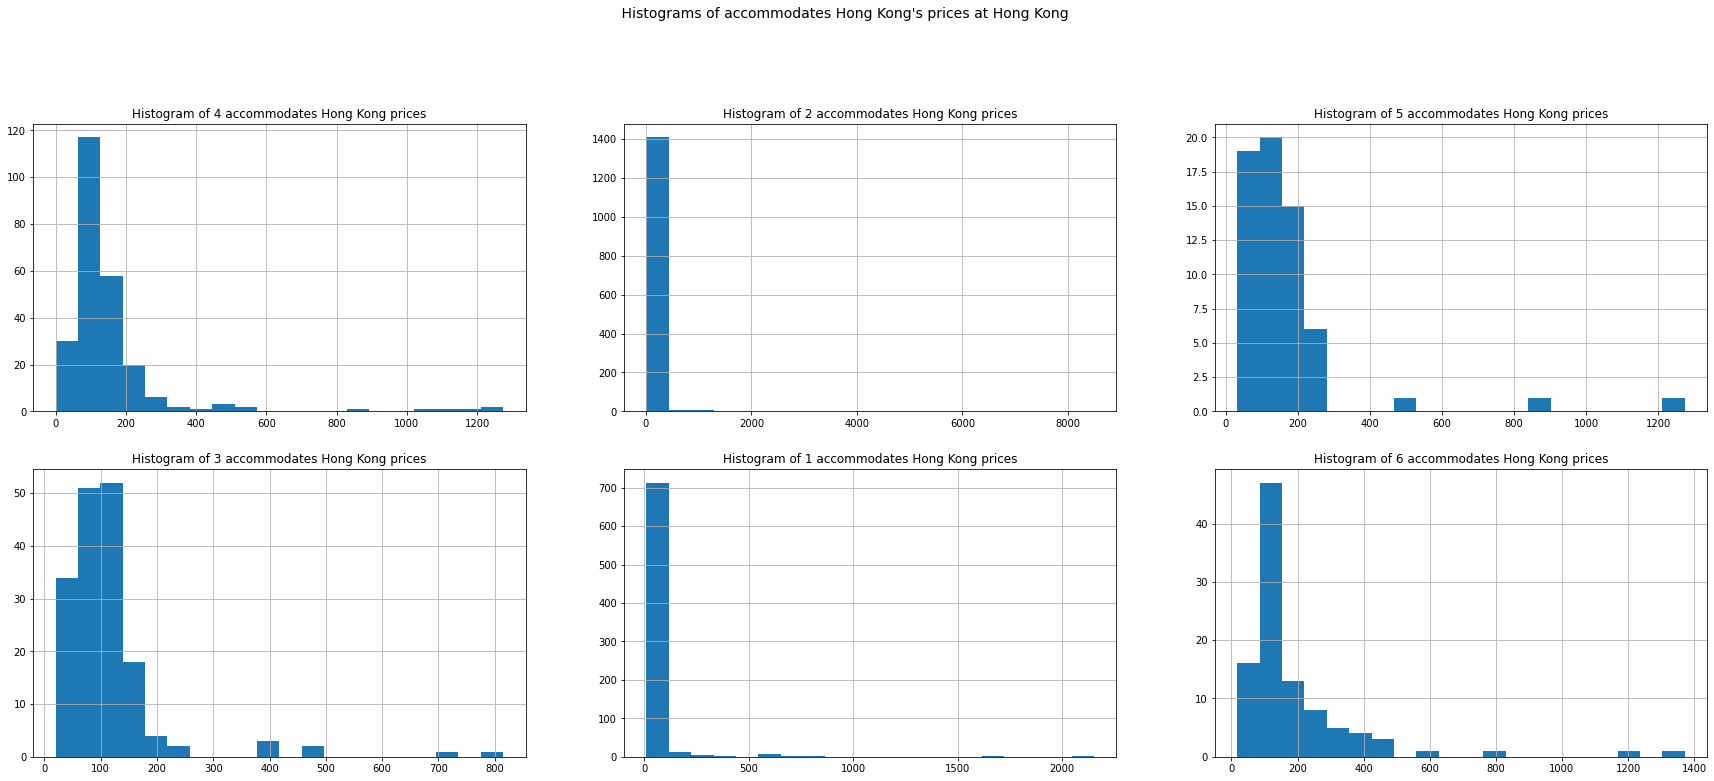

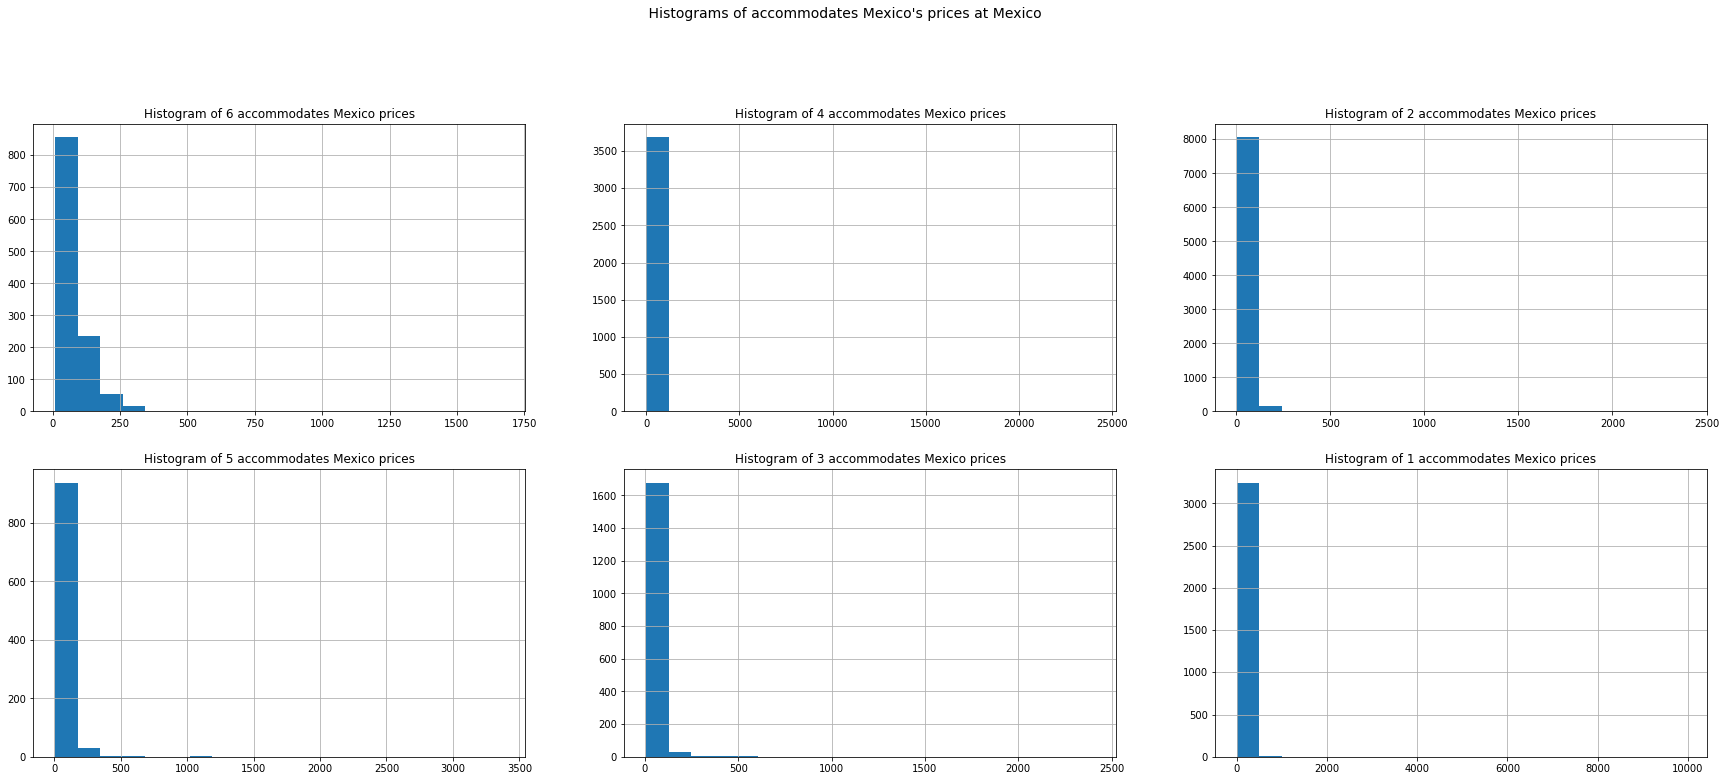

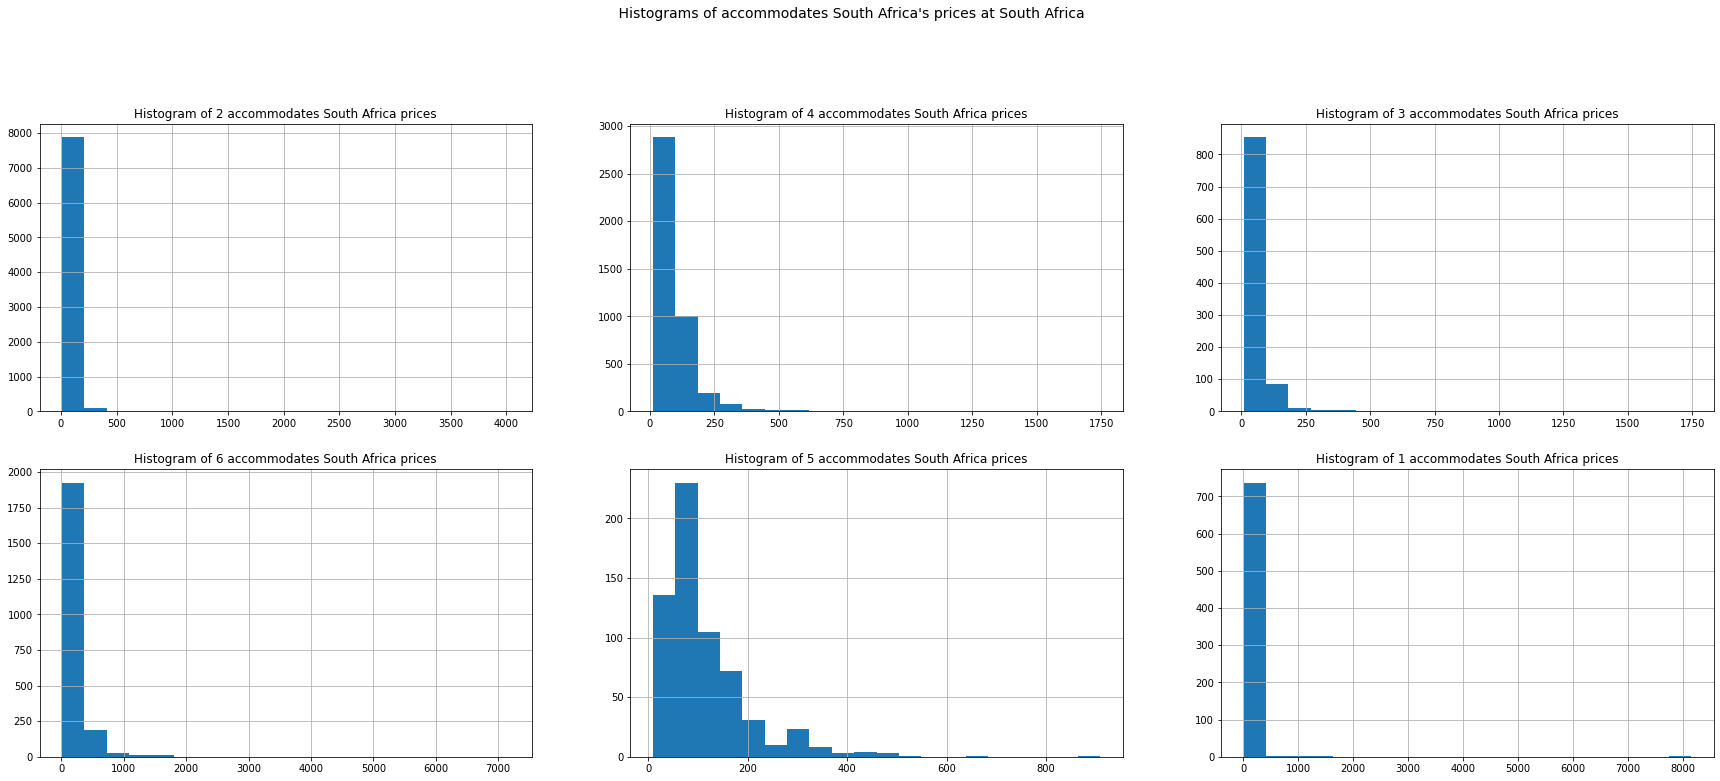

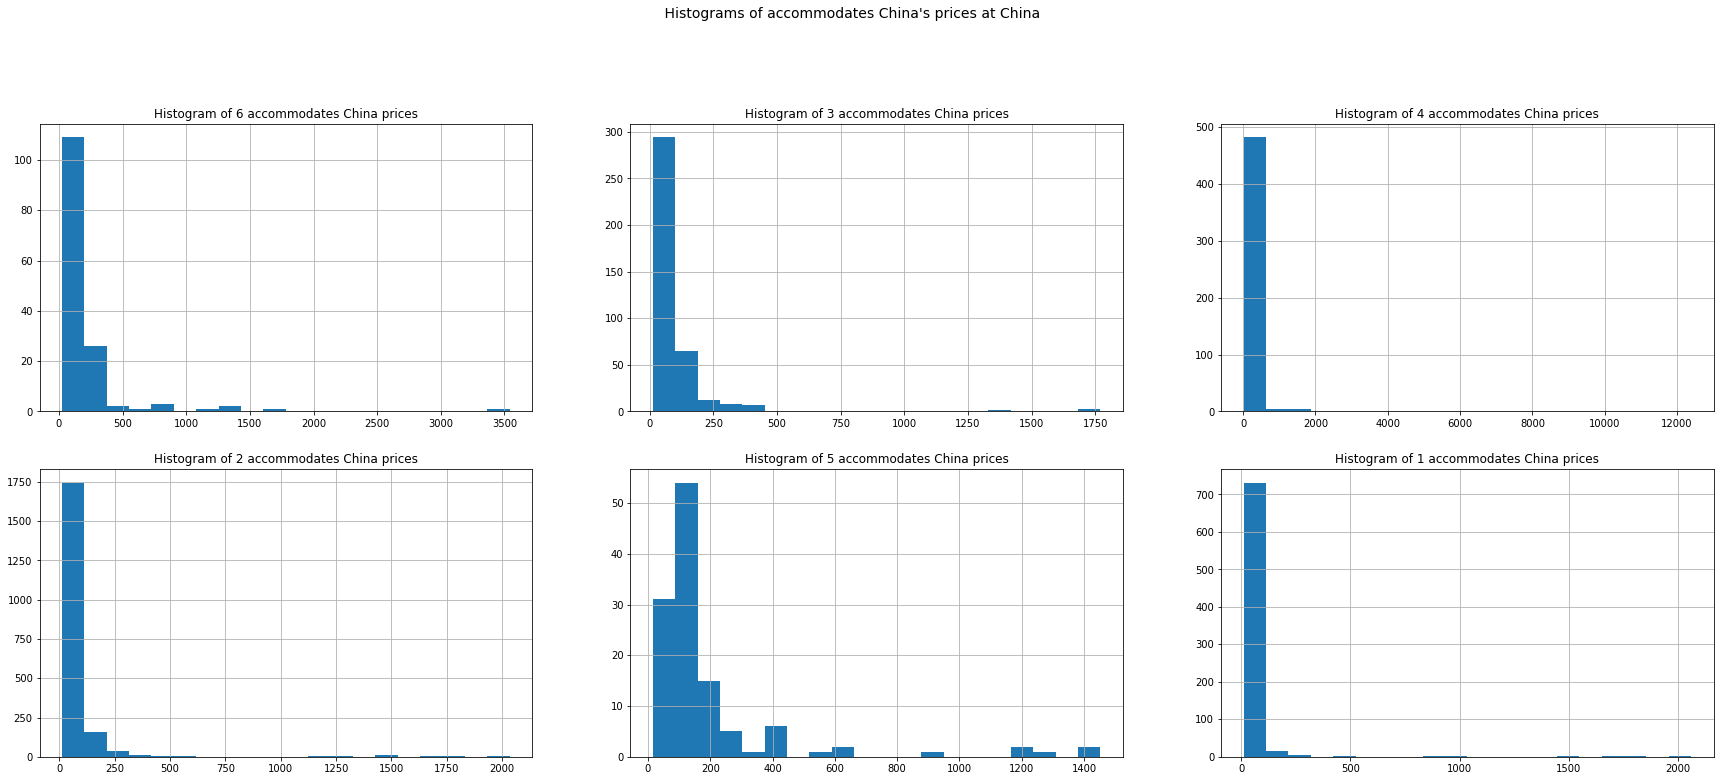

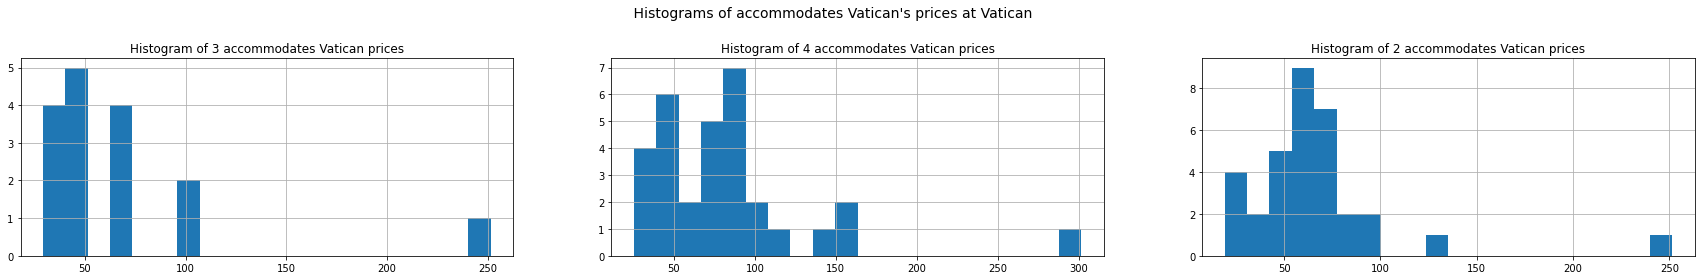

In [221]:
df_price_per_countries_and_accommodates = checking_ANOVA_per_countries_and_categories(df_listings[df_listings["accommodates"]<7],"country_name","accommodates")#less than 7, per the visualization above


In [222]:
testing_for_outliers(df_price_per_countries_and_accommodates)


Outliers test results for:accommodates France
2 group
Number of values above upper bound:1728 ,Number of values below lower bound: 0
4 group
Number of values above upper bound:1144 ,Number of values below lower bound: 0
3 group
Number of values above upper bound:375 ,Number of values below lower bound: 0
1 group
Number of values above upper bound:183 ,Number of values below lower bound: 0
5 group
Number of values above upper bound:158 ,Number of values below lower bound: 0
6 group
Number of values above upper bound:213 ,Number of values below lower bound: 0
0 group
Number of values above upper bound:54 ,Number of values below lower bound: 54

Outliers test results for:accommodates USA
3 group
Number of values above upper bound:199 ,Number of values below lower bound: 0
2 group
Number of values above upper bound:881 ,Number of values below lower bound: 0
6 group
Number of values above upper bound:123 ,Number of values below lower bound: 0
4 group
Number of values above upper bound:354 

In [223]:
mood_median_test_results_between_categories_values(df_price_per_countries_and_accommodates)

accommodates France
Median's between groups are not equal per Mood's median test (p<0.05):
 [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
accommodates USA
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
accommodates Thailand
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
accommodates Brazil
Median's between groups are not equal per Mood's median test (p<0.05)

 **Price differences per countries and bedrooms analysis**




Results for country:France
levene's test results:
                  W           pval  equal_var
levene  325.965324  1.130664e-209      False


Results for country:USA
levene's test results:
                 W           pval  equal_var
levene  157.79809  1.467901e-101      False


Results for country:Thailand
levene's test results:
                 W          pval  equal_var
levene  46.821394  3.994235e-30      False


Results for country:Brazil
levene's test results:
                 W          pval  equal_var
levene  23.026377  7.046989e-15      False


Results for country:Australia
levene's test results:
                  W           pval  equal_var
levene  447.603663  1.152692e-284      False


Results for country:Turkey
levene's test results:
                W          pval  equal_var
levene  16.93633  5.525363e-11      False


Results for country:Italy
levene's test results:
                 W          pval  equal_var
levene  25.572592  1.638537e-16      False


Results for coun

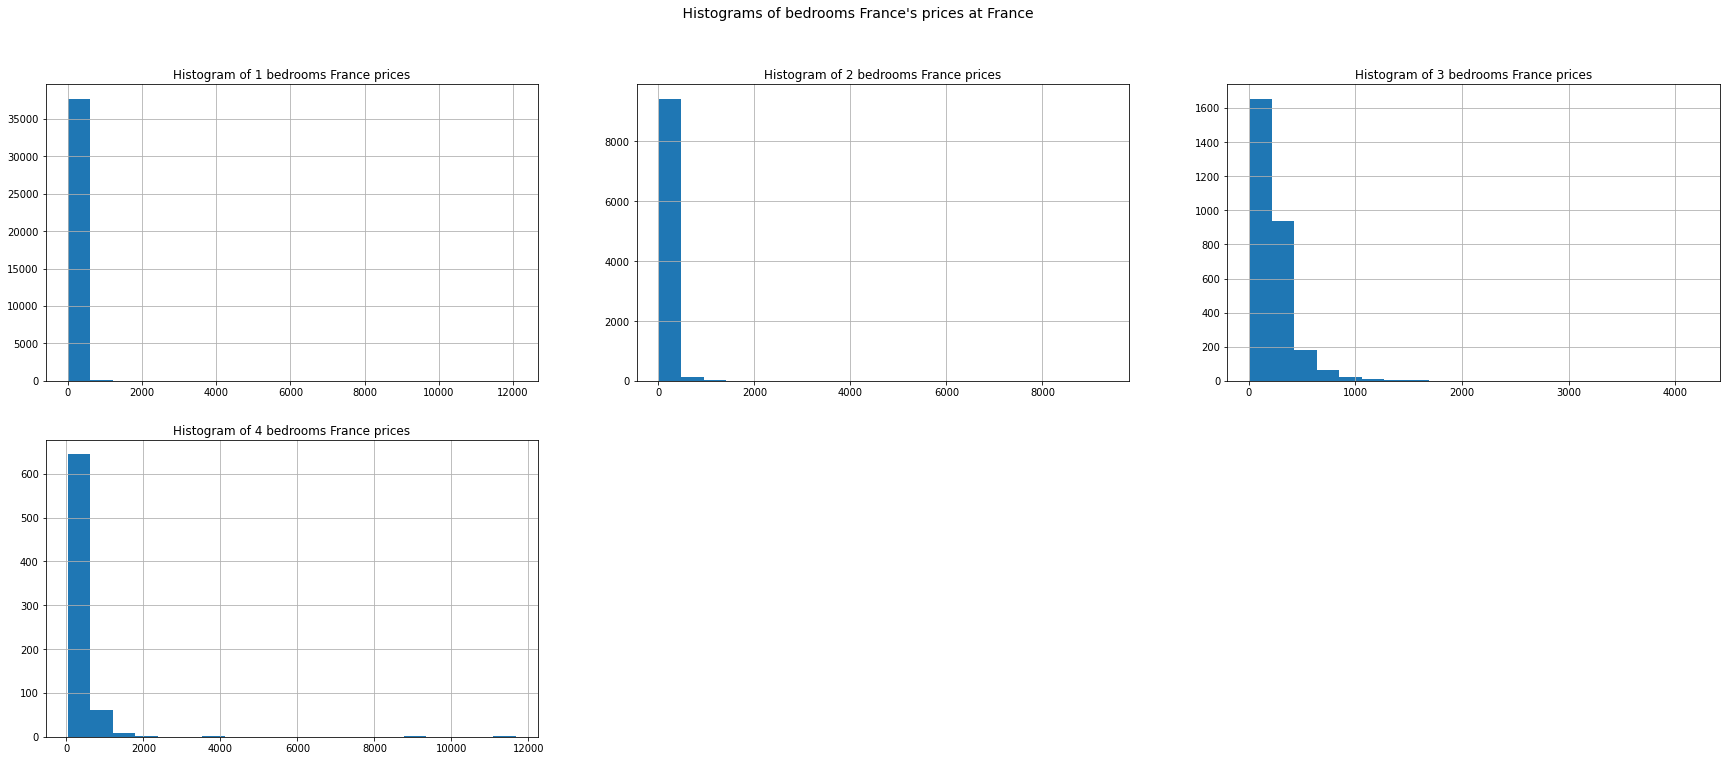

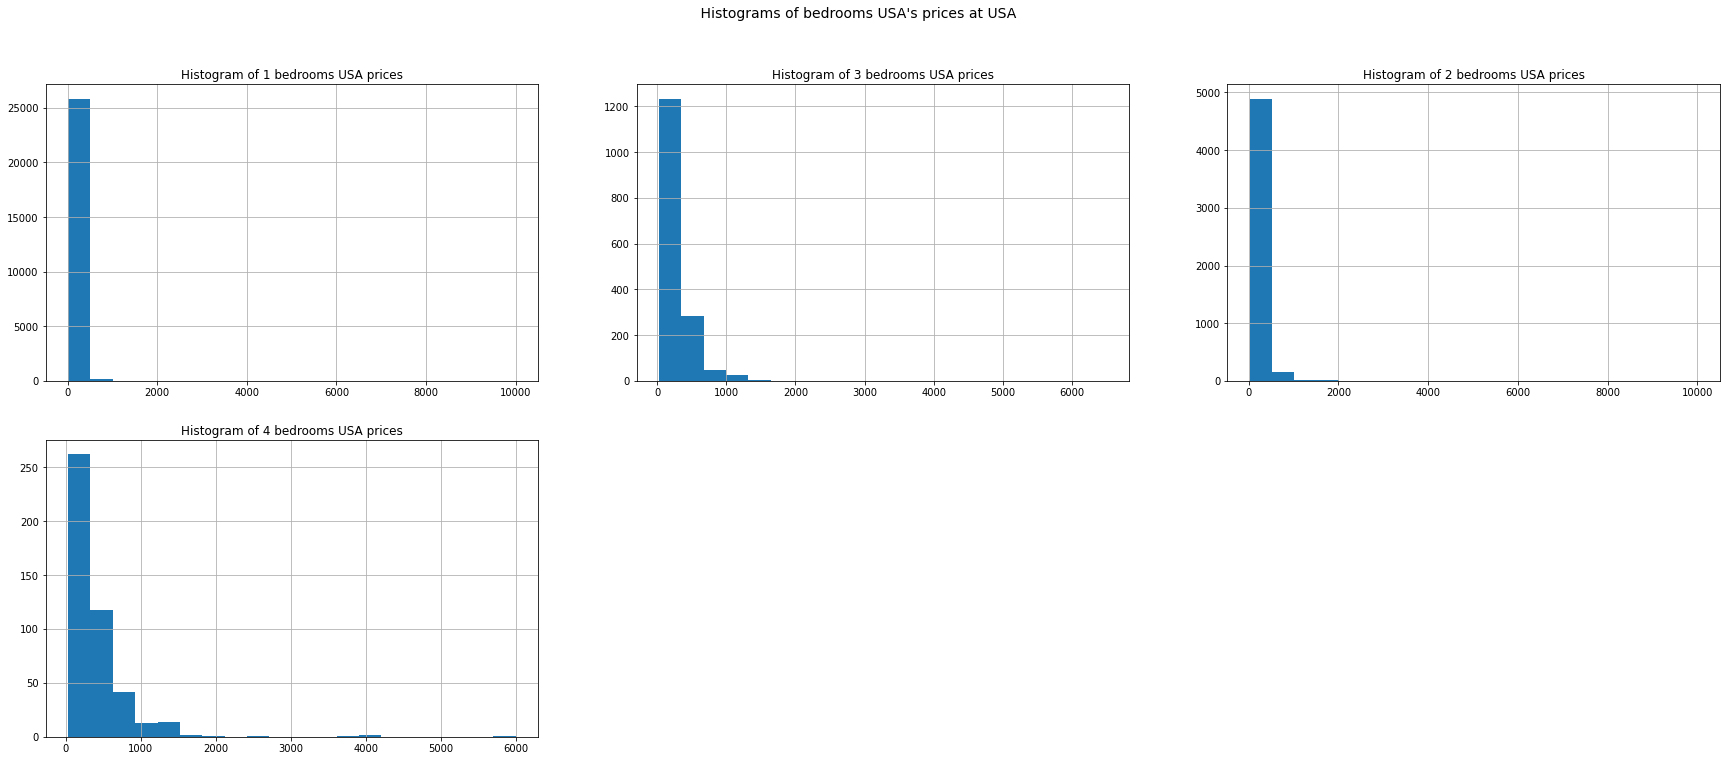

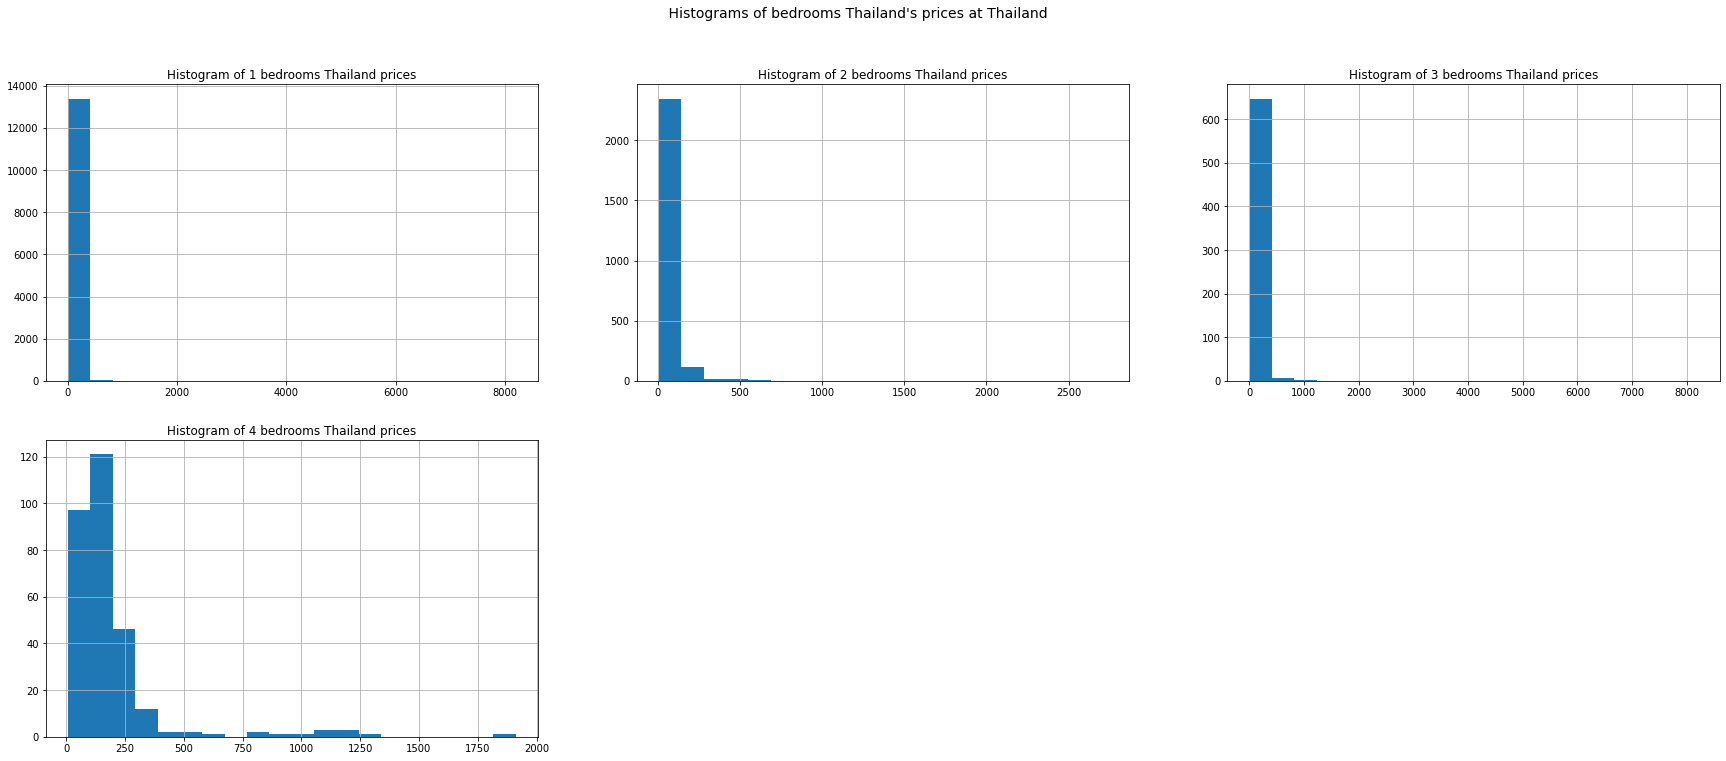

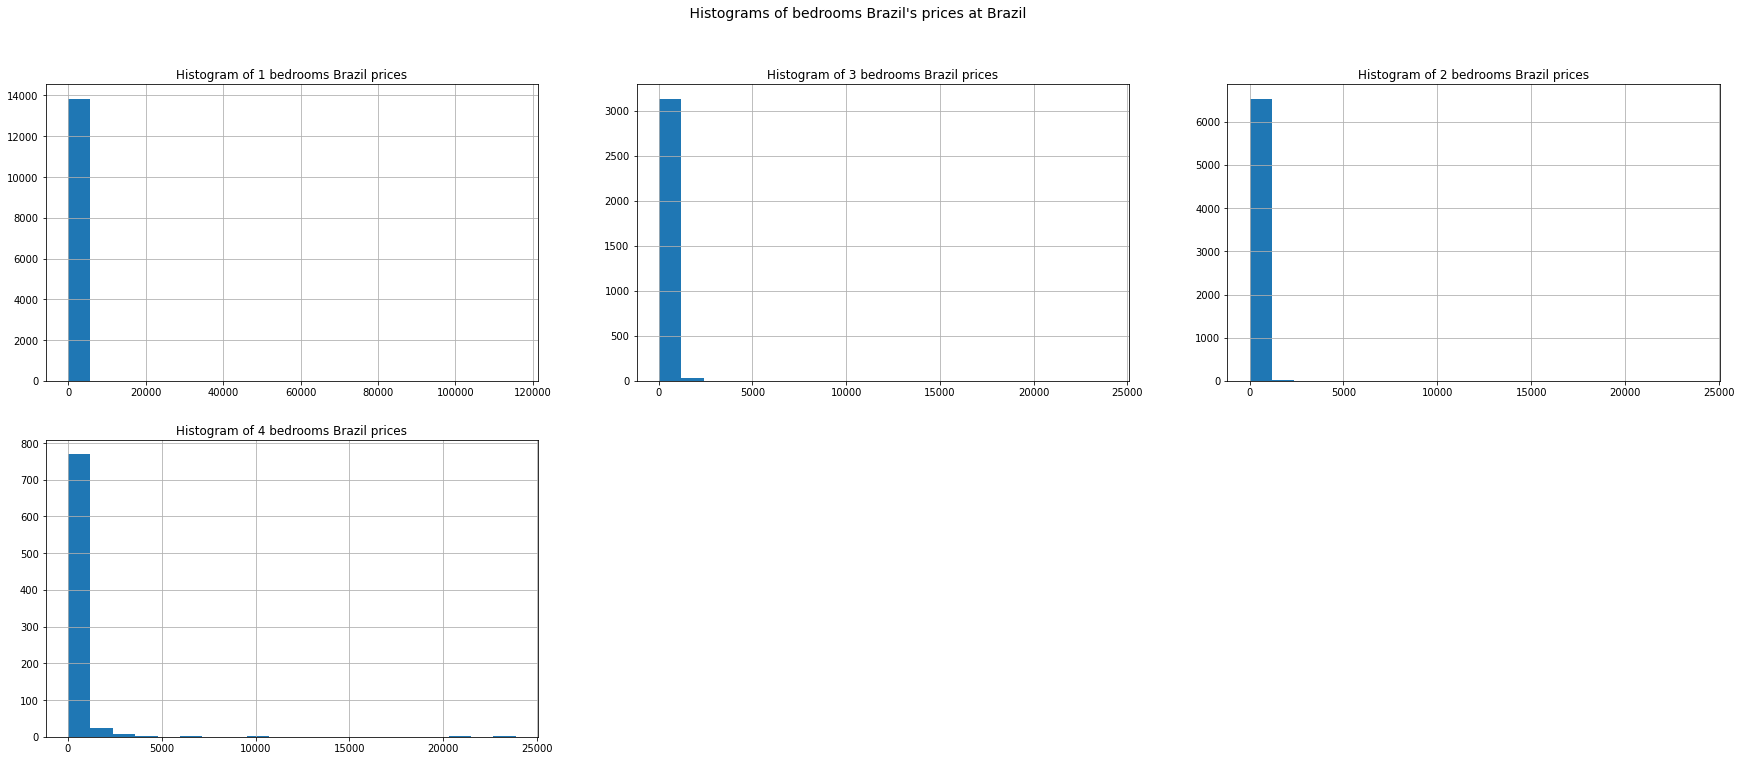

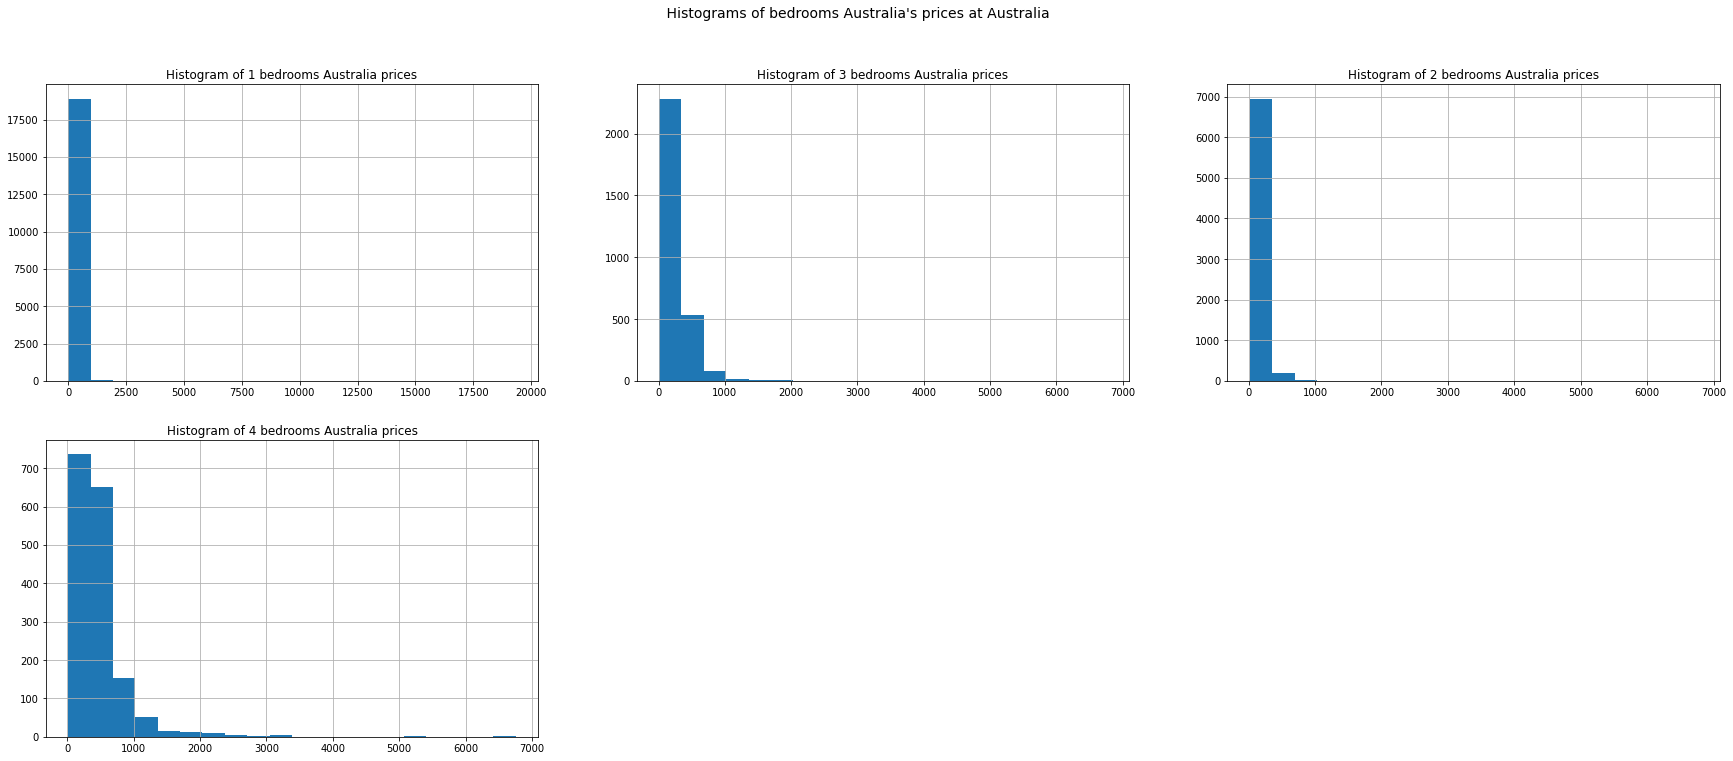

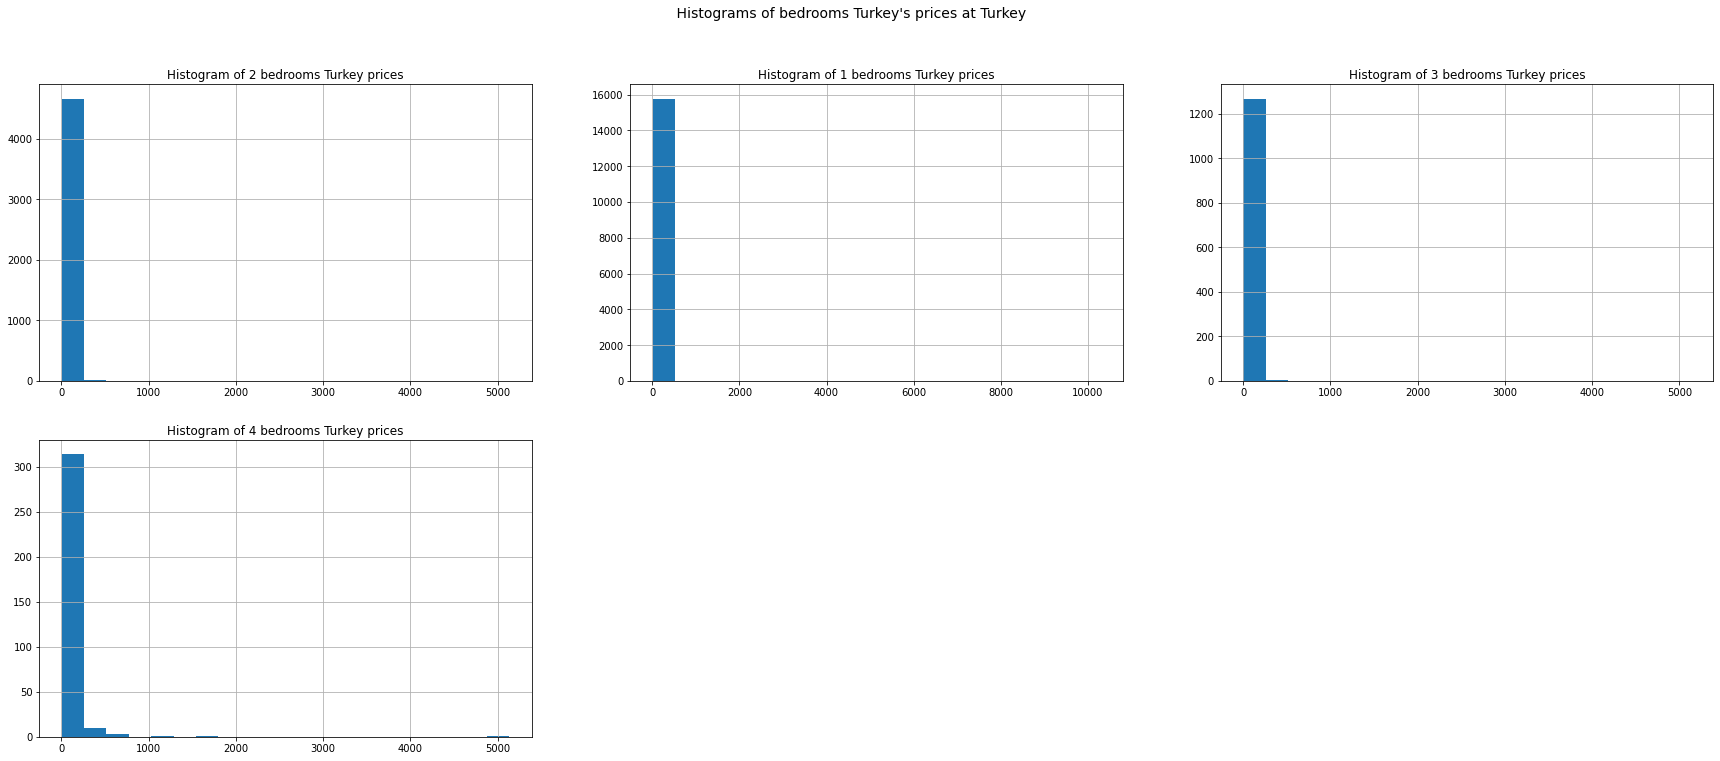

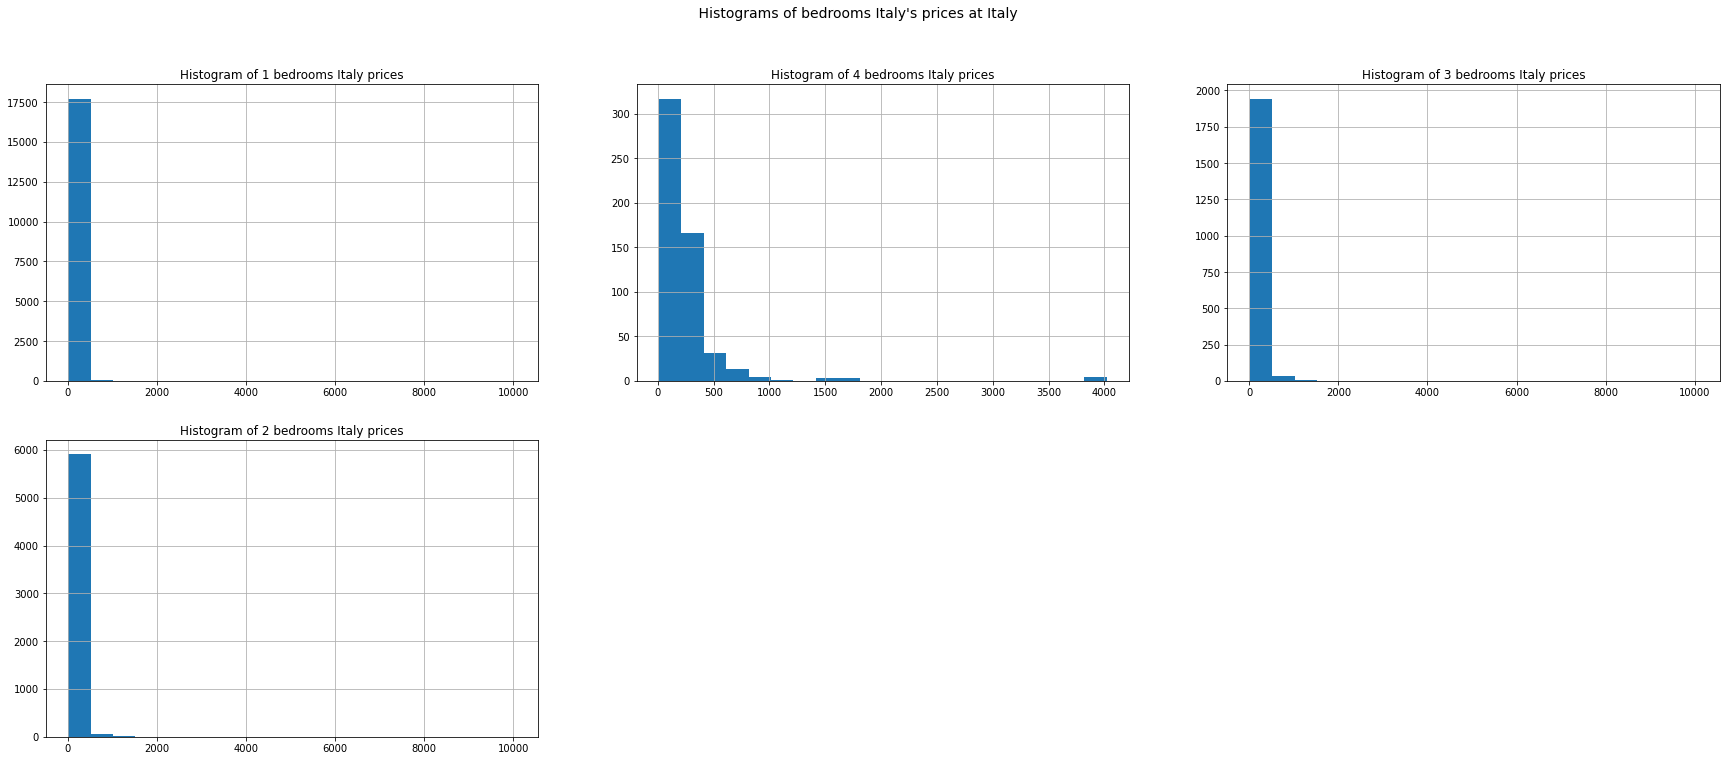

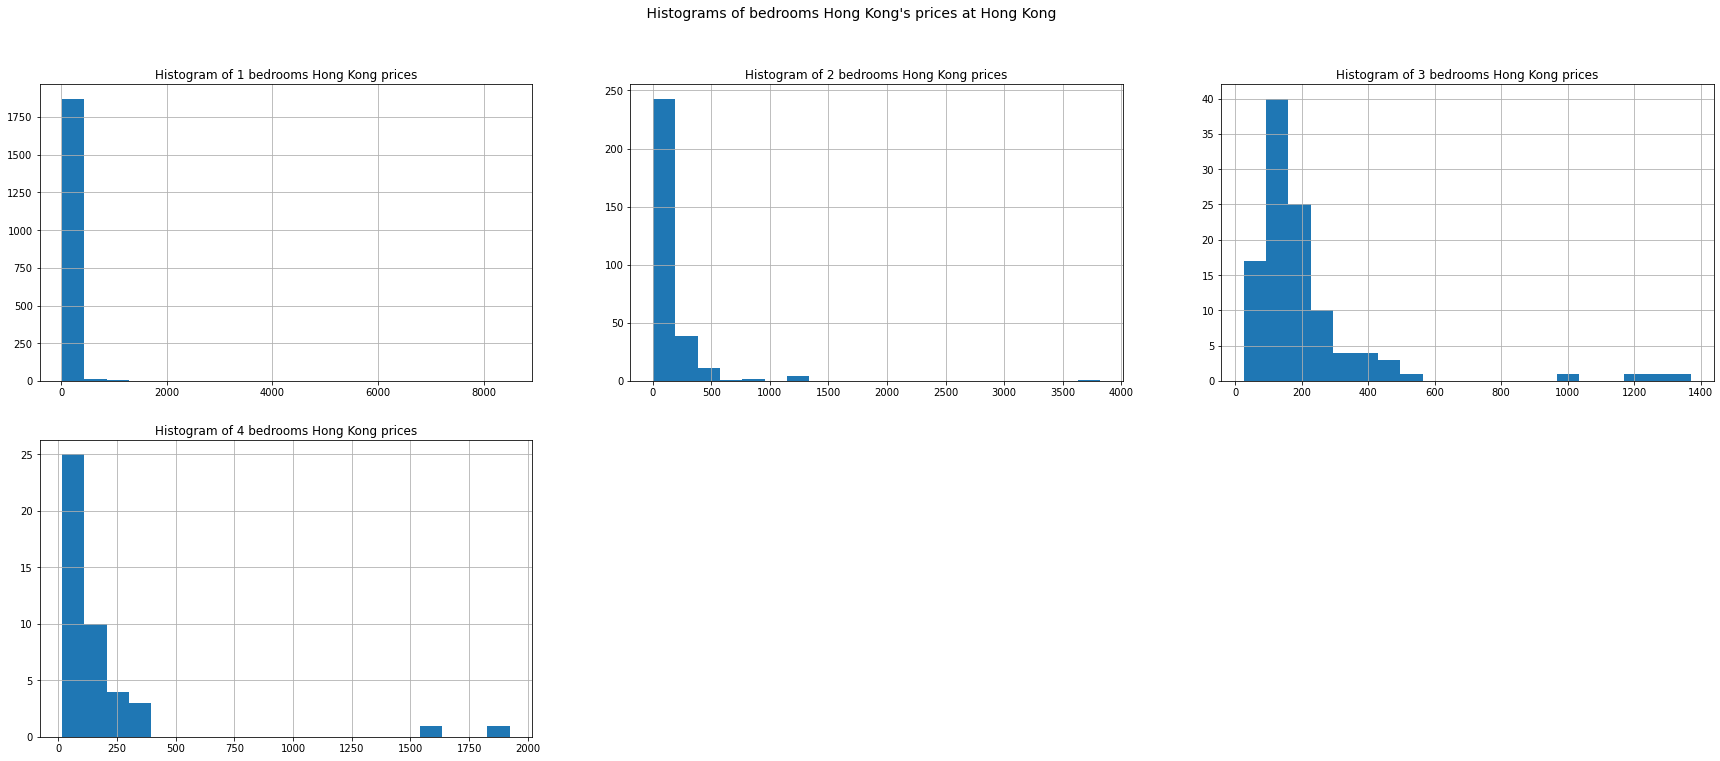

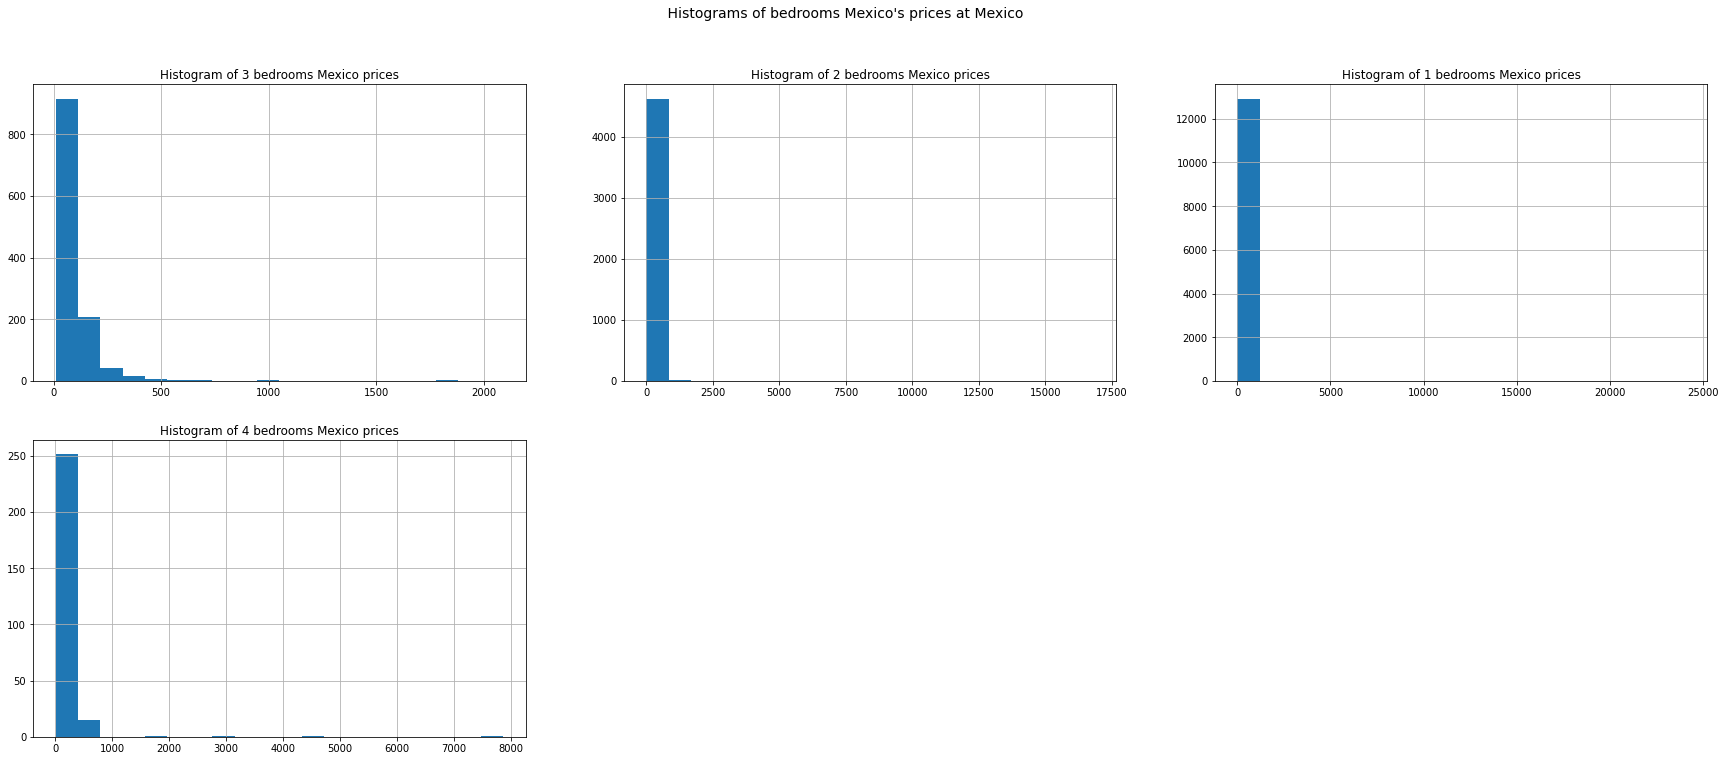

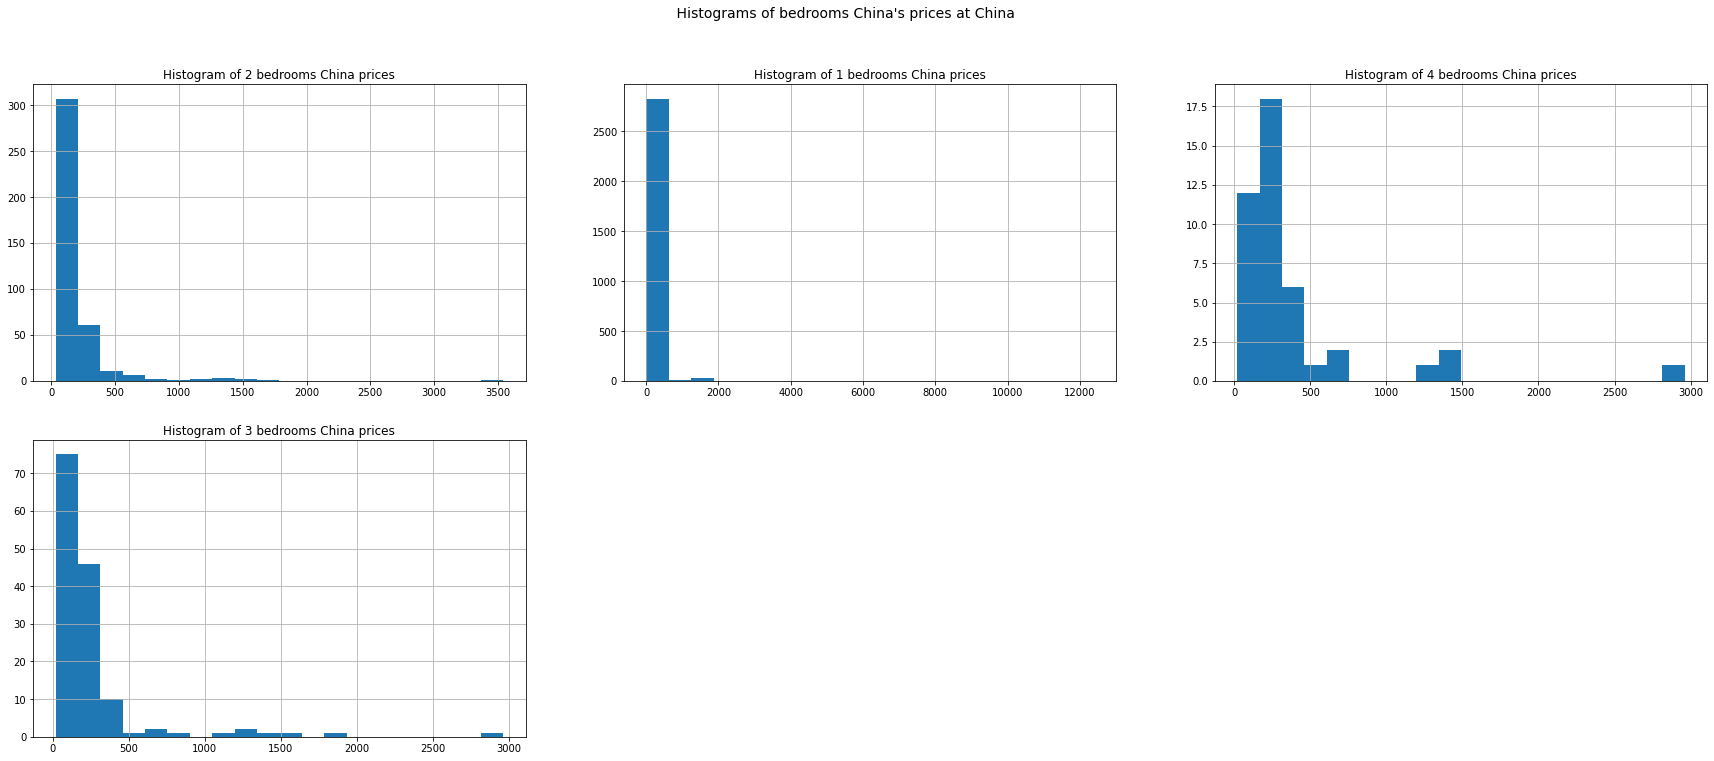

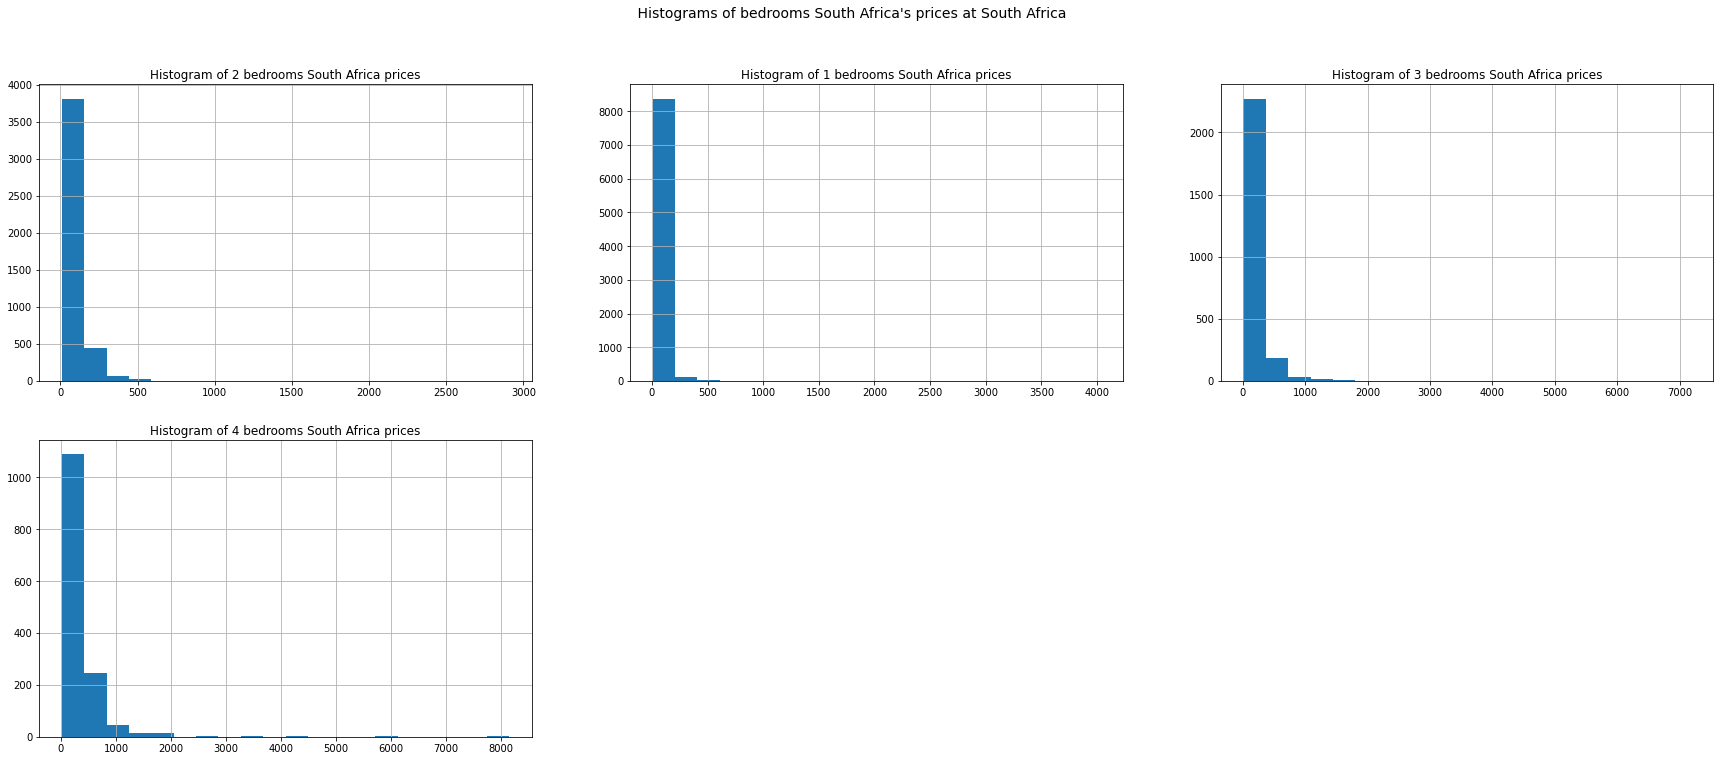

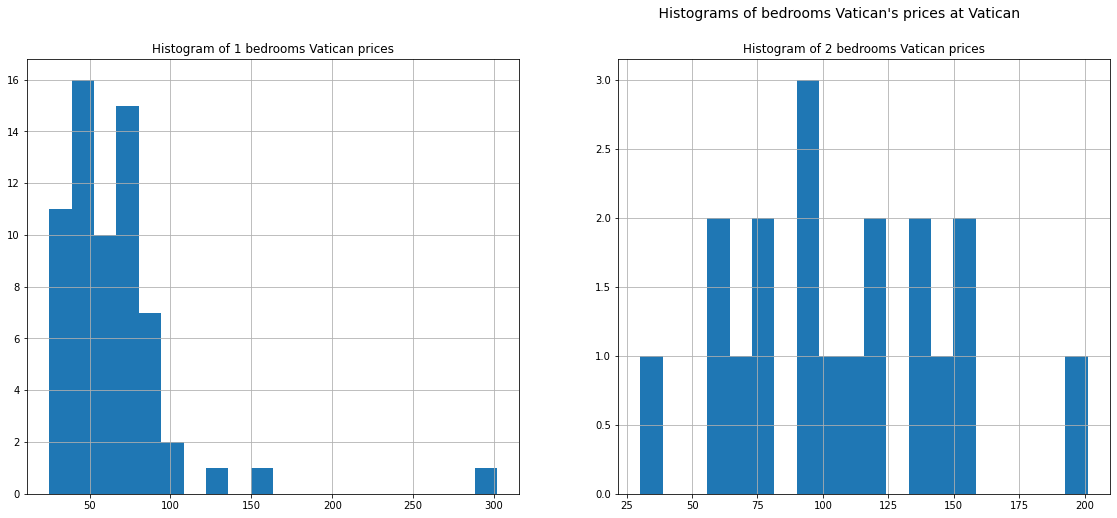

In [224]:
df_price_per_countries_and_bedrooms= checking_ANOVA_per_countries_and_categories(df_listings[df_listings["bedrooms"]<5],"country_name","bedrooms")


In [225]:
testing_for_outliers(df_price_per_countries_and_bedrooms)


Outliers test results for:bedrooms France
1 group
Number of values above upper bound:2743 ,Number of values below lower bound: 0
2 group
Number of values above upper bound:579 ,Number of values below lower bound: 0
3 group
Number of values above upper bound:171 ,Number of values below lower bound: 0
4 group
Number of values above upper bound:53 ,Number of values below lower bound: 0

Outliers test results for:bedrooms USA
1 group
Number of values above upper bound:1525 ,Number of values below lower bound: 0
3 group
Number of values above upper bound:131 ,Number of values below lower bound: 0
2 group
Number of values above upper bound:317 ,Number of values below lower bound: 0
4 group
Number of values above upper bound:35 ,Number of values below lower bound: 0

Outliers test results for:bedrooms Thailand
1 group
Number of values above upper bound:1001 ,Number of values below lower bound: 0
2 group
Number of values above upper bound:157 ,Number of values below lower bound: 0
3 group
Num

In [226]:
mood_median_test_results_between_categories_values(df_price_per_countries_and_bedrooms)

bedrooms France
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
bedrooms USA
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
bedrooms Thailand
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
bedrooms Brazil
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
bedrooms Australia
Median's between groups are not equal per Mood's median test (p<0.05):
 [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]
Median's betw

 **Price differences per countries and instant-booking analysis**



Results for country:France
levene's test results:
                  W          pval  equal_var
levene  198.225372  5.937216e-45      False


Results for country:USA
levene's test results:
                W      pval  equal_var
levene  0.235576  0.627423       True


Results for country:Thailand
levene's test results:
               W     pval  equal_var
levene  0.45163  0.50157       True


Results for country:Brazil
levene's test results:
                W      pval  equal_var
levene  0.401549  0.526296       True


Results for country:Australia
levene's test results:
                 W          pval  equal_var
levene  40.793713  1.713835e-10      False


Results for country:Turkey
levene's test results:
                 W      pval  equal_var
levene  12.791203  0.000349      False


Results for country:Italy
levene's test results:
                 W      pval  equal_var
levene  20.466139  0.000006      False


Results for country:Hong Kong
levene's test results:
                 W 

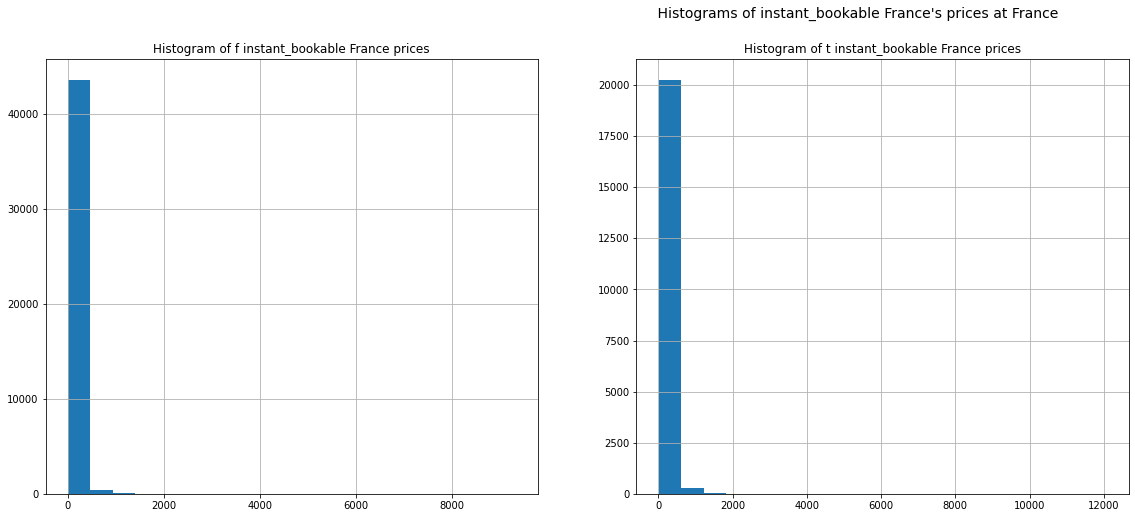

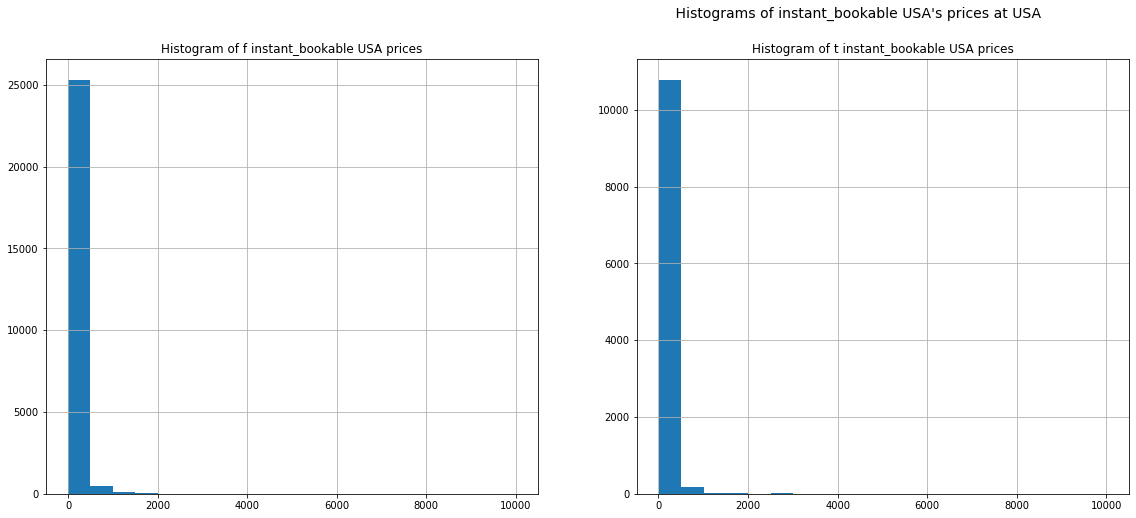

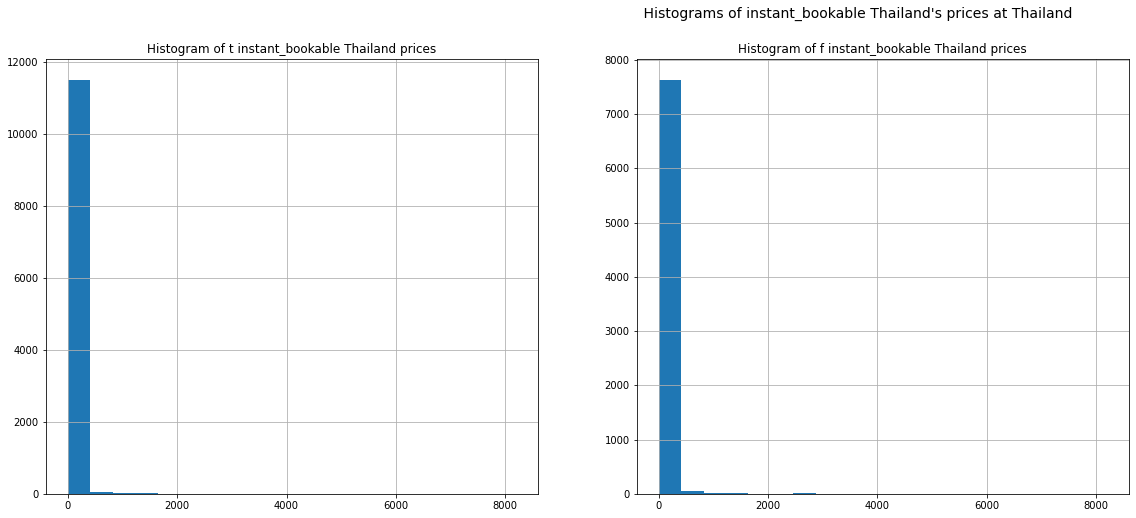

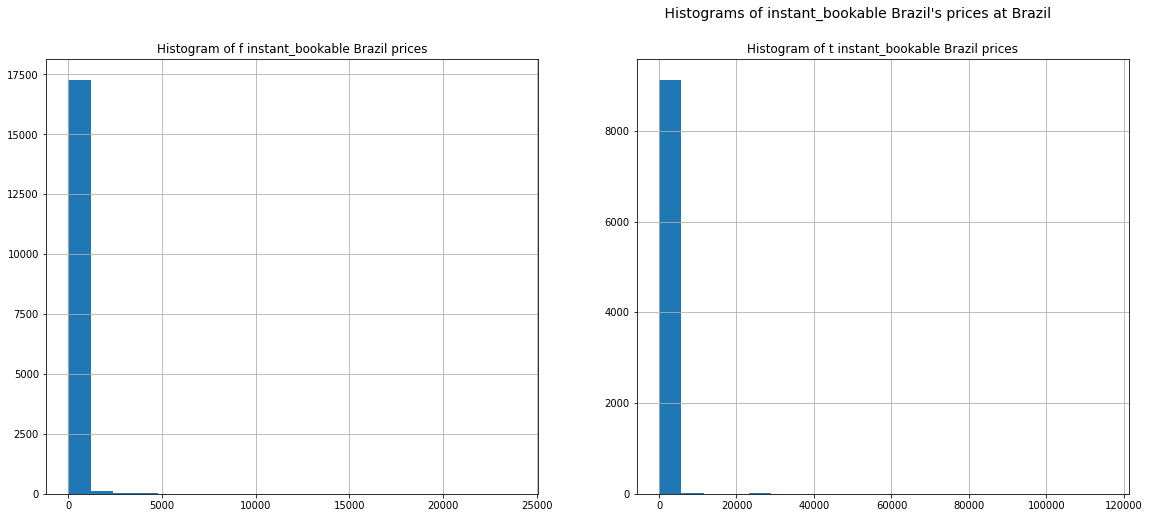

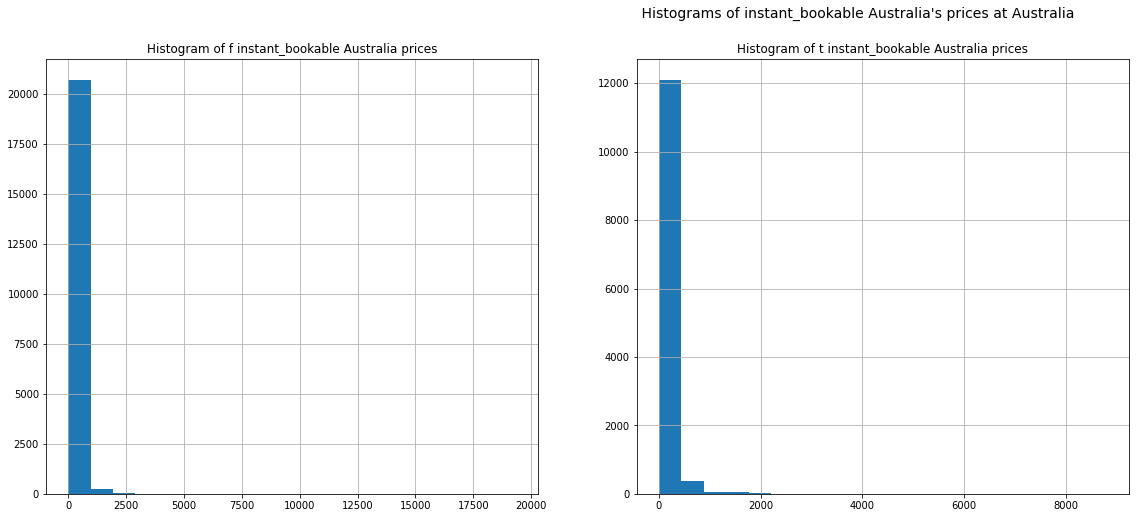

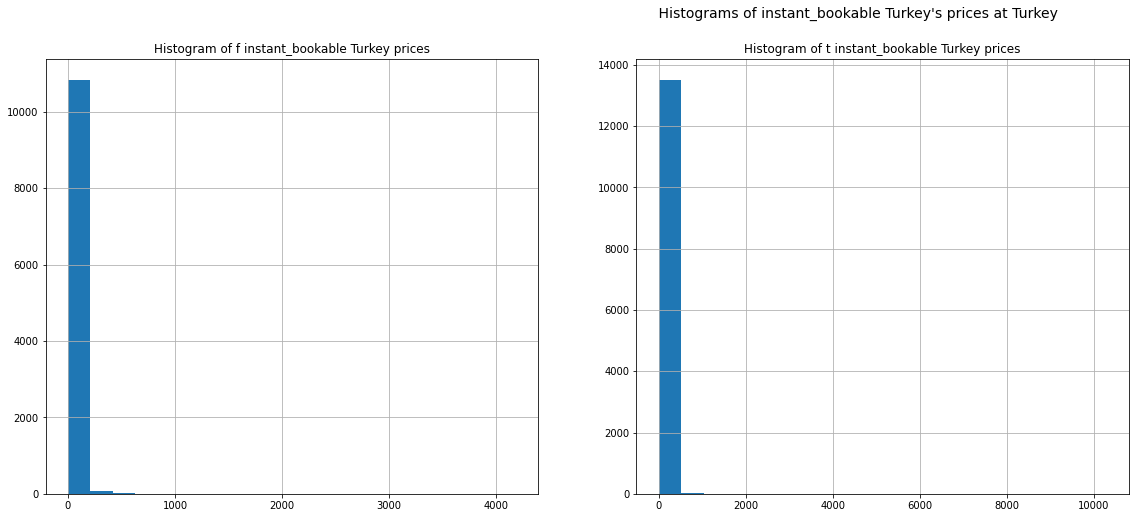

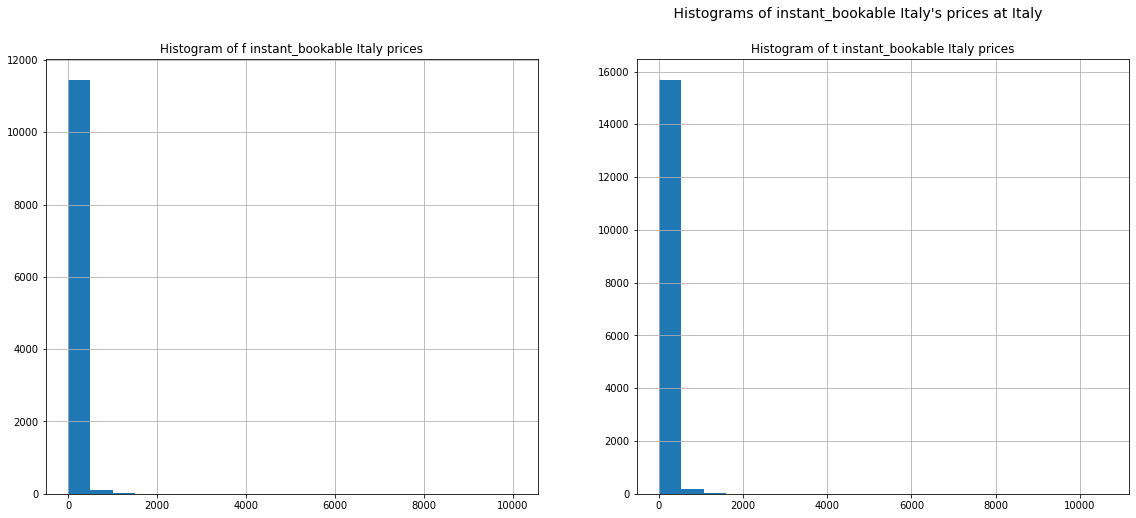

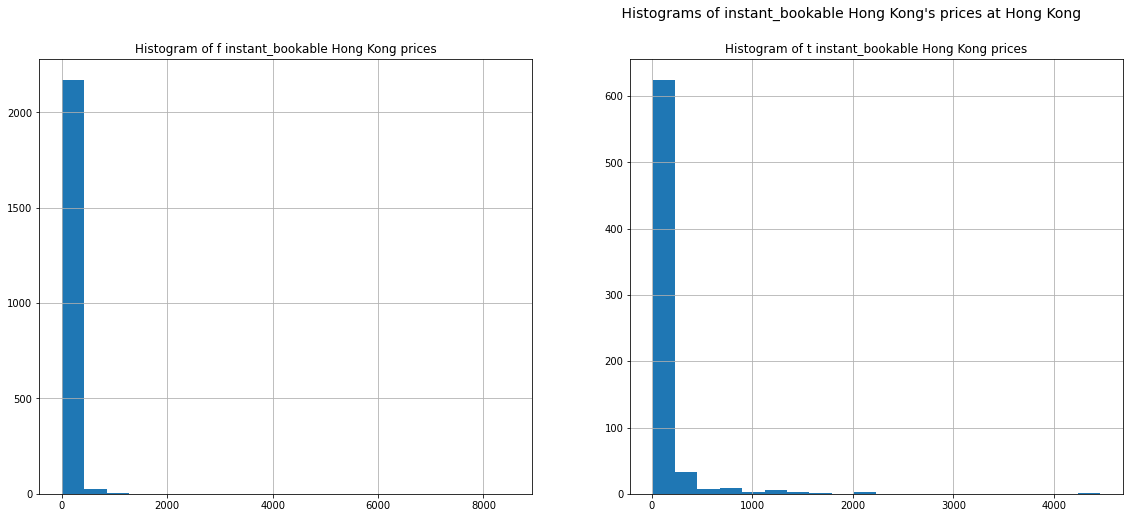

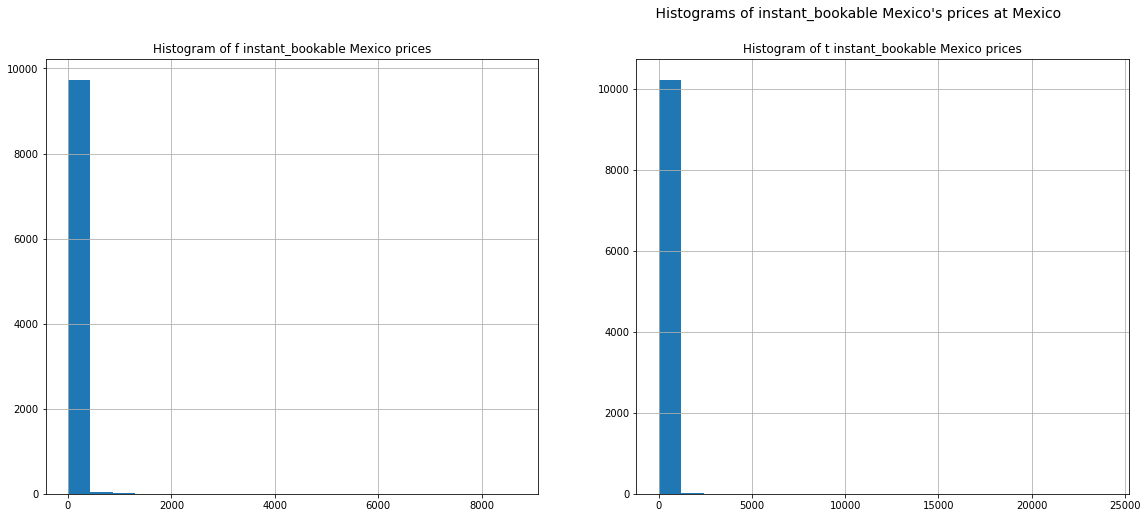

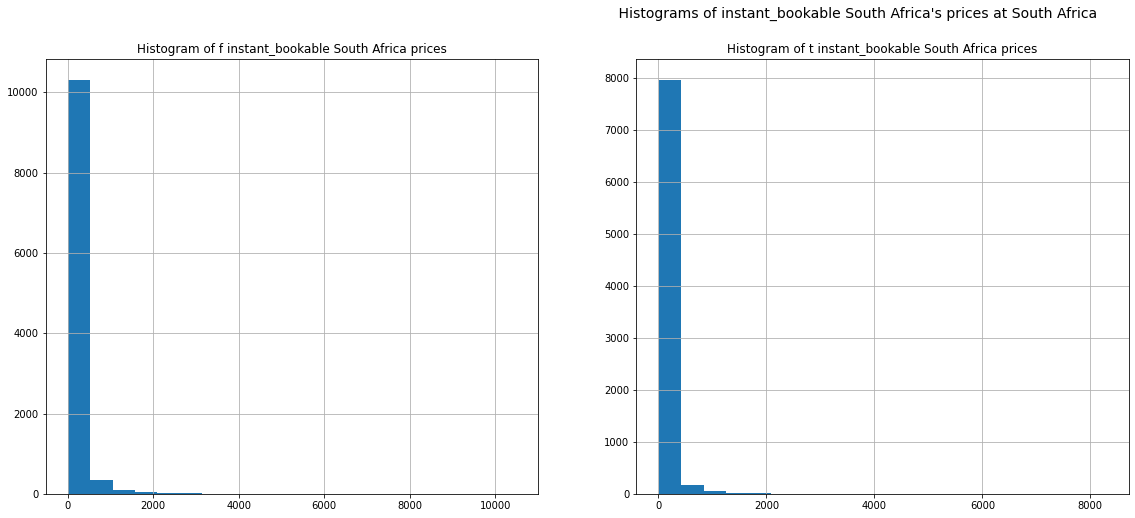

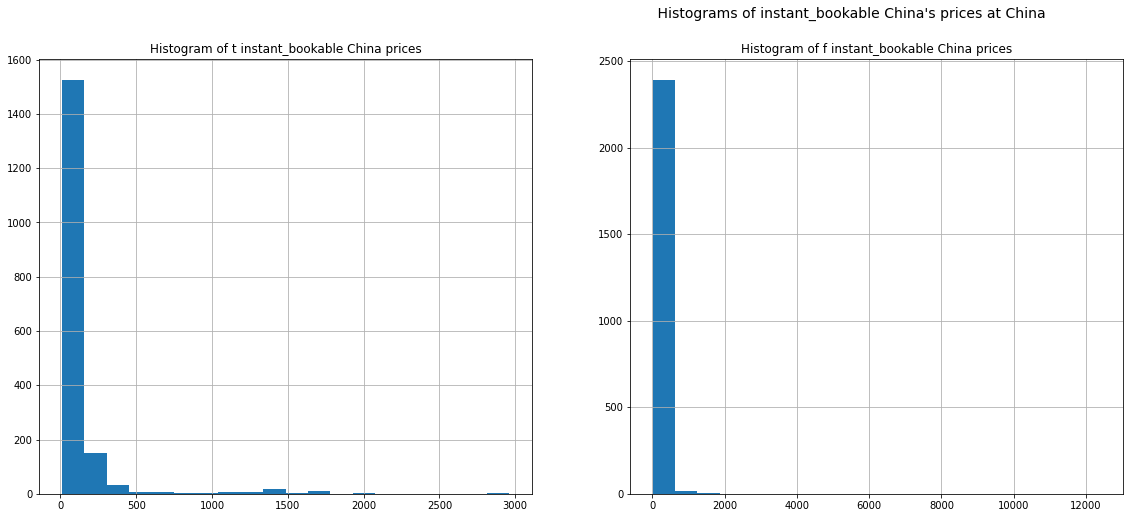

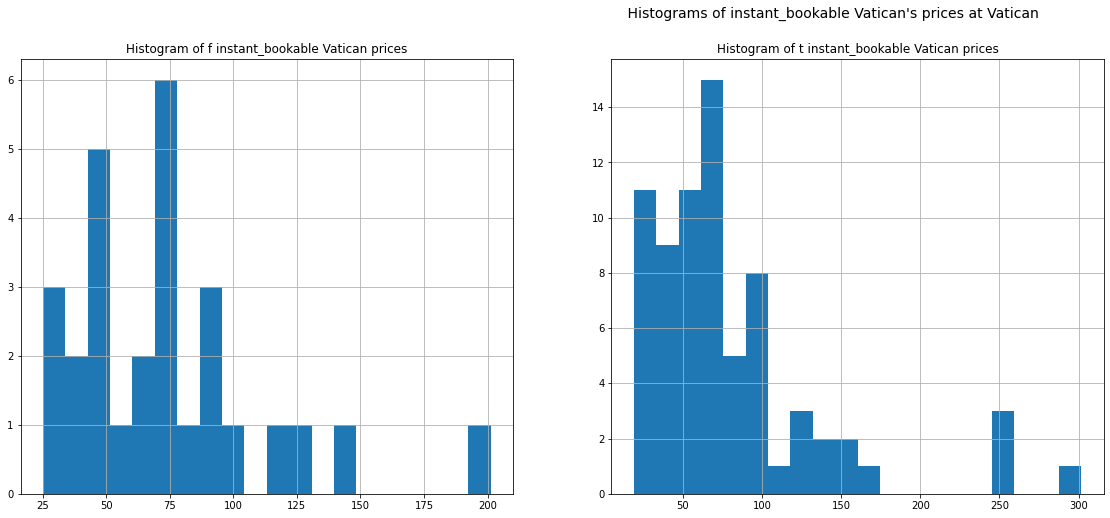

In [227]:
df_price_per_countries_and_instant_booking= checking_ANOVA_per_countries_and_categories(df_listings,"country_name","instant_bookable")


In [228]:
testing_for_outliers(df_price_per_countries_and_instant_booking)


Outliers test results for:instant_bookable France
f group
Number of values above upper bound:3568 ,Number of values below lower bound: 0
t group
Number of values above upper bound:1924 ,Number of values below lower bound: 0

Outliers test results for:instant_bookable USA
f group
Number of values above upper bound:1848 ,Number of values below lower bound: 0
t group
Number of values above upper bound:850 ,Number of values below lower bound: 0

Outliers test results for:instant_bookable Thailand
t group
Number of values above upper bound:1152 ,Number of values below lower bound: 0
f group
Number of values above upper bound:653 ,Number of values below lower bound: 0

Outliers test results for:instant_bookable Brazil
f group
Number of values above upper bound:1780 ,Number of values below lower bound: 0
t group
Number of values above upper bound:865 ,Number of values below lower bound: 0

Outliers test results for:instant_bookable Australia
f group
Number of values above upper bound:2116 ,N

In [229]:
mood_median_test_results_between_categories_values(df_price_per_countries_and_instant_booking)

instant_bookable France
Median's between groups are not equal per Mood's median test (p<0.05):
 [['f', 't']]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
instant_bookable USA
Median's between groups are not equal per Mood's median test (p<0.05):
 [['f', 't']]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
instant_bookable Thailand
Median's between groups are not equal per Mood's median test (p<0.05):
 [['f', 't']]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
instant_bookable Brazil
Median's between groups are not equal per Mood's median test (p<0.05):
 [['f', 't']]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
instant_bookable Australia
Median's between groups are not equal per Mood's median test (p<0.05):
 [['f', 't']]
Median's between groups can be equal per Mood's median test (p>=0.05):
 []
instant_bookable Turkey
Median's between groups are not equal per Mood's media

**EDA Summary**:
* General:
    * df_listings data contains 279712 unique listings
    * df_reviews data contains 5372983 unique reviews
    * df_reviews data contains 193556 unique reviewed listings
* Host data EDA:
    *  The hosts joined data per year is left skewed.
    * 16% of the hosts joined to Airbnb during 2015
    * Most of the hosts have profile picture (99.7%) , not considered super-hosts (82.0%) and their identify was verified (72%).
* Listings' characteristics EDA:
    * 58.7% of the listings are not instant bookable.
    * Listings which are establishing more than 1% of the available properties, are of private spaces.  49.7% of the listings are of Entire Apartment.
    * 88.2% of the listings have up to 4 bedrooms, 60.8% of the listings have only one bedroom.
    * 42.3% of the listings can accommodate up to two guests.
    * From the descriptive statistics and box-plots it is seen that the bedrooms and number of guests the listing can accommodate data is positively skewed. 
* Listings per thier Review Score EDA
    * Most of the listings received the maximal score (out of 10) per the rating criteria. 55% of the listings received overall rating score of 90 or above. In general, it is seen that positive feedback is more common/ frequent than negative feedback (low score).
    * From the descriptive statistics and box-plots it is seen that the reviews- score data is negatively skewed. It is seen that the IQR of review_scores_cleanliness and review_scores_checkin is one value- 10.
* Amenities EDA:
    * There are total of 3235 amenities in the dataset 
    * There are total of 1057 amenities of top-rated listings in the dataset 
    * There are total of 858 amenities of most expensive listings (top 10% of the price) in the dataset 


**Data Analysis:**

* Data analysis method:

The prices per country were initially inspected using Histogram and levene’s statistical test for equal variance. Minimal sample size of 15 samples per each group was determined.
Per the analysis results none of the countries’ prices distribution seemed normal or the results of Levene’s test concluded that the samples don’t have equal variance (p<0.05, null hypothesis that all input samples are from populations with equal variances).
Based on the above, ANOVA wasn’t used. Since the data has outliers, Mood’s median test was used to evaluate if the samples come from populations with the same median.  Mood’s median test was applied between each group to others.

* Data analysis results:

    *  Price per country:
        * France has the larger amount of listings (23.1%), with median price per listing of 80.5 USD.
        * The median price of listing per country is the largest in USA (substitutes 13.2% of the listings), and is 99.0 USD.
        * Per the 11 countries analyzed (all besides Vatican), there is a difference between the median price of a listing between countries.
    * Attributes impact on Price:
        * The number of accommodates and bedrooms impacts the median price of a listing per country (besides of Hong-Kong and Vatican which wasn’t evaluated).  The median price of a 
    listing raising respectively to the number of accommodates and bedrooms.
        * The instant-booking option impacts the median price of a listing per country (besides Mexico and Vatican which wasn’t evaluated).  However, the kind of impact on the price varies per country.